In [ ]:
#pip install lifelines

In [1]:
import numpy as np
import pandas as pd
import math
from math import *
import datetime
import random
import statistics
import matplotlib.pyplot as plt
from numpy import log as ln
import scipy
import scipy.integrate as integrate
from scipy.integrate import quad
from scipy.stats import norm
from math import erf
from lifelines import *
from lifelines.plotting import plot_lifetimes
from scipy.integrate import quad
from bisect import *

In [2]:
## Kernel estimation

def K_epav(u):

    ker_e = (3/4)*(1- (u*u))*(1 if np.abs(u) <= 1 else np.abs(0))
    
    return ker_e

def K_norm(u):

    ker_n = (1/math.sqrt(2*np.pi))*math.exp(- ((u*u)/2))
    '''
    exponent = - ((u*u)/2)
    b = ne.evaluate('exp(exponent)')
    ker_n = (1 / math.sqrt(2 * np.pi)) * b
    '''
    return ker_n



In [3]:
# Simulation1:Actual hazard calc Calc for T = exp(e + Y), where Y is constant and e ~ exp(1)


def pdf1(a,yi):
    k = yi
    f = np.where(a >= math.exp(k),(math.exp(k))/(a**2),0)
    return f

def survival1(b,yi):
    k = yi
    S = np.where(b >= math.exp(k),(math.exp(k))/(b),0)
    return S
    
def hazard1_cal(c,yi):
    k = yi
    hazard_calc = np.where(c >= math.exp(k),((math.exp(k))/(c**2))/((math.exp(k))/(c)),0)
    return hazard_calc



## model for Variable T1 and fix Y1
def model1_T(ti,yi):
    k = yi
    actual_haz = []
    for t_index in range(len(ti)):
        if ti[t_index]>=math.exp(yi):
            actual_haz.append(1/ti[t_index])
        else:
            actual_haz.append(0)
    return actual_haz


## model for Variable Y1 and fix T1

def model1_Y(ti,yi):
    actual_haz = []
    for y_index in range(len(yi)):
        k = yi[y_index]
        if ti>=math.exp(k):
            actual_haz.append(1/ti)
        else:
            actual_haz.append(0)
    return actual_haz



    

In [4]:
#Simulation2: Actual hazard calc Calc for T = exp((5-(10(1-Y)^2) + e), where Y is constant and e ~ N(0,1)


def pdf2(a,const):
    return (1/(a*math.sqrt(math.pi * 2)))*math.exp(-((ln(a)-const)**2)/2)


def survival2(a,const):
    f = lambda a:(1/(math.sqrt(math.pi * 2)))*math.exp(-((ln(a)-(const))**2)/2)
    I = scipy.integrate.quad(f, 0,(ln(a)-const))
    S = 1- I[0]
    return S

## model for Variable T1 and fix Y1
def model2_T(ti,y):
    actual_haz = []
    kt = (5 - (10*((1-y)**2)))
    for t_index in range(len(ti)):
        if ti[t_index]>0:
            if survival2(ti[t_index],kt)>0:
                actual_haz.append((pdf2(ti[t_index],kt)/survival2(ti[t_index],kt)))
            else:
                actual_haz.append(20)
        else:
            actual_haz.append(0)
    return actual_haz



## model for Variable Y1 and fix T1

def model2_Y(t,yi):
    actual_haz = []
    for y_index in range(len(yi)):
        ky = (5 - (10*((1-yi[y_index])**2)))
        #print(ky)
        if t>0:
            if survival2(t,ky)>0:
                actual_haz.append((pdf2(t,ky)/survival2(t,ky)))
            else:
                actual_haz.append(20)
        else:
            actual_haz.append(0)
    return actual_haz





In [5]:
#Simulation 1: 

## model for Variable T1 and fix Y1
def model3_T(ti,yi):
    k = math.exp(yi)*25
    actual_haz = []
    for t_index in range(len(ti)):
        if ti[t_index]>0 and k>0:
            actual_haz.append((3)*(k**(-3))*(ti[t_index]**(2)))
        else:
            actual_haz.append(0)
    return actual_haz

## model for Variable T1 and fix Y1
def model3_cumT(ti,yi):
    k = math.exp(yi)*25
    cum_actual_haz = []
    for t_index in range(len(ti)):
        if ti[t_index]>0 and k>0:
            cum_actual_haz.append((1)*(k**(-3))*(ti[t_index]**(3)))
        else:
            cum_actual_haz.append(0)
    return cum_actual_haz



## model for Variable Y1 and fix T1

def model3_Y(ti,yi):
    actual_haz = []
    for y_index in range(len(yi)):
        k = math.exp(yi[y_index])*25
        if ti>0 and k>0:
            actual_haz.append((3)*(k**(-3))*(ti**(2)))
        else:
            actual_haz.append(0)
    return actual_haz





In [6]:
# Generate Data

# Train Data

def generate_data_dist1(counter, h_exp=None, b_exp=None,size =500,censor_proportion = 100):
    if h_exp is None:
        h_exp = 1
    if b_exp is None:
        b_exp = 1

    
    Y = np.random.uniform(low = 0.0, high = 1.0, size=size) 
    e = np.random.exponential(1, size=size)
    
    ## Event time
    T = np.exp(Y+e)
    
    ## Censoring time    
    C= np.random.uniform(low = 0.0, high=censor_proportion, size=size) 


    ## Z and delta
    Z = np.where(np.greater(T,C),C,T)
    delta = np.where(np.greater_equal(T,C),0,1)

    q75, q25 = np.percentile(Z, [75 ,25])
    iqr = q75 - q25
    q751, q251 = np.percentile(Y, [75 ,25])
    iqr1 = q751 - q251

    h= min(iqr1,(statistics.stdev(Y)))*(size**(-(1/5)))*h_exp
    
    b = min(iqr,(statistics.stdev(Z)))*(size**(-(1/5)))*b_exp



    print(f'h:{h}')
    print(f'b:{b}')
   
    return Y,e,T,C,Z,delta,h,b
    

def generate_data_dist2(counter, h_exp=None, b_exp=None,size =500, censor_proportion = 100):
    if h_exp is None:
        h_exp = 1
    if b_exp is None:
        b_exp = 1
    
    Y = np.random.uniform(0.0, 1.0, size=size) 
    e = np.random.normal(0, 1, size=size)
    yc = 5-(10*((1-Y)**2))
    T = np.exp(yc+e)

    ## Censoring time    
    C= np.random.uniform(low = 0.0, high = censor_proportion, size=size) 
    

    ## Z and delta
    Z = np.where(np.greater(T,C),C,T)
    delta = np.where(np.greater_equal(T,C),0,1)


    q75, q25 = np.percentile(Z, [75 ,25])
    iqr = q75 - q25
    q751, q251 = np.percentile(Y, [75 ,25])
    iqr1 = q751 - q251


    h= min(iqr1,(statistics.stdev(Y)))*(size**(-(1/5)))*h_exp
    b = min(iqr,(statistics.stdev(Z)))*(size**(-(1/5)))*b_exp

    print(f'h:{h}')
    print(f'b:{b}')
   

    return Y,e,T,C,Z,delta,h,b
    

def generate_data_dist3(counter, h_exp=None, b_exp=None,size = 500, censor_proportion = 100):
    if h_exp is None:
        h_exp = 1
    if b_exp is None:
        b_exp = 1
    
    Y = np.random.normal(0, 1, size=size)
    yc= np.exp(Y)*25
    e = np.random.uniform(0,1, size=size)
    T = yc*((-1*np.log(e))**(1/3))

    ## Censoring time    
    C= np.random.uniform(low = 0.0, high = censor_proportion, size=size) 
    

    ## Z and delta
    Z = np.where(np.greater(T,C),C,T)
    delta = np.where(np.greater_equal(T,C),0,1)


    q75, q25 = np.percentile(Z, [75 ,25])
    iqr = q75 - q25
    q751, q251 = np.percentile(Y, [75 ,25])
    iqr1 = q751 - q251


    h = min(iqr1,(statistics.stdev(Y)))*(size**(-(1/5)))*h_exp
    b = min(iqr,(statistics.stdev(Z)))*(size**(-(1/5)))*b_exp


    print(f'h:{h}')
    print(f'b:{b}')
    
    return Y,e,T,C,Z,delta,h,b




In [7]:
####variable T1## Kernel estimation of hazard for different Time points

def kernel_estimation_t(Y,Y1,T,T1,Z,delta,h,b):
    haz_est = []
    for t_idx in range(len(T1)): 
        b1 = b
        h1 = h
        hazard_value = 0
        for i in range(len(T)):
            denominator =0
            for j in range(len(T)):
                zji_ge_flag = 0
                if Z[j] >= Z[i]:
                    zji_ge_flag = 1
                denominator = denominator + zji_ge_flag * (K_epav((Y[i]-Y1)/h)/h)
                
            if denominator > 0:
                numerator = ((K_epav((Z[i]-T1[t_idx])/b1))/b1)*delta[i]*(K_epav((Y[i]-Y1)/h1)/h1)
                hazard_value = hazard_value + (numerator/denominator)
            else:
                hazard_value = hazard_value + 0
        if T1[t_idx]==0 :
            hazard_value =  0
        else:
            hazard_value = hazard_value
                
        print(f'hazard_value_t :{hazard_value}')
        haz_est.append(hazard_value)
    return haz_est,h,b


####variable Y1
## Kernel estimation of hazard for different covriates

def kernel_estimation_y(Y,Y2,T,T2,Z,delta,h,b):
    haz_est = []
    for y_idx in range(len(Y2)):
        hazard_value = 0
        for i in range(len(T)):
            denominator =0
            
            for j in range(len(T)):
                zji_ge_flag = 0
                if Z[j] >= Z[i]:
                    zji_ge_flag = 1
                
                denominator = denominator + zji_ge_flag * (K_epav((Y[i]-Y2[y_idx])/h)/h)
            if denominator > 0:
                numerator = ((K_epav((Z[i]-T2)/b))/b)*delta[i]*(K_epav((Y[i]-Y2[y_idx])/h)/h)
                hazard_value = hazard_value + (numerator/denominator)
            else:
                hazard_value = hazard_value + 0
        print(f'hazard_value_y:{hazard_value}')
        
        haz_est.append(hazard_value)
    return haz_est,h,b





In [8]:
def nelson_cum(Z,T1,d,size):
    
    h_cum_t =[]
    
    
    # Insert zero as first element in  time(Z) and event(d)
    Z_nel = Z
    Z_nel=np.insert(Z_nel, 0, 0)
    di=np.insert(d, 0, 0)
    
    #combine time and event in one dataframe and sort it my time
    data_haz =  pd.DataFrame({'Z_nel':Z_nel, 'di':di}) 
    data_haz = data_haz.sort_values(by=['Z_nel']).reset_index(drop=True)
    
    #number at risk
    data_haz['ni_risk'] =np.array(range(size, 0,-1))
    #hazard
    Test_cum = data_haz['Z_nel']
    hi = np.divide(data_haz['di'],data_haz['ni_risk'])
    
    #cumulative hazard
    h_cum = np.cumsum(hi)
    
    #Extract cumulative hazard at test points
    for t_idx in range(len(T1)):
        indx = bisect_left(Test_cum,T1[t_idx])-1
        if indx<0:
            indx = 0
        else:
            indx = indx
        h_cum_t.append(h_cum[indx])
    return h_cum_t




In [9]:
# Mean,standard deviation and 95%CI of simulations

def averages_t(actual_haz,estimated_hazard,estimated_cum_haz,nelson_cum_haz,avg_h,avg_b):
    
    idx = np.array([i for i, arr in enumerate(estimated_hazard) if  np.isfinite(arr).all()])
    estimated_finite = [estimated_hazard[i] for i in idx]
    estimated = np.array(estimated_finite)
    
    #bandwidth
    avg_hband = np.nanmean(avg_h, axis = 0)     
    avg_bband = np.nanmean(avg_b, axis = 0)     
     
    #mean
    mean_estimate = np.nanmean(estimated, axis = 0)
    mean_estimate_cum = np.nanmean(estimated_cum_haz, axis = 0)
    mean_nelson_cum = np.nanmean(nelson_cum_haz, axis = 0)
    #bias in estimated hazard
    bias_sq = (mean_estimate - actual_haz)
    

    #standard deviation
    std_estimate = np.nanstd(estimated, axis = 0)
    cum_std_estimate = np.nanstd(estimated_cum_haz, axis = 0)
    nelcum_std_estimate = np.nanstd(nelson_cum_haz, axis = 0)
    
    #95% CI
    CI_lower = np.nanmean(estimated, axis = 0)-std_estimate
    CI_upper = np.nanmean(estimated, axis = 0)+std_estimate

    cum_CI_lower = np.nanmean(estimated_cum_haz, axis = 0)-cum_std_estimate
    cum_CI_upper = np.nanmean(estimated_cum_haz, axis = 0)+cum_std_estimate

    nelcum_CI_lower = np.nanmean(nelson_cum_haz, axis = 0)-nelcum_std_estimate
    nelcum_CI_upper = np.nanmean(nelson_cum_haz, axis = 0)+nelcum_std_estimate

    #MSE
    MSE = np.sum(np.array(bias_sq**2 + std_estimate**2))
    print(f'MSE:{MSE}')
    
    return estimated,mean_estimate,mean_estimate_cum,mean_nelson_cum,CI_lower,CI_upper,cum_CI_lower,cum_CI_upper,nelcum_CI_lower,nelcum_CI_upper,avg_hband,avg_bband

In [10]:
# Mean,standard deviation and 95%CI of simulations
def averages_y(estimated_hazard,actual_haz,avg_h,avg_b):
    
    idx = np.array([i for i, arr in enumerate(estimated_hazard) if  np.isfinite(arr).all()])
    estimated_finite = [ estimated_hazard[i] for i in idx]
    estimated = np.array(estimated_finite)
    
    #bandwidth
    avg_hband = np.nanmean(avg_h, axis = 0)     
    avg_bband = np.nanmean(avg_b, axis = 0)     
     
    #mean
    mean_estimate = np.nanmean(estimated, axis = 0)
    #bias
    bias_sq = (mean_estimate-actual_haz)
    #standard deviation
    std_estimate = np.nanstd(estimated, axis = 0)
    
    #95% CI
    CI_lower = np.nanmean(estimated, axis = 0)-std_estimate
    CI_upper = np.nanmean(estimated, axis = 0)+std_estimate
    
    #MSE
    MSE = np.sum(np.array(bias_sq**2 + std_estimate**2))
    print(f'MSE:{MSE}')
    
    return estimated,mean_estimate,CI_lower,CI_upper,avg_hband,avg_bband

In [11]:
## Variable T1
## Plot

def plots_t(T11,delta11,Ytest,Ttest, actual_hazard, mean_estimate, act_cum, est_cum, nel_cum,CI_lower,CI_upper,CI_lower_cmh,CI_upper_cmh,CI_lower_ncmh,CI_upper_ncmh,cntrs,h_exp,b_exp):
    
    #Plot hazards
    fig, ax1 =plt.subplots()
    fig.set_size_inches(8.5,9.5)
    ax1.plot(Ttest, actual_hazard,'-o', label='Hazard Function',color="black")
    ax1.plot(Ttest, mean_estimate,'-o', label='Mean of 1000 simulation')
    ax1.plot(Ttest, CI_lower, label='95% CI Lower band',linestyle="--")
    ax1.plot(Ttest, CI_upper, label='95% CI Upper band',linestyle="--")

    # Naming the x-axis, y-axis and the whole graph
    ax1.set_ylabel("Hazard Function")
    ax1.set_xlabel("Time")
    ax1.set_title("Hazard Function : T = {exp(Y+e)} where e ~ exp(1),Y~uniform(0,1) ")
    #ax1.set_title("Simulation : T = {exp(5-(10*((1-Y)**2))+e)} where e~Normal(0,1),Y~uniform(0,1) ")
    #ax1.set_title("Simulation : T = {25*exp(Y)*((-1*np.log(e))**(1/3))} where e~uniform(0,1),Y~Normal(0,1) ")
    ax1.legend(loc='center left',bbox_to_anchor =(1.15,0.8))
    
    plt.savefig(f'/Users/savitaupadhyay/Desktop/simulation1/T2Y0.6/plot_t,hb{h_exp,b_exp}.png')
    plt.show()
   
    #Plot cumulative hazards
    fig, ax2 =plt.subplots()
    fig.set_size_inches(8.5,9.5)  
    ax2.plot(Ttest, act_cum,'-o', label='Actual cumulative hazard',color="black")
    ax2.plot(Ttest, est_cum,'-o', label='Estimated cumulative hazard',color="green")
    ax2.plot(Ttest, nel_cum,'-o', label='Nelson-Aalen cumulative hazard',color="red")
    
    ax2.plot(Ttest, CI_lower_cmh, label='95% Est. CI Lower band',linestyle=":")
    ax2.plot(Ttest, CI_upper_cmh, label='95% Est. CI Upper band',linestyle=":")
    ax2.plot(Ttest, CI_lower_ncmh, label='95% Nelson CI Lower band',linestyle="--")
    ax2.plot(Ttest, CI_upper_ncmh, label='95% Nelson CI Upper band',linestyle="--")

    # Naming the x-axis, y-axis and the whole graph
    ax2.set_ylabel("Cumulative Hazard")
    ax2.set_xlabel("Time")
    ax2.set_title("Cumulative Hazard Function : T = {exp(Y+e)} where e ~ exp(1),Y~uniform(0,1) ")
    #ax1.set_title("Simulation : T = {exp(5-(10*((1-Y)**2))+e)} where e~Normal(0,1),Y~uniform(0,1) ")
    #ax1.set_title("Simulation : T = {25*exp(Y)*((-1*np.log(e))**(1/3))} where e~uniform(0,1),Y~Normal(0,1) ")
    ax2.legend(loc='center left',bbox_to_anchor =(1.15,0.8))
    plt.savefig(f'/Users/savitaupadhyay/Desktop/simulation1/T2Y0.6/Cum_haz,hb{h_exp,b_exp}.png')
    plt.show()
      
 
    
    return None



## Variable Y1
## Plot
def plots_y(Ytest,Ttest, actual_hazard, mean_estimate, CI_lower,CI_upper,cntrs,h_exp,b_exp):
    fig, ax1 =plt.subplots()
    fig.set_size_inches(8.5,9.0)
    ax1.plot(Ytest, actual_hazard,'-o', label='Hazard Function',color="black")
    ax1.plot(Ytest, mean_estimate,'-o', label='Mean of 1000 simulation')
    ax1.plot(Ytest, CI_lower, label='95% CI Lower band',linestyle="--")
    ax1.plot(Ytest, CI_upper, label='95% CI Upper band',linestyle="--")



    # Naming the x-axis, y-axis and the whole graph
    ax1.set_ylabel("Hazard Function")
    ax1.set_xlabel("Covariate")
    
    ax1.set_title("Hazard Function : T = {exp(Y+e)} where e~exp(1),Y~uniform(0,1) ")
    #ax1.set_title("Simulation : T = {exp(5-(10*((1-Y)**2))+e)} where e~Normal(0,1),Y~uniform(0,1) ")
    #ax1.set_title("Simulation : T = {25*exp(Y)*((-1*np.log(e))**(1/3))} where e~uniform(0,1),Y~Normal(0,1) ")



    # Adding legend, which helps us recognize the curve according to it's color
    ax1.legend(loc='center left',bbox_to_anchor =(1.15,0.8))

    plt.savefig(f'/Users/savitaupadhyay/Desktop/simulation1/T2Y0.6/plot_y,hb{h_exp,b_exp}.png')
    plt.show()
    




    
    return None

In [12]:
# Define Experiment for Simulation2
def experiment1(Y1,T1,Y2,T2, cntr, actual_hazard_y, actual_hazard_t,
                h_exp=None, b_exp=None,  size = 500, censor_proportion = 200, simulations = 1
               ):
    #no .of iterations
    estimated_hazard_t =[]*simulations
    bias_t = []*simulations
    estimated_cumhazard_t =[]*simulations
    
    estimated_hazard_y =[]*simulations
    bias_y = []*simulations
    h_band = []*simulations
    b_band = []*simulations

    nelson_cumhazard_t =[]*simulations
    
    simulations = simulations
    for simulation_no in range(simulations):
        print(f'simulation no is {simulation_no}:' )
        
        #step 1: generate data
        
        Y,e,T,C,Z,delta,h,b =  generate_data_dist1(cntr, h_exp, b_exp, size = size, censor_proportion = censor_proportion)

        # step2: kernel estimation   
        res1,h_band,b_band = kernel_estimation_t(Y,Y1,T,T1,Z,delta,h,b)
        res2,h_band,b_band = kernel_estimation_y(Y,Y2,T,T2,Z,delta,h,b)
        
        #Nelson-Aalen cumulative hazard
        cumres1 = scipy.integrate.cumulative_trapezoid(res1, x=T1, dx=0.001, axis=-1, initial=0)
        nelson_cumhaz = nelson_cum(Z,T1,delta,size+1)
        
        #Appending results of simulation to nd-array for different T
        estimated_hazard_t.append(res1)
        bias_t.append(np.array(estimated_hazard_t[simulation_no])-actual_hazard_t)
        
        #cumulative hazard
        estimated_cumhazard_t.append(cumres1)
        nelson_cumhazard_t.append(nelson_cumhaz)

        #Appending results of simulation to nd-array for different Y
        estimated_hazard_y.append(res2)
        bias_y.append(np.array(estimated_hazard_y[simulation_no])-actual_hazard_y)   
                      
    return estimated_hazard_t,bias_t,estimated_hazard_y,bias_y,estimated_cumhazard_t,nelson_cumhazard_t,h_band,b_band,T,Z,delta



# Define Experiment for Simulation2
def experiment2(Y1,T1,Y2,T2, cntr, actual_hazard_y, actual_hazard_t,
                h_exp=None, b_exp=None,  size = 500, censor_proportion = 200, simulations =100
               ):
    #no .of iterations
    estimated_hazard_t =[]*simulations
    bias_t = []*simulations
    estimated_cumhazard_t =[]*simulations
    
    estimated_hazard_y =[]*simulations
    bias_y = []*simulations
    h_band = []*simulations
    b_band = []*simulations

    nelson_cumhazard_t =[]*simulations
    
    simulations = simulations
    for simulation_no in range(simulations):
        print(f'simulation no is {simulation_no}:' )
        
        #step 1: generate data
        
        Y,e,T,C,Z,delta,h,b =  generate_data_dist2(cntr, h_exp, b_exp, size = size, censor_proportion = censor_proportion)

        # step2: kernel estimation   
        res1,h_band,b_band = kernel_estimation_t(Y,Y1,T,T1,Z,delta,h,b)
        res2,h_band,b_band = kernel_estimation_y(Y,Y2,T,T2,Z,delta,h,b)
        
        #Nelson-Aalen cumulative hazard
        cumres1 = scipy.integrate.cumulative_trapezoid(res1, x=T1, dx=0.001, axis=-1, initial=0)
        nelson_cumhaz = nelson_cum(Z,T1,delta,size + 1)
        
        #Appending results of simulation to nd-array for different T
        estimated_hazard_t.append(res1)
        bias_t.append(np.array(estimated_hazard_t[simulation_no])-actual_hazard_t)
        
        
        #cumulative hazard
        estimated_cumhazard_t.append(cumres1)
        nelson_cumhazard_t.append(nelson_cumhaz)
        
        #Appending results of simulation to nd-array for different Y
        estimated_hazard_y.append(res2)
        bias_y.append(np.array(estimated_hazard_y[simulation_no])-actual_hazard_y)   
    return estimated_hazard_t,bias_t,estimated_hazard_y,bias_y,estimated_cumhazard_t,nelson_cumhazard_t,h_band,b_band,T,Z,delta

                      





# Define Experiment for Simulation3
def experiment3(Y1,T1,Y2,T2, cntr, actual_hazard_y, actual_hazard_t,
                h_exp=None, b_exp=None, size = 500, censor_proportion = 200, simulations = 100
               ):

    #no .of iterations
    estimated_hazard_t =[]*simulations
    bias_t = []*simulations
    estimated_cumhazard_t =[]*simulations
    
    estimated_hazard_y =[]*simulations
    bias_y = []*simulations
    h_band = []*simulations
    b_band = []*simulations

    nelson_cumhazard_t =[]*simulations
    
    simulations = simulations
    for simulation_no in range(simulations):
        print(f'simulation no is {simulation_no}:' )
        
        #step 1: generate data
        
        Y,e,T,C,Z,delta,h,b =  generate_data_dist3(cntr, h_exp, b_exp, size = size, censor_proportion = censor_proportion)

        # step2: kernel estimation   
        res1,h_band,b_band = kernel_estimation_t(Y,Y1,T,T1,Z,delta,h,b)
        res2,h_band,b_band = kernel_estimation_y(Y,Y2,T,T2,Z,delta,h,b)
        
        #Nelson-Aalen cumulative hazard
        cumres1 = scipy.integrate.cumulative_trapezoid(res1, x=T1, dx=0.001, axis=-1, initial=0)
        nelson_cumhaz = nelson_cum(Z,T1,delta,size + 1)
        
        #Appending results of simulation to nd-array for different T
        estimated_hazard_t.append(res1)
        bias_t.append(np.array(estimated_hazard_t[simulation_no])-actual_hazard_t)
        
        
        #cumulative hazard
        estimated_cumhazard_t.append(cumres1)
        nelson_cumhazard_t.append(nelson_cumhaz)
        
        #Appending results of simulation to nd-array for different Y
        estimated_hazard_y.append(res2)
        bias_y.append(np.array(estimated_hazard_y[simulation_no])-actual_hazard_y)   
    return estimated_hazard_t,bias_t,estimated_hazard_y,bias_y,estimated_cumhazard_t,nelson_cumhazard_t,h_band,b_band,T,Z,delta




### Set sample size, simulations, censoring proportion and test values here.

In [13]:
#### iterations for experiment 1
def run1(h_exps, b_exps, iterations: int = 1):
    for h_exp in h_exps:
        for b_exp in b_exps:
            print(f'---Using h_exp={h_exp}, b_exp={b_exp}---')

            for iteration in range(iterations):        
                # Give test values here
    
                Ytest1 = 0.6
                Ttest1 =  np.array([0,0.5,1,1.5,3,3.5,4,4.5,5,5.5,6,6.5,7,7.5,8,8.5,9,9.5,10,10.5,11,11.5,12,12.5,13,13.5,14,14.5,15,15.5,16,16.5,17,17.5,18,18.5,19,19.5,20])
                

                Ttest2 = 2
                Ytest2 = np.array([0.2,0.3,0.4,0.5,0.55,0.6,0.65,0.7,0.75,0.8])
                

                actual_hazard_t = np.array(model1_T(Ttest1,Ytest1))
                actual_hazard_y = np.array(model1_Y(Ttest2,Ytest2))

                #print(f'******iteration no {iteration} ************')
                estimation_hazard_t =[]
                
                bias_t = []
                estimation_cum_hazard_t =[]
                nelson_cum_hazard_t =[]
                actual_cum_hazard_t =[]
                estimated_hazard_y =[]
                bias_y = []
                hw = []
                bw = []
                
                    
                #Set number of simulations and sample size here

                estimation_hazard_t,bias_t,estimation_hazard_y,bias_y,estimation_cum_hazard_t,nelson_cum_hazard_t,hw,bw,T1,Z1,delta1 = experiment1(Ytest1,Ttest1,Ytest2,Ttest2,iteration, 
                                                                                        actual_hazard_y, actual_hazard_t,
                                                                                        h_exp, b_exp,size = 500, censor_proportion = 100, simulations = 1000
                                                                                       )
 
                est_t,mean_est_t,mean_cum_est_t,mean_nelcum_est_t,CI_lwr_t,CI_upr_t,CI_lwr_t_cm,CI_upr_t_cm,CI_lwr_t_ncm,CI_upr_t_ncm,h_bandw,b_bandw = averages_t(actual_hazard_t,estimation_hazard_t,estimation_cum_hazard_t,nelson_cum_hazard_t,hw,bw)
                est_y,mean_est_y,CI_lwr_y,CI_upr_y,h_bandw,b_bandw  = averages_y(estimation_hazard_y,actual_hazard_y,hw,bw)



               

                print(f'Mean h Bandwidth of hazard for different Y:{h_bandw}')
                print(f'Mean b Bandwidth of hazard for different T:{b_bandw}')
              
                print(f'Mean estimation of hazard for different T:{mean_est_t}')
                print(f'Bias in estimation of hazard for different T:{mean_est_t-actual_hazard_t}')
                print(f'95%  Confidence  for estimated hazard for different T:{CI_lwr_t}{CI_upr_t}')

                print(f'Mean estimation of hazard for different Y(covariates):{mean_est_y}')
                print(f'Bias in estimation of hazard for different Y(covariates):{mean_est_y-actual_hazard_y}')
                print(f'95%  Confidence  for estimated hazard for different Y(covariates):{CI_lwr_y}{CI_upr_y}')


                # cumulative hazard
                actual_cum_hazard_t = scipy.integrate.cumulative_trapezoid(actual_hazard_t, x=Ttest1, dx=0.001, axis=-1, initial=0)    
                print(f'Actual cumulative hazard for different T:{actual_cum_hazard_t}')
                print(f'Estimated cumulative hazard for different T:{mean_cum_est_t}')
                print(f'Nelson cumulative hazard for different T:{mean_nelcum_est_t}')


                plots_t(Z1,delta1,Ytest1,Ttest1, actual_hazard_t, mean_est_t,actual_cum_hazard_t,mean_cum_est_t,mean_nelcum_est_t,CI_lwr_t,CI_upr_t,CI_lwr_t_cm,CI_upr_t_cm,CI_lwr_t_ncm,CI_upr_t_ncm,iteration,h_exp,b_exp) 
                plots_y(Ytest2,Ttest2, actual_hazard_y, mean_est_y, CI_lwr_y,CI_upr_y,iteration,h_exp,b_exp) 

#### iterations for experiment 2
def run2(h_exps, b_exps, iterations: int = 1):
    for h_exp in h_exps:
        for b_exp in b_exps:
            print(f'---Using h_exp={h_exp}, b_exp={b_exp}---')

            for iteration in range(iterations):        
               
                # Give test values here
                Ytest1 =  0.2
                Ttest1 =  np.array([0,2,3,5,6,8,10,14,16,20])
                Ttest2 =  2
                Ytest2 =  np.array([0.05,0.06,0.08,0.10,0.12,0.14,0.16,0.18,0.2])


                actual_hazard_t = np.array(model1_T(Ttest1,Ytest1))
                actual_hazard_y = np.array(model1_Y(Ttest2,Ytest2))

                #print(f'******iteration no {iteration} ************')
                estimation_hazard_t =[]
                
                bias_t = []
                estimation_cum_hazard_t =[]
                nelson_cum_hazard_t =[]
                actual_cum_hazard_t =[]
                estimated_hazard_y =[]
                bias_y = []
                hw = []
                bw = []
                
                    
                #Set number of simulations and sample size here

                estimation_hazard_t,bias_t,estimation_hazard_y,bias_y,estimation_cum_hazard_t,nelson_cum_hazard_t,hw,bw,T1,Z1,delta1 = experiment2(Ytest1,Ttest1,Ytest2,Ttest2,iteration, 
                                                                                        actual_hazard_y, actual_hazard_t,
                                                                                        h_exp, b_exp,size = 500, censor_proportion = 100, simulations = 1000
                                                                                       )
 
                est_t,mean_est_t,mean_cum_est_t,mean_nelcum_est_t,CI_lwr_t,CI_upr_t,CI_lwr_t_cm,CI_upr_t_cm,CI_lwr_t_ncm,CI_upr_t_ncm,h_bandw,b_bandw = averages_t(actual_hazard_t,estimation_hazard_t,estimation_cum_hazard_t,nelson_cum_hazard_t,hw,bw)
                est_y,mean_est_y,CI_lwr_y,CI_upr_y,h_bandw,b_bandw  = averages_y(estimation_hazard_y,actual_hazard_y,hw,bw)



               

                print(f'Mean h Bandwidth of hazard for different Y:{h_bandw}')
                print(f'Mean b Bandwidth of hazard for different T:{b_bandw}')
              
                print(f'Mean estimation of hazard for different T:{mean_est_t}')
                print(f'Bias in estimation of hazard for different T:{mean_est_t-actual_hazard_t}')
                print(f'95%  Confidence  for estimated hazard for different T:{CI_lwr_t}{CI_upr_t}')

                print(f'Mean estimation of hazard for different Y(covariates):{mean_est_y}')
                print(f'Bias in estimation of hazard for different Y(covariates):{mean_est_y-actual_hazard_y}')
                print(f'95%  Confidence  for estimated hazard for different Y(covariates):{CI_lwr_y}{CI_upr_y}')


                # cumulative hazard
                actual_cum_hazard_t = scipy.integrate.cumulative_trapezoid(actual_hazard_t, x=Ttest1, dx=0.001, axis=-1, initial=0)    
                print(f'Actual cumulative hazard for different T:{actual_cum_hazard_t}')
                print(f'Estimated cumulative hazard for different T:{mean_cum_est_t}')
                print(f'Nelson cumulative hazard for different T:{mean_nelcum_est_t}')


                plots_t(Z1,delta1,Ytest1,Ttest1, actual_hazard_t, mean_est_t,actual_cum_hazard_t,mean_cum_est_t,mean_nelcum_est_t,CI_lwr_t,CI_upr_t,CI_lwr_t_cm,CI_upr_t_cm,CI_lwr_t_ncm,CI_upr_t_ncm,iteration,h_exp,b_exp) 
                plots_y(Ytest2,Ttest2, actual_hazard_y, mean_est_y, CI_lwr_y,CI_upr_y,iteration,h_exp,b_exp) 


#### iterations for experiment 3
def run3(h_exps, b_exps, iterations: int = 1):
    for h_exp in h_exps:
        for b_exp in b_exps:
            print(f'---Using h_exp={h_exp}, b_exp={b_exp}---')

            for iteration in range(iterations):        
                # Give test values here
                Ytest1 = 0.8
                Ttest1 = np.array([0,5,10,15,20,30,40])
                Ttest2 = 10
                Ytest2 = np.array([0.2,0.4,0.6,0.8,1,1.5,2])               

                actual_hazard_t = np.array(model1_T(Ttest1,Ytest1))
                actual_hazard_y = np.array(model1_Y(Ttest2,Ytest2))

                #print(f'******iteration no {iteration} ************')
                estimation_hazard_t =[]
                
                bias_t = []
                estimation_cum_hazard_t =[]
                nelson_cum_hazard_t =[]
                actual_cum_hazard_t =[]
                estimated_hazard_y =[]
                bias_y = []
                hw = []
                bw = []
                
                    
                #Set number of simulations and sample size here

                estimation_hazard_t,bias_t,estimation_hazard_y,bias_y,estimation_cum_hazard_t,nelson_cum_hazard_t,hw,bw,T1,Z1,delta1 = experiment3(Ytest1,Ttest1,Ytest2,Ttest2,iteration, 
                                                                                        actual_hazard_y, actual_hazard_t,
                                                                                        h_exp, b_exp,size = 500, censor_proportion = 100, simulations = 1000
                                                                                       )
 
                est_t,mean_est_t,mean_cum_est_t,mean_nelcum_est_t,CI_lwr_t,CI_upr_t,CI_lwr_t_cm,CI_upr_t_cm,CI_lwr_t_ncm,CI_upr_t_ncm,h_bandw,b_bandw = averages_t(actual_hazard_t,estimation_hazard_t,estimation_cum_hazard_t,nelson_cum_hazard_t,hw,bw)
                est_y,mean_est_y,CI_lwr_y,CI_upr_y,h_bandw,b_bandw  = averages_y(estimation_hazard_y,actual_hazard_y,hw,bw)



               

                print(f'Mean h Bandwidth of hazard for different Y:{h_bandw}')
                print(f'Mean b Bandwidth of hazard for different T:{b_bandw}')
              
                print(f'Mean estimation of hazard for different T:{mean_est_t}')
                print(f'Bias in estimation of hazard for different T:{mean_est_t-actual_hazard_t}')
                print(f'95%  Confidence  for estimated hazard for different T:{CI_lwr_t}{CI_upr_t}')

                print(f'Mean estimation of hazard for different Y(covariates):{mean_est_y}')
                print(f'Bias in estimation of hazard for different Y(covariates):{mean_est_y-actual_hazard_y}')
                print(f'95%  Confidence  for estimated hazard for different Y(covariates):{CI_lwr_y}{CI_upr_y}')


                # cumulative hazard
                actual_cum_hazard_t = scipy.integrate.cumulative_trapezoid(actual_hazard_t, x=Ttest1, dx=0.001, axis=-1, initial=0)    
                print(f'Actual cumulative hazard for different T:{actual_cum_hazard_t}')
                print(f'Estimated cumulative hazard for different T:{mean_cum_est_t}')
                print(f'Nelson cumulative hazard for different T:{mean_nelcum_est_t}')


                plots_t(Z1,delta1,Ytest1,Ttest1, actual_hazard_t, mean_est_t,actual_cum_hazard_t,mean_cum_est_t,mean_nelcum_est_t,CI_lwr_t,CI_upr_t,CI_lwr_t_cm,CI_upr_t_cm,CI_lwr_t_ncm,CI_upr_t_ncm,iteration,h_exp,b_exp) 
                plots_y(Ytest2,Ttest2, actual_hazard_y, mean_est_y, CI_lwr_y,CI_upr_y,iteration,h_exp,b_exp) 



### Bandwidths are define as :
h= min(iqr1,(statistics.stdev(Y)))*(size**(-(1/5)))*h_exp
b = min(iqr,(statistics.stdev(Z)))*(size**(-(1/5)))*b_exp


### set h_exp{h_exp1/h_exp2/h_exp3} and b_ exp{b_ exp1/b_ exp2/b_ ex3} here.

# Actual values

---Using h_exp=5, b_exp=0.1---
simulation no is 0:
h:0.41132794815460616
b:0.12289429810654362
hazard_value_t :0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.16778821284360565
hazard_value_t :0.21056241768751877
hazard_value_t :0.2195968766789225
hazard_value_t :0.21288641124370958
hazard_value_t :0.18844370490578558
hazard_value_t :0.18982418943199464
hazard_value_t :0.1695614079605211
hazard_value_t :0.15765299879199127
hazard_value_t :0.21794389471917097
hazard_value_t :0.029434686621000395
hazard_value_t :0.07261550089401424
hazard_value_t :0.07302190373318185
hazard_value_t :0.10180914890619971
hazard_value_t :0.23045444415055039
hazard_value_t :0.0
hazard_value_t :0.11872660038591892
hazard_value_t :0.0
hazard_value_t :0.10088196147522993
hazard_value_t :0.019469739009703054
hazard_value_t :0.15532324605236714
hazard_value_t :0.2971521566849119
hazard_value_t :0.08823954672266526
hazard_value_t :0.06808612693194248
hazard_value_t :0.03503093982650588
hazard_value_t :

hazard_value_t :0.1257994738886823
hazard_value_t :0.10499286978645299
hazard_value_t :0.20545607304935865
hazard_value_t :0.0
hazard_value_t :0.0843670659492208
hazard_value_t :0.1638727591177853
hazard_value_t :0.13000939152205743
hazard_value_t :0.025992320641649577
hazard_value_t :0.05735823109658481
hazard_value_t :0.03638726851971906
hazard_value_t :0.05906500473089074
hazard_value_t :0.0
hazard_value_t :0.14506065406717994
hazard_value_t :0.15507687375357582
hazard_value_t :0.08631638951892576
hazard_value_t :0.21213853367074295
hazard_value_t :0.03304618183060724
hazard_value_t :0.3904232094545679
hazard_value_t :0.11478939593638617
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.053514710209657534
hazard_value_t :0.10257519187101932
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.10480290113699746
hazard_value_t :0.0
hazard_value_y:0.29832688481972863
hazard_value_y:0.3225117147774061
hazard_value_y:0.3225117147774063
hazard_value_y:0.29

hazard_value_t :0.1320832887499987
hazard_value_t :0.033884542607212034
hazard_value_t :0.1422716240025857
hazard_value_t :0.13009582627450467
hazard_value_t :0.0
hazard_value_t :0.17692114496962424
hazard_value_t :0.19705101160665842
hazard_value_t :0.0
hazard_value_t :0.11879772930473403
hazard_value_t :0.11265611461306167
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_y:0.29382868858546035
hazard_value_y:0.3096035412925112
hazard_value_y:0.3295078581859242
hazard_value_y:0.27967024299568716
hazard_value_y:0.25455813449009645
hazard_value_y:0.2401384439755045
hazard_value_y:0.22950796842801516
hazard_value_y:0.21281712112141885
hazard_value_y:0.18150724483203098
hazard_value_y:0.1281603274587722
simulation no is 11:
h:0.4189706426932237
b:0.13476665369098972
hazard_value_t :0
hazard_value_t :0.0
hazard_value_t :0.0
hazar

hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.10096623542343817
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_y:0.2686351539942467
hazard_value_y:0.2898729435827705
hazard_value_y:0.28987294358277155
hazard_value_y:0.24953593791199144
hazard_value_y:0.2495359379119912
hazard_value_y:0.23178895178438694
hazard_value_y:0.20948894059422746
hazard_value_y:0.19127777654819195
hazard_value_y:0.19127777654819253
hazard_value_y:0.14608919654146826
simulation no is 16:
h:0.40373707291962874
b:0.12175183568701704
hazard_value_t :0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.14269419821276488
hazard_value_t :0.23080359778755302
hazard_value_t :0.26952679192442447
hazard_value_t :0.10659285731882522
hazard_value_t :0.15530574187116092
hazard_value_t :0.2177143247307427
hazard_value_t :0.17929711690243855
haz

hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.26272120855224995
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_y:0.27691955849000305
hazard_value_y:0.2769195584900029
hazard_value_y:0.2796657999387911
hazard_value_y:0.25276946979931464
hazard_value_y:0.20955776479679095
hazard_value_y:0.1963466989031022
hazard_value_y:0.1901343054204159
hazard_value_y:0.16558803202931022
hazard_value_y:0.14318716186846733
hazard_value_y:0.1177636136760125
simulation no is 21:
h:0.4166546136131456
b:0.11053230341292038
hazard_value_t :0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.1988164208647928
hazard_value_t :0.34728568204201754
hazard_value_t :0.18781269078728263
hazard_value_t :0.26013980172789386
hazard_value_t :0.21818511629620535
hazard_value_t :0.11993115658070926
hazard_value_t :0.15316064008740077
hazard_value_t :0.22115080476301782
hazard_value_t :0.139198052587096
hazard_value_t :0.048008766467992736
hazard_value_t :0.12287848384650549
hazard_value_t :0.07891

hazard_value_y:0.22821918298028376
hazard_value_y:0.20492150357161082
simulation no is 26:
h:0.4153012549426066
b:0.12405177736248024
hazard_value_t :0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.1255953235926966
hazard_value_t :0.1995955578035556
hazard_value_t :0.241320852115775
hazard_value_t :0.21118882375010548
hazard_value_t :0.09546997164818811
hazard_value_t :0.18965620218946055
hazard_value_t :0.12504358564443366
hazard_value_t :0.07230455337269613
hazard_value_t :0.1490393845082015
hazard_value_t :0.14607337660639952
hazard_value_t :0.1568528134935834
hazard_value_t :0.10480938464169463
hazard_value_t :0.0
hazard_value_t :0.05776944893060897
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.25135135336385067
hazard_value_t :0.04239171745235718
hazard_value_t :0.0369651673849494
hazard_value_t :0.09242348058864719
hazard_value_t :0.0
hazard_value_t :0.04912747081468922
hazard_value_t :0.0641607778538583
hazard_value_t :0.0
hazard_value_t :0.01338376731838

hazard_value_t :0.14393901146597565
hazard_value_t :0.2089290682035717
hazard_value_t :0.14064929665849935
hazard_value_t :0.025081437959796456
hazard_value_t :0.1256078145888918
hazard_value_t :0.21132276241498354
hazard_value_t :0.0
hazard_value_t :0.05625609443965146
hazard_value_t :0.05306870555790726
hazard_value_t :0.10361975379391086
hazard_value_t :0.15867084413120142
hazard_value_t :0.0
hazard_value_t :0.06933118684136984
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.1157798305791414
hazard_value_t :0.04654269445774433
hazard_value_t :0.13720498690257477
hazard_value_t :0.2880916990381406
hazard_value_t :0.06280269381076954
hazard_value_t :0.034202044951171684
hazard_value_t :0.0
hazard_value_t :0.07479685807477482
hazard_value_t :0.010363379939159183
hazard_value_t :0.1152269844064821
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.10711534219377374
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_y:0.267921279

hazard_value_t :0.12185950675753957
hazard_value_t :0.09824003287477681
hazard_value_t :0.0
hazard_value_t :0.053238185766648904
hazard_value_t :0.0266064628792057
hazard_value_t :0.12173282717242145
hazard_value_t :0.0
hazard_value_t :0.03799399571725154
hazard_value_t :0.0
hazard_value_t :0.2332724662261432
hazard_value_t :0.07027647689226593
hazard_value_t :0.0
hazard_value_t :0.06947731098588537
hazard_value_t :0.0
hazard_value_t :0.16375597841984674
hazard_value_t :0.03847100735804181
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.19982030968438386
hazard_value_t :0.11294332530657984
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.11037312457325359
hazard_value_y:0.2873320680521931
hazard_value_y:0.3259512721646051
hazard_value_y:0.3259512721646048
hazard_value_y:0.29021039025446804
hazard_value_y:0.2457080496955889
hazard_value_y:0.22624614948725938
hazard_value_y:0.18748991965407472
hazard_value_y:0.17698898463762122
hazard_value_y:0.1448218407579778
hazard_

hazard_value_t :0.06528678825271124
hazard_value_t :0.12195597785737891
hazard_value_t :0.009388519638093656
hazard_value_t :0.13923433941997004
hazard_value_t :0.0
hazard_value_t :0.09539484282387106
hazard_value_t :0.22285348686067633
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.10438579159569066
hazard_value_t :0.11930826822613601
hazard_value_y:0.2743468811162785
hazard_value_y:0.301353330719796
hazard_value_y:0.3013533307197965
hazard_value_y:0.2538248464730351
hazard_value_y:0.2091737749943756
hazard_value_y:0.2091737749943759
hazard_value_y:0.20917377499437567
hazard_value_y:0.17156439925942085
hazard_value_y:0.15224464616230776
hazard_value_y:0.14634716117208516
simulation no is 42:
h:0.4139821673398395
b:0.12133556452742154
hazard_value_t :0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.13536145839304317
hazard_value_t :0.27820395095991896
hazard_value_t :0.1766230143402164
hazard_value_t :0.125588236759736
hazard_value_t :0.1791764

hazard_value_t :0.12829247874845542
hazard_value_y:0.30680098725595584
hazard_value_y:0.32961880182586595
hazard_value_y:0.3296188018258667
hazard_value_y:0.3296188018258664
hazard_value_y:0.2972086170110116
hazard_value_y:0.29720861701101187
hazard_value_y:0.261290519499401
hazard_value_y:0.2464297714168448
hazard_value_y:0.22300900061777365
hazard_value_y:0.22300900061777337
simulation no is 47:
h:0.4244888366536209
b:0.1278353007681447
hazard_value_t :0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.13880485244925908
hazard_value_t :0.29717559801416915
hazard_value_t :0.12894835316714942
hazard_value_t :0.1728277369163225
hazard_value_t :0.15671671333543966
hazard_value_t :0.2047866400848669
hazard_value_t :0.20259841918444607
hazard_value_t :0.16032727489560622
hazard_value_t :0.09737708611963705
hazard_value_t :0.07817106355058684
hazard_value_t :0.21939306079495438
hazard_value_t :0.06967011448894378
hazard_value_t :0.089141510361192
hazard_value_t :0.00697239968056240

hazard_value_y:0.23831812216840173
hazard_value_y:0.23831812216840145
hazard_value_y:0.21450171330622111
hazard_value_y:0.19979133604721624
simulation no is 52:
h:0.42745021617342366
b:0.13571217966641383
hazard_value_t :0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.1316803985555355
hazard_value_t :0.30351086421564266
hazard_value_t :0.12234883657741347
hazard_value_t :0.20583798474998302
hazard_value_t :0.20692374381908377
hazard_value_t :0.11918382107175989
hazard_value_t :0.10969130068643539
hazard_value_t :0.05211721287229937
hazard_value_t :0.04629979394455335
hazard_value_t :0.1336659123328565
hazard_value_t :0.09321765054485766
hazard_value_t :0.0742915095303469
hazard_value_t :0.21204024963279375
hazard_value_t :0.22279176409884757
hazard_value_t :0.060980882332028565
hazard_value_t :0.08438045879615189
hazard_value_t :0.04320103871290357
hazard_value_t :0.15531267443930316
hazard_value_t :0.17688005804271173
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t 

hazard_value_t :0.0
hazard_value_t :0.20147532804215715
hazard_value_t :0.3151476975978201
hazard_value_t :0.3084591640345075
hazard_value_t :0.31641372563681236
hazard_value_t :0.20765068658741373
hazard_value_t :0.12257122960388837
hazard_value_t :0.19981846800358907
hazard_value_t :0.11722276842534392
hazard_value_t :0.05908988725714276
hazard_value_t :0.1230270873266743
hazard_value_t :0.03811862068342085
hazard_value_t :0.029905003521172112
hazard_value_t :0.11584860879532172
hazard_value_t :0.06306913516230861
hazard_value_t :0.06824783865830804
hazard_value_t :0.11965354563883482
hazard_value_t :0.1258549067593031
hazard_value_t :0.0
hazard_value_t :0.11360065921311693
hazard_value_t :0.0
hazard_value_t :0.07918473933009916
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0024582785190029747
hazard_value_t :0.0
hazard_value_t :0.06947031131702373
hazard_value_t :0.10523616511950656
hazard_value_t :0.0
hazard_value_t :0.10355790418570457
hazard_value_t :0.0
hazard_value_

hazard_value_t :0.2474936984231844
hazard_value_t :0.31311248483849674
hazard_value_t :0.27046822243546387
hazard_value_t :0.3461068397771881
hazard_value_t :0.2152902975094701
hazard_value_t :0.19758722901082768
hazard_value_t :0.0005549124462021344
hazard_value_t :0.0
hazard_value_t :0.28355216665789185
hazard_value_t :0.0
hazard_value_t :0.24184733226379712
hazard_value_t :0.2389233490067152
hazard_value_t :0.09087338598385694
hazard_value_t :0.14477030638991994
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.05236071734372909
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.14513595228468876
hazard_value_t :0.08201911702071499
hazard_value_t :0.0
hazard_value_t :0.0021581439307155714
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.09644322965217779
hazard_value_t :0.06567606212186786
hazard_value_t :0.16113356054865935
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.18051524611993192
hazard_value_t :0.18904490126024676
haza

hazard_value_t :0.05800049415112305
hazard_value_t :0.028407147152513527
hazard_value_t :0.2203752783553899
hazard_value_t :0.0745069989732863
hazard_value_t :0.1840941442501849
hazard_value_t :0.18027676508832108
hazard_value_t :0.0
hazard_value_t :0.1749284946609287
hazard_value_t :0.1688729771442742
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.15265887376763462
hazard_value_t :0.0
hazard_value_t :0.15949669007381118
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.08708502925576948
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_y:0.2696152769316812
hazard_value_y:0.2995834295594085
hazard_value_y:0.299583429559409
hazard_value_y:0.2737146597224001
hazard_value_y:0.2734404585992143
hazard_value_y:0.2507622486576794
hazard_value_y:0.2507622486576797
hazard_value_y:0.25076224865767993
hazard_value_y:0.2064268169688511
hazard_value_y:0.19258

hazard_value_t :0.07789508338002199
hazard_value_t :0.17447461642391926
hazard_value_t :0.14280800305283858
hazard_value_t :0.22684116430634318
hazard_value_t :0.16620459887071684
hazard_value_t :0.0
hazard_value_t :0.1614352708394236
hazard_value_t :0.0658656714119184
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.05538006282965838
hazard_value_t :0.21734673682931122
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.13691176196085036
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_y:0.27159446308257634
hazard_value_y:0.3383644906118524
hazard_value_y:0.33836449061185314
hazard_value_y:0.2787941188498194
hazard_value_y:0.27879411884981925
hazard_value_y:0.2787941188498193
hazard_value_y:0.27041562358760957
hazard_value_y:0.25991522575911413
hazard_value_y:0.23029662042833893
hazard_value_y:0.2144418930390854
simulation no is 73:
h:0.40771552470172834
b:0.12417810619920011
hazard_valu

hazard_value_t :0.0
hazard_value_t :0.08282583491812426
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_y:0.34825394625822764
hazard_value_y:0.34825394625822703
hazard_value_y:0.34825394625822736
hazard_value_y:0.32305942622117545
hazard_value_y:0.27922058648385617
hazard_value_y:0.27922058648385645
hazard_value_y:0.25462486887929453
hazard_value_y:0.22884968511656997
hazard_value_y:0.18336957528079229
hazard_value_y:0.1548546278623599
simulation no is 78:
h:0.40851225425168
b:0.12852160980432256
hazard_value_t :0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.12433774243579679
hazard_value_t :0.3364869136885916
hazard_value_t :0.18939956757178766
hazard_value_t :0.308287470554995
hazard_value_t :0.26635730278535197
hazard_value_t :0.17234012928485024
hazard_value_t :0.12766081601147244
hazard_value_t :0.00785036854312531
hazard_value_t :0.103456294066

hazard_value_y:0.2895448843108689
hazard_value_y:0.2895448843108687
hazard_value_y:0.2315950607333598
hazard_value_y:0.23133123561620922
hazard_value_y:0.21806446299984905
hazard_value_y:0.21806446299984944
hazard_value_y:0.1851049879392634
hazard_value_y:0.1763446405520696
hazard_value_y:0.16496683117260552
simulation no is 83:
h:0.40852879161892114
b:0.13738821974966614
hazard_value_t :0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.11943962351267308
hazard_value_t :0.39564478900121214
hazard_value_t :0.25452225306111986
hazard_value_t :0.22049412938414142
hazard_value_t :0.19907776716356623
hazard_value_t :0.22479356518142146
hazard_value_t :0.10934008394535638
hazard_value_t :0.11209648704850503
hazard_value_t :0.052985755353658334
hazard_value_t :0.07131824314703836
hazard_value_t :0.00016170735645145595
hazard_value_t :0.056911512853322146
hazard_value_t :0.1635506086149609
hazard_value_t :0.0
hazard_value_t :0.18440270974698578
hazard_value_t :0.0
hazard_value_t :0.0

hazard_value_y:0.17615886596039076
hazard_value_y:0.1761588659603911
hazard_value_y:0.1700528626250197
hazard_value_y:0.12467743774364151
simulation no is 88:
h:0.4214630008272737
b:0.10781798619246097
hazard_value_t :0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0958221356125661
hazard_value_t :0.2871472584729841
hazard_value_t :0.4057343692933259
hazard_value_t :0.4139994353162117
hazard_value_t :0.12688198482385155
hazard_value_t :0.20224877389650103
hazard_value_t :0.2312238344493974
hazard_value_t :0.1055299186035694
hazard_value_t :0.07290830841485788
hazard_value_t :0.06606498938161312
hazard_value_t :0.16709067661043506
hazard_value_t :0.0
hazard_value_t :0.11953352751390336
hazard_value_t :0.1947951608382147
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.06446140009168773
hazard_value_t :0.0424304067359857
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.07476174527454142
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value

hazard_value_t :0.296062011158834
hazard_value_t :0.25334220551161146
hazard_value_t :0.23908606353629208
hazard_value_t :0.3636750674336999
hazard_value_t :0.33907628340919416
hazard_value_t :0.2194604990729154
hazard_value_t :0.13089099071946556
hazard_value_t :0.1932721118311455
hazard_value_t :0.12783396140096434
hazard_value_t :0.18362858311382307
hazard_value_t :0.0
hazard_value_t :0.07149571630424197
hazard_value_t :0.0
hazard_value_t :0.08285105703028443
hazard_value_t :0.15125589650539167
hazard_value_t :0.0
hazard_value_t :0.14686396923730838
hazard_value_t :0.11229617518715135
hazard_value_t :0.05079188644823081
hazard_value_t :0.10355763457982561
hazard_value_t :0.0
hazard_value_t :0.10083263714953272
hazard_value_t :0.0
hazard_value_t :0.14375338823408995
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.18146967086785887
hazard_value_t :0.0
hazar

hazard_value_t :0.010568811146895694
hazard_value_t :0.22229211216099046
hazard_value_t :0.0
hazard_value_t :0.027588118854477053
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.07954442830937727
hazard_value_t :0.09724178019833195
hazard_value_t :0.06858937065639084
hazard_value_t :0.0
hazard_value_t :0.05900463660806334
hazard_value_t :0.2102510930673418
hazard_value_t :0.2085237258653016
hazard_value_t :0.105453612689763
hazard_value_t :0.07150466005838842
hazard_value_t :0.0
hazard_value_t :0.04734553887575364
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.07007628872551443
hazard_value_t :0.0
hazard_value_t :0.21347742249996476
hazard_value_t :0.17369513245786583
hazard_value_y:0.27886597551638814
hazard_value_y:0.32232008046537974
hazard_value_y:0.3223200804653806
hazard_value_y:0.2734951963992755
hazard_value_y:0.2587541688003032
hazard_value_y:0.23642304736477118
hazard_value_y:0.1987480086662377
hazard_value_y:0.16924595518107785
hazard

hazard_value_t :0.03755936444346162
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.15844266481703118
hazard_value_t :0.0673538559529644
hazard_value_t :0.12067700590310806
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.10271561951976309
hazard_value_t :0.14954309596171625
hazard_value_t :0.0
hazard_value_t :0.173727026781522
hazard_value_t :0.0
hazard_value_t :0.1856284183828588
hazard_value_t :0.0
hazard_value_t :0.06059540847037625
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_y:0.3060323584166341
hazard_value_y:0.33861627115784
hazard_value_y:0.33861627115783993
hazard_value_y:0.302184189981316
hazard_value_y:0.30218418998131674
hazard_value_y:0.2932140716379601
hazard_value_y:0.25714995051999145
hazard_value_y:0.2571499505199906
hazard_value_y:0.2344782637610779
hazard_value_y:0.17756141264265873
simulation no is 104:
h:0.4116494615347196
b:0.1098826324146483
hazard_value_t :0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.15359805509505406
h

hazard_value_t :0.01764578980308735
hazard_value_t :0.0
hazard_value_t :0.07581783862651525
hazard_value_t :0.0
hazard_value_t :0.06461449256099148
hazard_value_t :0.0
hazard_value_t :0.04136113002647477
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.2022107825688506
hazard_value_y:0.28645340383472306
hazard_value_y:0.29842713168745766
hazard_value_y:0.2984271316874574
hazard_value_y:0.26611013121948585
hazard_value_y:0.2519979873065557
hazard_value_y:0.22873471452017216
hazard_value_y:0.21367145441192184
hazard_value_y:0.20619318673222106
hazard_value_y:0.14428282507223533
hazard_value_y:0.14428282507223472
simulation no is 109:
h:0.42931995051713745
b:0.11364121322299155
hazard_value_t :0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.1261360790759451
hazard_value_t :0.25577499039527135
hazard_value_t :0.28506578001536503
hazard_value_t :0.22080459676634284
hazard_value_t :0.14093111147989293
hazard_value_t :0.29473009980546927
hazard_value_t :0.2059703009501205

hazard_value_t :0.07794607247026702
hazard_value_t :0.19159885446638833
hazard_value_t :0.0
hazard_value_y:0.22246590490786458
hazard_value_y:0.26426075517024583
hazard_value_y:0.2709893814242519
hazard_value_y:0.2555216137547887
hazard_value_y:0.23728931053809596
hazard_value_y:0.23728931053809593
hazard_value_y:0.22173614238815018
hazard_value_y:0.2068829892493878
hazard_value_y:0.17048978133146891
hazard_value_y:0.15648498282646495
simulation no is 114:
h:0.41673799589905636
b:0.12823973747524528
hazard_value_t :0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.16060003912624318
hazard_value_t :0.2852475715830946
hazard_value_t :0.20146701925809332
hazard_value_t :0.12278261307243345
hazard_value_t :0.31087743595656575
hazard_value_t :0.12985144563965456
hazard_value_t :0.15237671076506676
hazard_value_t :0.0
hazard_value_t :0.1536044537932415
hazard_value_t :0.14530567909819392
hazard_value_t :0.23985749420905894
hazard_value_t :0.10800619686357181
hazard_value_t :0.05659

hazard_value_t :0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.06783224138075239
hazard_value_t :0.636965502508363
hazard_value_t :0.4101700969665781
hazard_value_t :0.34270448638495543
hazard_value_t :0.11791775944516215
hazard_value_t :0.1294687944154665
hazard_value_t :0.16543320281193893
hazard_value_t :0.15121949825542844
hazard_value_t :0.13478612362538298
hazard_value_t :0.09758967628963867
hazard_value_t :0.10509749730706922
hazard_value_t :0.16962664098844152
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.060391809332744496
hazard_value_t :0.1458892211736819
hazard_value_t :0.0
hazard_value_t :0.034127258300784086
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.019890461785393807
hazard_value_t :0.0
hazard_value_t :0.01614269308194397
hazard_value_t :0.12126922490868478
hazard_value_t :0.16848033373692453
hazard_value_t :0.13950091111581456
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.29897240072627307
hazard_v

hazard_value_t :0.20981224727084904
hazard_value_t :0.13436095167966366
hazard_value_t :0.29995244529954224
hazard_value_t :0.08461338777783925
hazard_value_t :0.12388085203132293
hazard_value_t :0.09380428989324724
hazard_value_t :0.04244773717845734
hazard_value_t :0.22269154951551295
hazard_value_t :0.12220707000522672
hazard_value_t :0.22796446339813548
hazard_value_t :0.04740001495489276
hazard_value_t :0.08489116130193156
hazard_value_t :0.10786619304550868
hazard_value_t :0.18888064266250734
hazard_value_t :0.24025652784960946
hazard_value_t :0.04244613929484632
hazard_value_t :0.00490632176556453
hazard_value_t :0.16201516824060258
hazard_value_t :0.0
hazard_value_t :0.09701379030618655
hazard_value_t :0.0
hazard_value_t :0.09888593639990369
hazard_value_t :0.08715545283416182
hazard_value_t :0.012192742091400793
hazard_value_t :0.09685045479144666
hazard_value_t :0.0
hazard_value_t :0.18032012170985362
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t 

hazard_value_t :0.12443668391425569
hazard_value_t :0.08276004899193766
hazard_value_t :0.12343138801712798
hazard_value_t :0.15610975375330746
hazard_value_t :0.14650404207447376
hazard_value_t :0.01961916549537891
hazard_value_t :0.14455313044973012
hazard_value_t :0.0
hazard_value_t :0.06490141096834842
hazard_value_t :0.10115869985876472
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.025768856230436777
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.17280488957123125
hazard_value_t :0.08484910456685035
hazard_value_t :0.10470386416032605
hazard_value_t :0.09565528722503142
hazard_value_t :0.0
hazard_value_t :0.05793023904082221
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.03402861577106342
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_y:0.21350711262814082
hazard_value_y:0.2443406248272429
hazard_value_y:0.24640140183486808
hazard_value_y:0.22558552189875875
hazard_value_y:0.2148303

hazard_value_t :0.0
hazard_value_t :0.15994868601956377
hazard_value_t :0.12288203809692552
hazard_value_t :0.08122192002992641
hazard_value_t :0.052369498783292626
hazard_value_t :0.059906655144366015
hazard_value_t :0.13244862332865937
hazard_value_t :0.09551952344914004
hazard_value_t :0.2213691730804068
hazard_value_t :0.10354217057587516
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.11513272157583085
hazard_value_t :0.1318998936325905
hazard_value_t :0.10433950625643106
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_y:0.2472103952345196
hazard_value_y:0.31305862445123495
hazard_value_y:0.31305862445123495
hazard_value_y:0.3062070575048521
hazard_value_y:0.2912965179882198
hazard_value_y:0.2677478438579139
hazard_value_y:0.25484388251816076
hazard_value_y:0.22673991634720575
hazard_value_y:0.21058706324837337
hazard_value_y:0.20265137972146902
simulation no is 135:


hazard_value_t :0.0
hazard_value_t :0.07078965396924662
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.1274076172438659
hazard_value_t :0.01760135585848482
hazard_value_t :0.017754775284961947
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_y:0.25325181499043764
hazard_value_y:0.30121568150776973
hazard_value_y:0.3012156815077698
hazard_value_y:0.26952225989219347
hazard_value_y:0.269522259892193
hazard_value_y:0.25629245720704336
hazard_value_y:0.2562924572070437
hazard_value_y:0.24001099926297992
hazard_value_y:0.23407009341710983
hazard_value_y:0.20911685954028728
simulation no is 140:
h:0.4226613628463133
b:0.12633594113663024
hazard_value_t :0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.10460423389257564
hazard_value_t :0.28878080476347695
hazard_value_t :0.2495743073472445
hazard_value_t :0.233105527278989
hazard_value_t :0.27598825674538996
hazard_value_t :0.127510947925

hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_y:0.26699699215039924
hazard_value_y:0.31687255424110233
hazard_value_y:0.320252919342453
hazard_value_y:0.25609732082271736
hazard_value_y:0.25522345946203867
hazard_value_y:0.2552234594620383
hazard_value_y:0.2130064409589022
hazard_value_y:0.19959058398975396
hazard_value_y:0.1760382377560709
hazard_value_y:0.16583504567747867
simulation no is 145:
h:0.41372696785039903
b:0.12346552838233127
hazard_value_t :0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.07937311942656576
hazard_value_t :0.3115061407264186
hazard_value_t :0.251824849356156
hazard_value_t :0.30397340720005783
hazard_value_t :0.18868843885252692
hazard_value_t :0.1914651529844656
hazard_value_t :0.09634407425438558
hazard_value_t :0.0
hazard_value_t :0.07797551563856202
hazard_value_t :0.12798501820078487
hazard_value_t :0.1156604459712117
hazard_value_t :0.1210996691310113
hazard_value_t :0.109

hazard_value_y:0.32920219244444676
hazard_value_y:0.302286878409338
hazard_value_y:0.29292466688389557
hazard_value_y:0.26618302253241916
hazard_value_y:0.2661830225324196
hazard_value_y:0.24361510241325965
hazard_value_y:0.21806457796236117
hazard_value_y:0.21297652143346485
simulation no is 150:
h:0.4232485939225421
b:0.12671754468025886
hazard_value_t :0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.17794260501654707
hazard_value_t :0.23726358978530274
hazard_value_t :0.3724218577170685
hazard_value_t :0.12591420444885076
hazard_value_t :0.1438261952607139
hazard_value_t :0.19897051708128516
hazard_value_t :0.27584087290591097
hazard_value_t :0.11361916375688286
hazard_value_t :0.12123322584205516
hazard_value_t :0.24618906114649344
hazard_value_t :0.0500772118964254
hazard_value_t :0.16455219148844547
hazard_value_t :0.04433251398196032
hazard_value_t :0.13120626509881764
hazard_value_t :0.11481812594393806
hazard_value_t :0.14805548201524996
hazard_value_t :0.100277542

hazard_value_y:0.20545410720466362
hazard_value_y:0.1894335620513111
hazard_value_y:0.16603365926970973
hazard_value_y:0.12758109452016067
simulation no is 155:
h:0.4163422869966577
b:0.13196893065386164
hazard_value_t :0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.15450409752385214
hazard_value_t :0.30219462902934696
hazard_value_t :0.2489368095914838
hazard_value_t :0.19899302250184422
hazard_value_t :0.18211898604708576
hazard_value_t :0.1759049931938267
hazard_value_t :0.18801558171131247
hazard_value_t :0.12484567399578048
hazard_value_t :0.02661883359272546
hazard_value_t :0.1418361743862975
hazard_value_t :0.06862908507224015
hazard_value_t :0.13963554515854473
hazard_value_t :0.21175245171219714
hazard_value_t :0.16548557929575194
hazard_value_t :0.0690856576136215
hazard_value_t :0.24759111302582526
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.1605716017674293
hazard_value_t :0.1475830398319324
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :

hazard_value_t :0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.13617522997747908
hazard_value_t :0.34622595735138145
hazard_value_t :0.2515603565986616
hazard_value_t :0.16763200415861593
hazard_value_t :0.21154427977208487
hazard_value_t :0.06187899266997093
hazard_value_t :0.12983240426322845
hazard_value_t :0.06298913080306336
hazard_value_t :0.11572136889979195
hazard_value_t :0.0887748735421166
hazard_value_t :0.09584877814534518
hazard_value_t :0.0024048487683465316
hazard_value_t :0.14433054834104084
hazard_value_t :0.0834914842808912
hazard_value_t :0.0
hazard_value_t :0.13508466410935324
hazard_value_t :0.1404009833199404
hazard_value_t :0.0
hazard_value_t :0.21049634613260337
hazard_value_t :0.13405885063211498
hazard_value_t :0.08758632346716477
hazard_value_t :0.24579073626645742
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
haza

hazard_value_t :0.18837132017356095
hazard_value_t :0.20426220746231505
hazard_value_t :0.09373557825948681
hazard_value_t :0.08578455947826803
hazard_value_t :0.2484218413127719
hazard_value_t :0.09144758752866566
hazard_value_t :0.06206060576703753
hazard_value_t :0.14304271094747162
hazard_value_t :0.09752106895436587
hazard_value_t :0.15700840453845785
hazard_value_t :0.04074266013913216
hazard_value_t :0.0
hazard_value_t :0.007845282489865565
hazard_value_t :0.008551257052713675
hazard_value_t :0.0
hazard_value_t :0.2167202985251307
hazard_value_t :0.0
hazard_value_t :0.07055449704985947
hazard_value_t :0.08172798273734333
hazard_value_t :0.08523785654071618
hazard_value_t :0.046270792182953095
hazard_value_t :0.1286069178994666
hazard_value_t :0.09065193685635241
hazard_value_t :0.07220926998947794
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.040449746780941875
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_

hazard_value_t :0.2237628232100772
hazard_value_t :0.2250023718665088
hazard_value_t :0.1372524925146342
hazard_value_t :0.17714932842570108
hazard_value_t :0.13646715447926006
hazard_value_t :0.16596893086638143
hazard_value_t :0.12936949113489474
hazard_value_t :0.12936668569355284
hazard_value_t :0.16537948553611567
hazard_value_t :0.11017621792805549
hazard_value_t :0.0719537757780565
hazard_value_t :0.09247311211942202
hazard_value_t :0.11226059653021668
hazard_value_t :0.0
hazard_value_t :0.07684224512119027
hazard_value_t :0.0980406281599844
hazard_value_t :0.0
hazard_value_t :0.117175583460153
hazard_value_t :0.2303136186531142
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.13231099694538917
hazard_value_t :0.0598427032523161
hazard_value_t :0.1561350616270342
hazard_value_y:0.2140447023167839
hazard_value_y:0.25249512452225914
hazard_value_y:0.2584422720642315
hazard_value_y:0.22376508979591803
hazard_value_y:0.223765089795917

hazard_value_t :0.0
hazard_value_t :0.06920382894521603
hazard_value_t :0.02255580525674606
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.05943279474038044
hazard_value_t :0.14753946757830694
hazard_value_t :0.2699354323350844
hazard_value_t :0.0
hazard_value_t :0.09995383193543848
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.08583522261070642
hazard_value_t :0.22473766203770235
hazard_value_t :0.018874600020522065
hazard_value_t :0.0
hazard_value_t :0.05846428830645515
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_y:0.23623903676808003
hazard_value_y:0.26897178155351287
hazard_value_y:0.26897178155351276
hazard_value_y:0.25419678812191926
hazard_value_y:0.22522488211736805
hazard_value_y:0.21058156156069724
hazard_value_y:0.17019831037273173
hazard_value_y:0.16526911759912302
hazard_value_y:0.16526911759912333
hazard_value_y:0.1371277915398986
simulation no is 176:
h:0.41272636525397594
b:0.134

hazard_value_t :0.05073839340978172
hazard_value_t :0.0
hazard_value_t :0.01566851349036114
hazard_value_t :0.08726248103153154
hazard_value_t :0.0
hazard_value_t :0.3716443238665379
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_y:0.14957913115278604
hazard_value_y:0.18107161482391915
hazard_value_y:0.1810716148239185
hazard_value_y:0.1810716148239182
hazard_value_y:0.1809754002658997
hazard_value_y:0.1652931867513134
hazard_value_y:0.15187611750000532
hazard_value_y:0.14777614797100502
hazard_value_y:0.13809296085645692
hazard_value_y:0.1310119987922595
simulation no is 181:
h:0.42219615341289274
b:0.13171857584761934
hazard_value_t :0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.11858054477959826
hazard_value_t :0.4310165650227924
hazard_value_t :0.3175357599112993
ha

hazard_value_t :0.12029220202022635
hazard_value_t :0.07901860602204298
hazard_value_t :0.05282340351305823
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_y:0.21059612566069436
hazard_value_y:0.27960260541286713
hazard_value_y:0.2796026054128665
hazard_value_y:0.24847253191668423
hazard_value_y:0.24847253191668445
hazard_value_y:0.23752374753505415
hazard_value_y:0.22831001583002392
hazard_value_y:0.2180556546009559
hazard_value_y:0.20309280036965538
hazard_value_y:0.18860189881337583
simulation no is 186:
h:0.4052280336659902
b:0.1371864732629411
hazard_value_t :0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.09210695448327239
hazard_value_t :0.20773979568399123
hazard_value_t :0.26725678963751365
hazard_value_t :0.12691076204920498
hazard_value_t :0.146622062750402
hazard_value_t :0.2210010268158965
hazard_value_t :0.17809631900521083
hazard_value_t :0.0833313682192201
hazard_value_t :0.21103329798061982
hazard_value_t :0.0775

hazard_value_t :0.2469111996384954
hazard_value_t :0.18747049431592427
hazard_value_y:0.20247559893643868
hazard_value_y:0.22718503113493235
hazard_value_y:0.22718503113493285
hazard_value_y:0.22718503113493263
hazard_value_y:0.21305900020042023
hazard_value_y:0.19078306702853523
hazard_value_y:0.1484296775190161
hazard_value_y:0.12209097516535046
hazard_value_y:0.10888082160641524
hazard_value_y:0.09479079205189683
simulation no is 191:
h:0.42329612940361205
b:0.11849780893906847
hazard_value_t :0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.1350148792671705
hazard_value_t :0.3119476766046075
hazard_value_t :0.3300977955698699
hazard_value_t :0.12051214969451031
hazard_value_t :0.2607112703997999
hazard_value_t :0.24409380608726033
hazard_value_t :0.16699367320227443
hazard_value_t :0.06083051019922838
hazard_value_t :0.28798815219845386
hazard_value_t :0.04299606542791929
hazard_value_t :0.03741008004760511
hazard_value_t :0.12955871921576595
hazard_value_t :0.2753376649

hazard_value_y:0.15603808149241247
simulation no is 196:
h:0.417372830041835
b:0.1177602503063072
hazard_value_t :0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.21552094745855943
hazard_value_t :0.29768776428985144
hazard_value_t :0.26633485507857957
hazard_value_t :0.36164414117122096
hazard_value_t :0.11623240568995663
hazard_value_t :0.07341869482185326
hazard_value_t :0.17124043693717825
hazard_value_t :0.2186254918104036
hazard_value_t :0.0886567280026099
hazard_value_t :0.12893285553568753
hazard_value_t :0.14216399168978666
hazard_value_t :0.1078167398644552
hazard_value_t :0.07744458959282383
hazard_value_t :0.14231126672037822
hazard_value_t :0.2248977650297377
hazard_value_t :0.347492103152091
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.2122555165660605
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.1382712924467948
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.321722

hazard_value_t :0.06096225162477543
hazard_value_t :0.14846050417526108
hazard_value_t :0.06410918474219275
hazard_value_t :0.14372148251499703
hazard_value_t :0.1258900880872094
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.03909760959144358
hazard_value_t :0.07617656705747733
hazard_value_t :0.2544722152569592
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.14818395604203888
hazard_value_t :0.06571393248169272
hazard_value_t :0.0
hazard_value_t :0.23942125759167918
hazard_value_t :0.1081281567826468
hazard_value_t :0.17869398156137853
hazard_value_t :0.45167601502572363
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.16155755918127013
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.15539770749809498
hazard_value_t :0.0
hazard_value_t :0.025242224046740255
hazard_value_y:0.21632138431343223
hazard_value_y:0.2865738546698079
hazard_value_y:0.28657385466980845
hazard_value_y:0.272568549059396
hazard_value_y:0.26285994837537896
hazard_value_y:0.2

hazard_value_t :0.0
hazard_value_t :0.10234670428486638
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.049126134006121674
hazard_value_t :0.0
hazard_value_t :0.24617712351344984
hazard_value_t :0.043192562199579745
hazard_value_t :0.0037833839170068493
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_y:0.2862828721976388
hazard_value_y:0.3079021302303425
hazard_value_y:0.31514902237593223
hazard_value_y:0.2705892110085525
hazard_value_y:0.24281653562653377
hazard_value_y:0.23010740071079652
hazard_value_y:0.21055064064700346
hazard_value_y:0.193715288684356
hazard_value_y:0.17109694389737237
hazard_value_y:0.0924957552302873
simulation no is 207:
h:0.4118344694005329
b:0.11283953154834823
hazard_value_t :0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.12984353458407338
hazard_value_t :0.261362190430544

hazard_value_t :0.0
hazard_value_t :0.12162186682375256
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.020967012823462437
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.13419640025076146
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_y:0.24215567376434857
hazard_value_y:0.32067949308135474
hazard_value_y:0.320679493081355
hazard_value_y:0.28382918127763684
hazard_value_y:0.27426679673697396
hazard_value_y:0.261763875427075
hazard_value_y:0.2617638754270748
hazard_value_y:0.22724036828082694
hazard_value_y:0.20607396527232683
hazard_value_y:0.17322738955049477
simulation no is 212:
h:0.4133257838293117
b:0.11337359486339936
hazard_value_t :0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.08071075158199291
hazard_value_t :0.27264381094943724
hazard_value_t :0.19974963770784604
hazard_value_t :0.22878552314612566
hazard_value_t :0.34105445064900736
hazard_value_t :0.10567891670762983
hazard_value_t :0.1928044376390578
hazard_value

hazard_value_y:0.23075383476981512
hazard_value_y:0.200900171455355
hazard_value_y:0.18683486056011292
hazard_value_y:0.174569998530624
hazard_value_y:0.16638892683171952
hazard_value_y:0.14238523719040672
simulation no is 217:
h:0.4135429263111881
b:0.13016407467913535
hazard_value_t :0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.10113550099437574
hazard_value_t :0.2559245110223116
hazard_value_t :0.1711460003115878
hazard_value_t :0.23130878586960635
hazard_value_t :0.26330819219783297
hazard_value_t :0.11414064409543
hazard_value_t :0.21503254051797477
hazard_value_t :0.10875432498583773
hazard_value_t :0.20481149661492384
hazard_value_t :0.07255336132710144
hazard_value_t :0.17601835779836245
hazard_value_t :0.22568808057764547
hazard_value_t :0.1665632597046672
hazard_value_t :0.14367868999114794
hazard_value_t :0.10769874699204007
hazard_value_t :0.0655123904681932
hazard_value_t :0.07612989923452183
hazard_value_t :0.06514065737545023
hazard_value_t :0.0
hazard_val

hazard_value_y:0.2017708467171153
hazard_value_y:0.19192504010111472
hazard_value_y:0.17956124221954847
hazard_value_y:0.13488133285307946
simulation no is 222:
h:0.40839718664632685
b:0.13441357974934523
hazard_value_t :0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.23107323677794045
hazard_value_t :0.29327998196870125
hazard_value_t :0.1797149806099293
hazard_value_t :0.17321003743249988
hazard_value_t :0.17483511666394466
hazard_value_t :0.04907696507067222
hazard_value_t :0.17181039638446524
hazard_value_t :0.13999464586537003
hazard_value_t :0.06653636569430875
hazard_value_t :0.044983436793945446
hazard_value_t :0.06286840708379346
hazard_value_t :0.11366788468143624
hazard_value_t :0.10304903606021433
hazard_value_t :0.1600217803370744
hazard_value_t :0.025271911737227717
hazard_value_t :0.044193074881880984
hazard_value_t :0.05174175761454918
hazard_value_t :0.1674990202801653
hazard_value_t :0.04704538820837892
hazard_value_t :0.0
hazard_value_t :0.086402199463635

hazard_value_y:0.14443676131831718
simulation no is 227:
h:0.4167612831137523
b:0.11944420553642793
hazard_value_t :0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.11237227735252052
hazard_value_t :0.30601969565501735
hazard_value_t :0.28063375476766095
hazard_value_t :0.33203110007452513
hazard_value_t :0.23203840130954004
hazard_value_t :0.1455380976542213
hazard_value_t :0.0912240072672332
hazard_value_t :0.22492306156795783
hazard_value_t :0.09669558334135184
hazard_value_t :0.25195067049571235
hazard_value_t :0.2703379732555584
hazard_value_t :0.10016795247623134
hazard_value_t :0.13568308826933057
hazard_value_t :0.09503346612771546
hazard_value_t :0.0
hazard_value_t :0.15259646100722013
hazard_value_t :0.053462969054267256
hazard_value_t :0.057123478160058
hazard_value_t :0.2993269490714723
hazard_value_t :0.0
hazard_value_t :0.06481971832088648
hazard_value_t :0.10903551170495886
hazard_value_t :0.0861971967596603
hazard_value_t :0.11321009416142744
hazard_value_t :

hazard_value_t :0.16176838025106435
hazard_value_t :0.18298312154662225
hazard_value_t :0.14281307994195924
hazard_value_t :0.06481712260627776
hazard_value_t :0.16717216146500663
hazard_value_t :0.24681753936713793
hazard_value_t :0.16804640003138901
hazard_value_t :0.12472108658427426
hazard_value_t :0.07818738516895603
hazard_value_t :0.17660735797875565
hazard_value_t :0.05847539294473733
hazard_value_t :0.13416714960634168
hazard_value_t :0.10166849320471676
hazard_value_t :0.07346942564790034
hazard_value_t :0.0
hazard_value_t :0.2631146582184487
hazard_value_t :0.20995723585542367
hazard_value_t :0.15808794801185397
hazard_value_t :0.11707629766513926
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.12771850003575824
hazard_value_t :0.18528576992198814
hazard_value_t :0.1355428984633143
hazard_value_t :0.0
hazard_value_t :0.12831073746120872
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.2741823620783042
hazard_value_t 

hazard_value_t :0.1811184840390788
hazard_value_t :0.1497618685730125
hazard_value_t :0.18076904465776883
hazard_value_t :0.21273450171161146
hazard_value_t :0.18791030664584177
hazard_value_t :0.07974900371620443
hazard_value_t :0.08855505707153265
hazard_value_t :0.011543740055695063
hazard_value_t :0.0
hazard_value_t :0.1033854431456623
hazard_value_t :0.17694323892202768
hazard_value_t :0.0319163869299861
hazard_value_t :0.15295892840719805
hazard_value_t :0.12099997475577672
hazard_value_t :0.0
hazard_value_t :0.13201207475089435
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.2918554434219903
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.15042439643807717
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_y:0.27018865274745957
hazard_value_y:0.31135912577186264
hazard_value_y:0.3113591257718624
hazard_value_y:0.29133787633917396
hazard_value_y:0.2583478368953292
hazard_value_y:0.24374416121946518
hazard_value_y:0.20025207648218907
hazar

hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.11773365465130602
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.04716406226406303
hazard_value_t :0.2065454976177014
hazard_value_t :0.21136361564537554
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_y:0.23458199698746393
hazard_value_y:0.24568065130594874
hazard_value_y:0.2456806513059488
hazard_value_y:0.23169674121528028
hazard_value_y:0.19114174746273668
hazard_value_y:0.171335837007192
hazard_value_y:0.1544040185556973
hazard_value_y:0.14208543178831046
hazard_value_y:0.13452188390635658
hazard_value_y:0.09579172720780829
simulation no is 243:
h:0.42252234113530635
b:0.11631192624654824
hazard_value_t :0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.1477760081039864
hazard_value_t :0.18996006961724998
hazard_value_t :0.30578827920893237
hazard_value_t :0.19115446862543775
hazard_value_t :0.252411

hazard_value_t :0.0
hazard_value_t :0.12514235233407686
hazard_value_t :0.21518492678110615
hazard_value_t :0.22871957651853975
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.18277026174671435
hazard_value_y:0.2832200917383468
hazard_value_y:0.35165412495970977
hazard_value_y:0.3516541249597096
hazard_value_y:0.3341454531557489
hazard_value_y:0.3161008493944159
hazard_value_y:0.3161008493944162
hazard_value_y:0.28478216729848665
hazard_value_y:0.28478216729848643
hazard_value_y:0.2754086688155908
hazard_value_y:0.25707056461845407
simulation no is 248:
h:0.40405361906953624
b:0.15117527703735942
hazard_value_t :0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.14556693764018117
hazard_value_t :0.3315384560089338
hazard_value_t :0.1934980454788269
hazard_value_t :0.2242639006740363
hazard_value_t :0.13268683274691262
hazard_value_t :0.1050226331257624
hazard_value_t :0.09712914875878831
hazard_value_t :0.25356452348409486
hazard_value_t :0.037710724430718275
hazard_

hazard_value_y:0.2681263165397572
hazard_value_y:0.23616428419915889
hazard_value_y:0.2079932280281267
hazard_value_y:0.20538976899709882
hazard_value_y:0.20478211608108307
hazard_value_y:0.16003764444295104
hazard_value_y:0.14129220760282693
hazard_value_y:0.09590045066520464
simulation no is 253:
h:0.4015694155047922
b:0.12081899990042343
hazard_value_t :0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.08649954770032257
hazard_value_t :0.3071540581087063
hazard_value_t :0.23749341773875995
hazard_value_t :0.19426625273713
hazard_value_t :0.16588688488043848
hazard_value_t :0.1970060821507511
hazard_value_t :0.03973145545978949
hazard_value_t :0.13419509552296663
hazard_value_t :0.09971985480061853
hazard_value_t :0.04218259342301946
hazard_value_t :0.2392000543502555
hazard_value_t :0.04566859504475174
hazard_value_t :0.0649440749078166
hazard_value_t :0.2484655553247776
hazard_value_t :0.009157869207230454
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard

hazard_value_t :0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.11961286899983349
hazard_value_t :0.37113876329225404
hazard_value_t :0.32305918228085423
hazard_value_t :0.20330166064732802
hazard_value_t :0.4120961817913681
hazard_value_t :0.21809829857285207
hazard_value_t :0.04703400702618664
hazard_value_t :0.1645950857839916
hazard_value_t :0.1148204735642269
hazard_value_t :0.19565980629840363
hazard_value_t :0.1887259712578605
hazard_value_t :0.044393044228543656
hazard_value_t :0.12125019750756327
hazard_value_t :0.22603350060515565
hazard_value_t :0.08550985801797567
hazard_value_t :0.06146148322206736
hazard_value_t :0.0
hazard_value_t :0.16836626685626987
hazard_value_t :0.09215209280719029
hazard_value_t :0.0
hazard_value_t :0.08301382257924829
hazard_value_t :0.03328115228027184
hazard_value_t :0.0
hazard_value_t :0.3563128583892122
hazard_value_t :0.0
hazard_value_t :0.11268393387534255
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t

hazard_value_t :0.12650313727920742
hazard_value_t :0.16827174907654352
hazard_value_t :0.1384608072439776
hazard_value_t :0.024063184161294694
hazard_value_t :0.12892378509951125
hazard_value_t :0.1025513793604109
hazard_value_t :0.0
hazard_value_t :0.07596399069908155
hazard_value_t :0.2662124556382274
hazard_value_t :0.013910709953275353
hazard_value_t :0.06276244165309715
hazard_value_t :0.0
hazard_value_t :0.09003423601037684
hazard_value_t :0.0
hazard_value_t :0.1260202742534885
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.34071439410799276
hazard_value_t :0.10137313095469241
hazard_value_t :0.0
hazard_value_t :0.05918664264419624
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.08902263696547355
hazard_value_t :0.0
hazard_value_y:0.16368543501469332
hazard_value_y:0.21298599289970968
hazard_value_y:0.2129859928997098
hazard_value_y:0.21298599289970957
hazard_

hazard_value_t :0.0
hazard_value_t :0.049581378400728314
hazard_value_t :0.14878973982570357
hazard_value_t :0.028232915199460685
hazard_value_t :0.0
hazard_value_t :0.01653197586589652
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.23727644119993196
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.178284943051596
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.16313560532457538
hazard_value_t :0.27590969141180866
hazard_value_y:0.2570147927076303
hazard_value_y:0.29429793888590405
hazard_value_y:0.2942979388859038
hazard_value_y:0.2878222855993269
hazard_value_y:0.2692731247199979
hazard_value_y:0.24885924694174122
hazard_value_y:0.23422118394015948
hazard_value_y:0.2264402162458517
hazard_value_y:0.18982433267552584
hazard_value_y:0.1442771015598194
simulation no is 269:
h:0.41287422084517716
b:0.11071781782821428
hazard_value_t :0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.07003090134451544
hazard_value_t :0.3223785977

hazard_value_t :0.05405240055564962
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.05298195973665354
hazard_value_t :0.10765854912549616
hazard_value_t :0.1980161558480035
hazard_value_t :0.0
hazard_value_y:0.2835431524730446
hazard_value_y:0.3206469828392467
hazard_value_y:0.32064698283924686
hazard_value_y:0.26689886707671395
hazard_value_y:0.24298135289825734
hazard_value_y:0.23264600574667738
hazard_value_y:0.2194303768940897
hazard_value_y:0.20434884802278036
hazard_value_y:0.17257279001076425
hazard_value_y:0.14562000761507884
simulation no is 274:
h:0.4213839717296477
b:0.13016710018406605
hazard_value_t :0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.09507276545080633
hazard_value_t :0.19262262846734116
hazard_value_t :0.3259259451824318
hazard_value_t :0.1283665153049855
hazard_value_t :0.13427003854370292
hazard_value_t :0.35418487852243374
hazard_value_t :0.11669260285972781
hazard_value_t :0.1587423391413835
hazard_value_t :0.09986681687224779
hazard

hazard_value_t :0.0
hazard_value_t :0.037444702829204805
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_y:0.2655051964017349
hazard_value_y:0.31450589066256723
hazard_value_y:0.33057203886271547
hazard_value_y:0.3206199501117609
hazard_value_y:0.29214593761202445
hazard_value_y:0.2781326119264329
hazard_value_y:0.2531378397844626
hazard_value_y:0.25313783978446275
hazard_value_y:0.20431734168955132
hazard_value_y:0.17587748419145638
simulation no is 279:
h:0.41844953071297997
b:0.1027912831641267
hazard_value_t :0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.12006893861944194
hazard_value_t :0.3170057411295194
hazard_value_t :0.33875004856644625
hazard_value_t :0.3407356981075364
hazard_value_t :0.28537917871894225
hazard_value_t :0.15600614564789167
hazard_value_t :0.1813674360012338
hazard_value_t :0.14169253107997332
hazard_value_t :0.05291103455887544
hazard_value_t :0.13079331220281068
hazard_value_t :0.0
hazard_value_t :0.06755228692496454
h

hazard_value_y:0.25067993651668363
hazard_value_y:0.23568861377065634
hazard_value_y:0.22065455989954744
hazard_value_y:0.1854454219041144
hazard_value_y:0.18544542190411456
hazard_value_y:0.15507525625932933
simulation no is 284:
h:0.40870891164298084
b:0.1173317600254797
hazard_value_t :0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.186071860489751
hazard_value_t :0.3064951460890954
hazard_value_t :0.20528701569462404
hazard_value_t :0.17080203816673362
hazard_value_t :0.14052423293731126
hazard_value_t :0.15187511066048354
hazard_value_t :0.18421427825421505
hazard_value_t :0.2017447547416596
hazard_value_t :0.08276689345597998
hazard_value_t :0.21726838986019825
hazard_value_t :0.12302180561905213
hazard_value_t :0.08896048600964494
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.126082277880465
hazard_value_t :0.13169818348684514
hazard_value_t :0.11613453705199853
hazard_value_t :0.2509672796062012
hazard_value_t :0.0
hazard_value_t :0.10445375485300594
haz

hazard_value_t :0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.15578858109555435
hazard_value_t :0.2476983372610931
hazard_value_t :0.3398105781403601
hazard_value_t :0.18892086600649427
hazard_value_t :0.2887878605936509
hazard_value_t :0.2624786763616255
hazard_value_t :0.29945368297357133
hazard_value_t :0.1296999389460786
hazard_value_t :0.19451306237960375
hazard_value_t :0.2890891984477686
hazard_value_t :0.10550829347910354
hazard_value_t :0.06361827282326013
hazard_value_t :0.061404084985591086
hazard_value_t :0.26366536835251136
hazard_value_t :0.08751951649311009
hazard_value_t :0.0757540652457212
hazard_value_t :0.08672480302005033
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.14158153509587804
hazard_value_t :0.05870920471349707
hazard_value_t :0.0
hazard_value_t :0.09197792641980768
hazard_value_t :0.0
hazard_value_t :0.09072671783428538
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value

hazard_value_t :0.20342988868486378
hazard_value_t :0.18699573297472752
hazard_value_t :0.06203049082928509
hazard_value_t :0.20665282791403997
hazard_value_t :0.07637660261866844
hazard_value_t :0.22582839536131638
hazard_value_t :0.05749610449428418
hazard_value_t :0.05736145027513761
hazard_value_t :0.113268252119464
hazard_value_t :0.13603878603066016
hazard_value_t :0.21318151066982494
hazard_value_t :0.0743920641687273
hazard_value_t :0.0189600913707266
hazard_value_t :0.07233495236621318
hazard_value_t :0.07623071398655323
hazard_value_t :0.05280078038462152
hazard_value_t :0.006858260794766563
hazard_value_t :0.08745050481050641
hazard_value_t :0.2005514742526561
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.4194081983014508
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.13161425759325074
hazard_value_t :0.11761618220978344
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.186073645328445

hazard_value_t :0.2428291026371652
hazard_value_t :0.20188063251201102
hazard_value_t :0.033853176695837615
hazard_value_t :0.08031000472990232
hazard_value_t :0.15233579930897362
hazard_value_t :0.1585645891736274
hazard_value_t :0.0009063579397800469
hazard_value_t :0.0630073181577884
hazard_value_t :0.08314525808403661
hazard_value_t :0.12581087290679838
hazard_value_t :0.01384576999983666
hazard_value_t :0.06846467263240409
hazard_value_t :0.024555423804409997
hazard_value_t :0.07312178301835687
hazard_value_t :0.06831067876685043
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.20527177812060682
hazard_value_t :0.11084712645372545
hazard_value_t :0.34236399259121536
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.11829696819766099
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_y:0.2534262051639681
hazard_value_y:0.2673209263445885
hazard_value_y:0.2680107627302843
hazard_value_y:0.2379023337566998

hazard_value_t :0.1863310947785059
hazard_value_t :0.05274901042354583
hazard_value_t :0.1289367493632663
hazard_value_t :0.10253210522132412
hazard_value_t :0.16757026737565572
hazard_value_t :0.1514773047086939
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.04485169552454437
hazard_value_t :0.0
hazard_value_t :0.07040842985378788
hazard_value_t :0.016136084706880313
hazard_value_t :0.10406402039799627
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.13289305007930424
hazard_value_t :0.0648320672955743
hazard_value_t :0.1482691250237932
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.12690894099880268
hazard_value_t :0.0
hazard_value_t :0.03558942184631199
hazard_value_t :0.16100601737912518
hazard_value_t :0.0
hazard_value_t :0.0659046779776179
hazard_value_y:0.21605990704970732
hazard_value_y:0.22903295094452997
hazard_value_y:0.2290329509445301
hazard_value_y:0.2157571187871073
hazard_value_y:0.2069262867437117
hazard_value_y:0.2069

hazard_value_t :0.0
hazard_value_t :0.08048085117549021
hazard_value_t :0.053960219391402
hazard_value_t :0.13392301222514863
hazard_value_t :0.03186443139661114
hazard_value_t :0.016903956785865547
hazard_value_t :0.13521361572143203
hazard_value_t :0.012646166722801472
hazard_value_t :0.0074594030261339594
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.09672572875311504
hazard_value_t :0.0
hazard_value_t :0.06083186563509309
hazard_value_t :0.0451837228205137
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.35738274020422106
hazard_value_t :0.0
hazard_value_y:0.29749496122311775
hazard_value_y:0.3301241660315615
hazard_value_y:0.33177683547865694
hazard_value_y:0.31149423390966885
hazard_value_y:0.31149423390966907
hazard_value_y:0.3013451566449004
hazard_value_y:0.2629522618179974
hazard_value_y:0.22197458520289118
hazard_value_y:0.21264623849635303
hazard_value_y:0.1361681109829048
simulation no is 310:

hazard_value_t :0.02656177827519782
hazard_value_t :0.1717197942079683
hazard_value_t :0.11053137602592597
hazard_value_t :0.054629934989101694
hazard_value_t :0.0
hazard_value_t :0.12641284610310535
hazard_value_t :0.0
hazard_value_t :0.15282461558376664
hazard_value_t :0.0
hazard_value_t :0.15237450469673564
hazard_value_t :0.0
hazard_value_t :0.151120293777682
hazard_value_t :0.15950880099298967
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_y:0.25136444550817827
hazard_value_y:0.28208774249849555
hazard_value_y:0.2820877424984948
hazard_value_y:0.2674998910865941
hazard_value_y:0.22537051169860367
hazard_value_y:0.21001410948170343
hazard_value_y:0.19441710878236432
hazard_value_y:0.17876422426579813
hazard_value_y:0.13974980245261076
hazard_value_y:0.1307982765765092
simulation no is 315:
h:0.409294153304944
b:0.12820321194530984
hazard_value_t :0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.13934109362

hazard_value_t :0.0
hazard_value_t :0.10534338978863475
hazard_value_t :0.0
hazard_value_t :0.1071158613716893
hazard_value_t :0.006540435221543074
hazard_value_t :0.0
hazard_value_t :0.0951577914023602
hazard_value_t :0.03776579486692185
hazard_value_t :0.0
hazard_value_t :0.10748141829499418
hazard_value_t :0.08609814240078109
hazard_value_t :0.23778848295621646
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_y:0.33215871630346055
hazard_value_y:0.33215871630346006
hazard_value_y:0.33215871630346033
hazard_value_y:0.31562150475455586
hazard_value_y:0.2905439471686419
hazard_value_y:0.255503690154352
hazard_value_y:0.21998472245560063
hazard_value_y:0.21284419773446653
hazard_value_y:0.1926321511961241
hazard_value_y:0.15605664511194875
simulation no is 320:
h:0.42196943603540005
b:0.11604128749367404
hazard_value_t :0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.1430336320476608
hazard_value_t :0.166726339549571
hazard_value_t :0.20784794382020963
hazard_value_t :0.

hazard_value_t :0.14768283936650353
hazard_value_t :0.0713472522907541
hazard_value_t :0.0
hazard_value_t :0.14950266580955213
hazard_value_t :0.0
hazard_value_y:0.2165054519472307
hazard_value_y:0.24974731319390928
hazard_value_y:0.2659707409658315
hazard_value_y:0.20860031343121452
hazard_value_y:0.20592993163083126
hazard_value_y:0.16684617680151076
hazard_value_y:0.14300959346176068
hazard_value_y:0.11956095142972994
hazard_value_y:0.09150593881423541
hazard_value_y:0.06952325771524362
simulation no is 325:
h:0.42237317674471786
b:0.12452199479409892
hazard_value_t :0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.17160137790527213
hazard_value_t :0.2688571552567506
hazard_value_t :0.26851490989624227
hazard_value_t :0.2511851691495705
hazard_value_t :0.16884260346288396
hazard_value_t :0.11363709152472375
hazard_value_t :0.15269966813976618
hazard_value_t :0.10881009187902618
hazard_value_t :0.09877126868439207
hazard_value_t :0.20051559539749
hazard_value_t :0.07666237

hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_y:0.2553999113678481
hazard_value_y:0.32714175809838303
hazard_value_y:0.3294205819563825
hazard_value_y:0.2936887888086627
hazard_value_y:0.2687363739102981
hazard_value_y:0.24720663243438545
hazard_value_y:0.21692589558401434
hazard_value_y:0.18470196928785396
hazard_value_y:0.15079796733210873
hazard_value_y:0.15079796733210896
simulation no is 330:
h:0.4112260591764464
b:0.13581082251771873
hazard_value_t :0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.08070928052941949
hazard_value_t :0.3247537295741277
hazard_value_t :0.187491342308351
hazard_value_t :0.24427214427932084
hazard_value_t :0.1785800283661239
hazard_value_t :0.20110207221606144
hazard_value_t :0.1407643023473275
hazard_value_t :0.14647726258461363
hazard_value_t :0.13999620906631965
hazard_value_t :0.11312595138358036
hazard_value_t :0.07505206384347267
hazard_value_t :0.10082159937164177
hazard_value_t :0.0804273333117611
hazard_value_t :0.13039134056

hazard_value_y:0.33167496764377163
hazard_value_y:0.3316749676437715
hazard_value_y:0.30173760565902175
hazard_value_y:0.28822938723914576
hazard_value_y:0.25630645789950995
hazard_value_y:0.23841435784470302
hazard_value_y:0.22571034760148434
simulation no is 335:
h:0.42030192058952554
b:0.12464328155421055
hazard_value_t :0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.10100864183999195
hazard_value_t :0.20441349811479817
hazard_value_t :0.24736039553359762
hazard_value_t :0.28070709833250135
hazard_value_t :0.24371585063295917
hazard_value_t :0.31116236345503695
hazard_value_t :0.19222958399406212
hazard_value_t :0.17802137061574091
hazard_value_t :0.12455789161506983
hazard_value_t :0.09490195702870372
hazard_value_t :0.14960362223149426
hazard_value_t :0.05274398598577853
hazard_value_t :0.10294935999516058
hazard_value_t :0.16748844498202342
hazard_value_t :0.22515798663962294
hazard_value_t :0.07563735620135834
hazard_value_t :0.07398567332878273
hazard_value_t :0.0


hazard_value_t :0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.2308051088922565
hazard_value_t :0.3168519852549106
hazard_value_t :0.28363089763547744
hazard_value_t :0.14910187436831043
hazard_value_t :0.08667171091162743
hazard_value_t :0.218506138143716
hazard_value_t :0.09549519866479944
hazard_value_t :0.17133991378310479
hazard_value_t :0.06795208643542938
hazard_value_t :0.15389498242346644
hazard_value_t :0.13592992152870997
hazard_value_t :0.06319754738958082
hazard_value_t :0.048362841909726666
hazard_value_t :0.0
hazard_value_t :0.13278247012003513
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.01101889811615867
hazard_value_t :0.10144605535743692
hazard_value_t :0.0
hazard_value_t :0.08593932322562878
hazard_value_t :0.1981435161867765
hazard_value_t :0.0
hazard_value_t :0.05962981664683788
hazard_value_t :0.0
hazard_value_t :0.07378505211989464
hazard_value_t :0.0
hazard_value_t :0.1171444374332152
hazard_value_t :0.0
hazard_value_t :0.0678395078558

hazard_value_t :0.07144777422343902
hazard_value_t :0.13127668541441145
hazard_value_t :0.20915368250873154
hazard_value_t :0.19292789701983373
hazard_value_t :0.176448365117725
hazard_value_t :0.0
hazard_value_t :0.23840549989246015
hazard_value_t :0.15487741574615127
hazard_value_t :0.19299544927509515
hazard_value_t :0.006794328918014429
hazard_value_t :0.0
hazard_value_t :0.06850170515872094
hazard_value_t :0.2542834482391299
hazard_value_t :0.020507356269445106
hazard_value_t :0.1518408002202527
hazard_value_t :0.1708603594242617
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.09754415252799148
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.08685713223113155
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.14838695770856844
hazard_value_t :0.0
hazard_value_y:0.3640436240122082
hazard_value_y:0.3756590457380081
hazard_value_y:0.38235376825399325
hazard_value_y:0.36601017810679215
hazard_value_y:0.3431887942197104

hazard_value_t :0.11399274224726459
hazard_value_t :0.0852090595452671
hazard_value_t :0.038588232209238925
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.1082081869445138
hazard_value_t :0.10384090003284172
hazard_value_t :0.06270834374174016
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.17020486391528347
hazard_value_t :0.04965982104448721
hazard_value_t :0.11942361426807122
hazard_value_t :0.0
hazard_value_t :0.14430899506364595
hazard_value_t :0.0945486276398098
hazard_value_y:0.23409107483685532
hazard_value_y:0.3272284690094911
hazard_value_y:0.3329349881363405
hazard_value_y:0.286543537853969
hazard_value_y:0.27119727448686376
hazard_value_y:0.25106706811384355
hazard_value_y:0.22001191656981298
hazard_value_y:0.2168298435149723
hazard_value_y:0.20482358860439753
hazard_value_y:0.15529084228196832
simulation no is 351:
h:0.4230411344835206
b:0.12581501877905105
hazard_value_t :0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.09768686011777304
ha

hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.12378394810792144
hazard_value_t :0.0
hazard_value_t :0.2338602468433448
hazard_value_t :0.13457089891903987
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.060831535234125794
hazard_value_t :0.13881466134233986
hazard_value_y:0.2626929071683226
hazard_value_y:0.3337469172750007
hazard_value_y:0.33889911941032846
hazard_value_y:0.3231140863106735
hazard_value_y:0.3231140863106732
hazard_value_y:0.3176070869272413
hazard_value_y:0.30173199780982746
hazard_value_y:0.2998932116971757
hazard_value_y:0.25827665983260073
hazard_value_y:0.24888937731133504
simulation no is 356:
h:0.4118081747498136
b:0.11313400356404742
hazard_value_t :0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.12185889483171505
hazard_value_t :0.3142905258208404
hazard_value_t :0.16496570076279204
hazard_value_t :0.24624380983572028
hazard_value_t :0.04589298606792908
hazard_value_t :0.17581888290870853
hazard_value_t :0.1497523499994572
haz

hazard_value_y:0.2545350098138112
hazard_value_y:0.2545350098138111
hazard_value_y:0.20939278454847465
hazard_value_y:0.19090556201069214
hazard_value_y:0.17979268958530917
simulation no is 361:
h:0.41022846340511127
b:0.13749006883875523
hazard_value_t :0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.12690154706887352
hazard_value_t :0.20497304275889877
hazard_value_t :0.30569728115683514
hazard_value_t :0.1858217397632984
hazard_value_t :0.2070430560984535
hazard_value_t :0.16536075467466985
hazard_value_t :0.08120652051151146
hazard_value_t :0.1256592178271872
hazard_value_t :0.1311763027400363
hazard_value_t :0.03242831252923277
hazard_value_t :0.04701343999958276
hazard_value_t :0.12932483714835005
hazard_value_t :0.13169461910658983
hazard_value_t :0.08665376836024921
hazard_value_t :0.17446541385836253
hazard_value_t :0.14203102043257176
hazard_value_t :0.2862992805490534
hazard_value_t :0.2131992574261698
hazard_value_t :0.09638923833177539
hazard_value_t :0.0
hazar

hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.1481511787298967
hazard_value_t :0.19027308735133644
hazard_value_t :0.3138297270593318
hazard_value_t :0.3271520010779878
hazard_value_t :0.20358308558438923
hazard_value_t :0.19313956047116967
hazard_value_t :0.20051983962380457
hazard_value_t :0.2169149534316458
hazard_value_t :0.15086774608302606
hazard_value_t :0.17345912160432903
hazard_value_t :0.06778760240826157
hazard_value_t :0.02713431536654483
hazard_value_t :0.3272409771696355
hazard_value_t :0.05943503647464792
hazard_value_t :0.17999760125178832
hazard_value_t :0.10502026882895334
hazard_value_t :0.24164781633506005
hazard_value_t :0.03580336910839676
hazard_value_t :0.07469682671282406
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.07825931322571623
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.09847516128927032
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.07103838428661656
hazard_value_t :0.0
hazard_value_

hazard_value_t :0.21888291629072076
hazard_value_t :0.10967518314353322
hazard_value_t :0.11661398811627084
hazard_value_t :0.20744511207150168
hazard_value_t :0.0
hazard_value_t :0.22852374884093757
hazard_value_t :0.06798292403274549
hazard_value_t :0.07975524727604165
hazard_value_t :0.08217825499561511
hazard_value_t :0.011432841722096661
hazard_value_t :0.094018288084901
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.07840296860202947
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.2538014075999432
hazard_value_t :0.0
hazard_value_t :0.007932575968977158
hazard_value_t :0.2636897028497225
hazard_value_t :0.006814683001790433
hazard_value_t :0.0
hazard_value_t :0.025561111001528258
hazard_value_t :0.18276792565123567
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_y:0.329084669492084
hazard_value_y:0.3694765125785856
hazard_value_y:0.36947651257858605
hazard_value_y:0.3327589768490591
hazard_value_y:0.32334464482190395
hazard_value_y:0.

hazard_value_t :0.09695261653062189
hazard_value_t :0.010212463183569054
hazard_value_t :0.0
hazard_value_t :0.10644705749152862
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0782650740107118
hazard_value_t :0.06213875255234583
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.17616373173298855
hazard_value_t :0.0
hazard_value_t :0.08699586528548592
hazard_value_t :0.14218385404071576
hazard_value_t :0.13849807621870414
hazard_value_t :0.13473061993060081
hazard_value_t :0.14679378172095925
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_y:0.34007795962895
hazard_value_y:0.38367010947855357
hazard_value_y:0.38367010947855307
hazard_value_y:0.3296933884338155
hazard_value_y:0.2865038230453503
hazard_value_y:0.2764268936294717
hazard_value_y:0.25996109300408476
hazard_value_y:0.24423153794377078
hazard_value_y:0.17908894026872818
hazard_value_y:0.15138467223986862
simulation no is 377:
h:0.42784586778399647
b:0.15327037458001705
hazard_value_t

hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.08885527289573147
hazard_value_t :0.0
hazard_value_t :0.15314404499635814
hazard_value_t :0.09409760678912404
hazard_value_t :0.0
hazard_value_t :0.076135615324232
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_y:0.2676476609764277
hazard_value_y:0.31877422517309345
hazard_value_y:0.31877422517309323
hazard_value_y:0.3002562655554553
hazard_value_y:0.28448635139029116
hazard_value_y:0.2724650268860232
hazard_value_y:0.2664182524879396
hazard_value_y:0.23654059666606053
hazard_value_y:0.2122371113283968
hazard_value_y:0.1880827834657659
simulation no is 382:
h:0.42622033965189515
b:0.13134073087107484
hazard_value_t :0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.19015431531169047
hazard_value_t :0.2476206316530678
hazard_value_t :0.22324580090776508
hazard_value_t :0.21884198167763355
hazard_value_t :0.21788086866158296
hazard_value_t :0.2882110817759193
hazard_value_t :0.25156690791442404
hazard_value_t :0.14

hazard_value_y:0.31211505865606337
hazard_value_y:0.3902671688230117
hazard_value_y:0.39026716882301227
hazard_value_y:0.3423855965024668
hazard_value_y:0.31592337648713015
hazard_value_y:0.2996211233377242
hazard_value_y:0.29772101504105875
hazard_value_y:0.25174757987988555
hazard_value_y:0.23661198690498658
hazard_value_y:0.236611986904987
simulation no is 387:
h:0.4141901520816876
b:0.10272559817427357
hazard_value_t :0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.22870931241846906
hazard_value_t :0.29374874679983826
hazard_value_t :0.1902029343272844
hazard_value_t :0.3187699651733193
hazard_value_t :0.20682949933041408
hazard_value_t :0.2780765604625537
hazard_value_t :0.21115549362455358
hazard_value_t :0.08528174527720303
hazard_value_t :0.10483860585447444
hazard_value_t :0.14622313446456534
hazard_value_t :0.009645683816617706
hazard_value_t :0.0546575101569368
hazard_value_t :0.07199151418999768
hazard_value_t :0.08577432197070281
hazard_value_t :0.0
hazard_valu

hazard_value_y:0.10782369468757974
hazard_value_y:0.08417633243632833
simulation no is 392:
h:0.4179992430267271
b:0.12078193230133683
hazard_value_t :0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.13002332536734285
hazard_value_t :0.3002119359769003
hazard_value_t :0.25642955165445824
hazard_value_t :0.17265303509394495
hazard_value_t :0.11694875011440961
hazard_value_t :0.24159732258383898
hazard_value_t :0.34802374015007687
hazard_value_t :0.21294818843707225
hazard_value_t :0.21115775007518003
hazard_value_t :0.07212603194574899
hazard_value_t :0.12325534905866295
hazard_value_t :0.05068607197348001
hazard_value_t :0.06203214397972054
hazard_value_t :0.06908291735023181
hazard_value_t :0.1190190515459747
hazard_value_t :0.06923662558444249
hazard_value_t :0.08559976528370632
hazard_value_t :0.041249546968534424
hazard_value_t :0.09494167018198092
hazard_value_t :0.0
hazard_value_t :0.25967334997681313
hazard_value_t :0.08311355085432504
hazard_value_t :0.10422402801370

hazard_value_t :0.17734625344731889
hazard_value_t :0.10602474880759344
hazard_value_t :0.13460789771150306
hazard_value_t :0.1372326979238334
hazard_value_t :0.21157376364901442
hazard_value_t :0.13305676999740432
hazard_value_t :0.08616443097196873
hazard_value_t :0.051674898646933816
hazard_value_t :0.2300321119921544
hazard_value_t :0.044175913475411305
hazard_value_t :0.0894500965769187
hazard_value_t :0.06470465075192175
hazard_value_t :0.09220186039142411
hazard_value_t :0.12944543039229173
hazard_value_t :0.27369144163709064
hazard_value_t :0.07839309939118144
hazard_value_t :0.0788493411444694
hazard_value_t :0.09069680185888761
hazard_value_t :0.028040164599983333
hazard_value_t :0.0
hazard_value_t :0.028123734349871306
hazard_value_t :0.09943084697455808
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.1448734701432589
hazard_value_t :0.07462502240776961
hazard_value_t :0.1345868247551479
hazard_value_t :0.015413498838172111
hazard_value_t :0.0
h

hazard_value_t :0.05026837262866351
hazard_value_t :0.2347241551092842
hazard_value_t :0.11438953467409727
hazard_value_t :0.04333985146408298
hazard_value_t :0.0707619804691967
hazard_value_t :0.1259138161824167
hazard_value_t :0.15183188704569248
hazard_value_t :0.21076831883484962
hazard_value_t :0.09480897046724152
hazard_value_t :0.0001234783586356609
hazard_value_t :0.17664826245764959
hazard_value_t :0.0
hazard_value_t :0.15547001885981784
hazard_value_t :0.022933773589854434
hazard_value_t :0.17226615990920527
hazard_value_t :0.08931583178768254
hazard_value_t :0.20465102219908776
hazard_value_t :0.0
hazard_value_t :0.10985662324820142
hazard_value_t :0.0
hazard_value_t :0.10575010916654258
hazard_value_t :0.0
hazard_value_t :0.11233226297001007
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_y:0.2789817452818359
hazard_value_y:0.3425022971059191
hazard_value_y:0.3425022971059183
hazard_value_y:0.3195250830936664
hazard_value_y:0.292

hazard_value_t :0.013494840719535892
hazard_value_t :0.0
hazard_value_t :0.0866121054394035
hazard_value_t :0.10543517575322457
hazard_value_t :0.0
hazard_value_t :0.1071304017774069
hazard_value_t :0.0
hazard_value_t :0.0889757749134662
hazard_value_t :0.0
hazard_value_t :0.053819185269630046
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0912555454295293
hazard_value_t :0.07898178561591038
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.11344933776341085
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.10520051037152174
hazard_value_y:0.16604460522724843
hazard_value_y:0.16604460522724832
hazard_value_y:0.16604460522724843
hazard_value_y:0.15326714059320837
hazard_value_y:0.15326714059320845
hazard_value_y:0.13089468866797335
hazard_value_y:0.13064272292376586
hazard_value_y:0.13064272292376583
hazard_value_y:0.09663057090682856
hazard_value_y:0.09663057090682872
simulation no is 408:
h:0.410913

hazard_value_t :0.0
hazard_value_t :0.15392483927514986
hazard_value_t :0.13149323758778625
hazard_value_t :0.07125883592955173
hazard_value_t :0.12096081681432502
hazard_value_t :0.09456883519163883
hazard_value_t :0.09538175021818793
hazard_value_t :0.0
hazard_value_t :0.1158397715473009
hazard_value_t :0.13235439917383787
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.11250744589717071
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_y:0.20192639021154138
hazard_value_y:0.2588568904010851
hazard_value_y:0.2588568904010854
hazard_value_y:0.24772361781089097
hazard_value_y:0.2342822308431755
hazard_value_y:0.22554251342916468
hazard_value_y:0.2112698125725724
hazard_value_y:0.2112698125725725
hazard_value_y:0.18959882057224328
hazard_value_y:0.148778323828278
simulation no is 413:
h:0.424175939930576
b:0.12697167810106985
hazard_value_t :0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.10531047826151912
hazard_value_t :0.31355394277384163
hazard_value_t :0.22

hazard_value_t :0.0
hazard_value_t :0.22099272165354267
hazard_value_t :0.05430964178931695
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.13782031305048648
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_y:0.26149803062059374
hazard_value_y:0.30022914061951383
hazard_value_y:0.30022914061951383
hazard_value_y:0.2856231215864092
hazard_value_y:0.22352927194546515
hazard_value_y:0.19580422425379004
hazard_value_y:0.1528913891414408
hazard_value_y:0.15289138914144124
hazard_value_y:0.1528913891414411
hazard_value_y:0.13376006508307395
simulation no is 418:
h:0.42201983055284376
b:0.11687075558282747
hazard_value_t :0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.23837790615503893
hazard_value_t :0.22263438057330992
hazard_value_t :0.3146674698020976
hazard_value_t :0.16995066658113173
hazard_value_t :0.20253026025822396
hazard_value_t :0.1733974427231229
hazard_value_t :0.19235577065184362
hazard_value_t :0.0975768830570

hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_y:0.23344634940030487
hazard_value_y:0.2711953482725345
hazard_value_y:0.271195348272535
hazard_value_y:0.2547310970881724
hazard_value_y:0.22390979660605184
hazard_value_y:0.1903407108053161
hazard_value_y:0.16003358688799837
hazard_value_y:0.14454458210469429
hazard_value_y:0.14454458210469412
hazard_value_y:0.12095204874324261
simulation no is 423:
h:0.4105911973349205
b:0.11808654098514633
hazard_value_t :0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.20942713676066652
hazard_value_t :0.31575052382861957
hazard_value_t :0.3130663429134677
hazard_value_t :0.10833294890197812
hazard_value_t :0.2067098410713872
hazard_value_t :0.10806684080280127
hazard_value_t :0.04718901471561735
hazard_value_t :0.186561540405758
hazard_value_t :0.06404158300748077
hazard_value_t :0.09740869687526389
hazard_value_t :0.055094297189559736
hazard_value_t :0.12228092500708686
hazard_value_t :0.11315732668012993
hazard_

hazard_value_y:0.14487273925326305
hazard_value_y:0.14487273925326313
hazard_value_y:0.14487273925326316
hazard_value_y:0.12917906832201334
simulation no is 428:
h:0.41444578367841545
b:0.10338636464396252
hazard_value_t :0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.14805232216576597
hazard_value_t :0.33477856868355066
hazard_value_t :0.297487965848656
hazard_value_t :0.2806257659525681
hazard_value_t :0.10655238204383503
hazard_value_t :0.24388062854372505
hazard_value_t :0.2422556447068926
hazard_value_t :0.13532421255132618
hazard_value_t :0.03668115742201121
hazard_value_t :0.052244534561824305
hazard_value_t :0.16377465390871898
hazard_value_t :0.13246926497007272
hazard_value_t :0.061075233167549293
hazard_value_t :0.21160765070171741
hazard_value_t :0.05574240649692924
hazard_value_t :0.03746733097427653
hazard_value_t :0.05839327081875584
hazard_value_t :0.0
hazard_value_t :0.10166127704146491
hazard_value_t :0.0
hazard_value_t :0.07209903388055473
hazard_value_t

hazard_value_t :0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.1615639023382382
hazard_value_t :0.21242887542455977
hazard_value_t :0.24459786323428545
hazard_value_t :0.3464051345510055
hazard_value_t :0.31370585360805614
hazard_value_t :0.12402701650174294
hazard_value_t :0.09888276047160113
hazard_value_t :0.12672356188479897
hazard_value_t :0.06509628772047261
hazard_value_t :0.0
hazard_value_t :0.16132424173113666
hazard_value_t :0.12793250512345303
hazard_value_t :0.06003172228489861
hazard_value_t :0.09203480017673464
hazard_value_t :0.0
hazard_value_t :0.11030144253896375
hazard_value_t :0.11376453079027316
hazard_value_t :0.020253787887575165
hazard_value_t :0.03161585233241662
hazard_value_t :0.13294822819767943
hazard_value_t :0.0
hazard_value_t :0.1284170061318958
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.13674366388786474
hazard_value_t :0.0
hazard_value_t :0.056852260981423194
hazard_value_t :0.031088062787669065
hazard_value_t :0.171684841470

hazard_value_t :0.06891430885249042
hazard_value_t :0.17505718700265552
hazard_value_t :0.1776757397993172
hazard_value_t :0.1143717392224231
hazard_value_t :0.05168467441786813
hazard_value_t :0.040317331667510274
hazard_value_t :0.041365257311003364
hazard_value_t :0.07006004398527015
hazard_value_t :0.0843015675493488
hazard_value_t :0.0
hazard_value_t :0.11026179229556918
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.08101950128067632
hazard_value_t :0.0
hazard_value_t :0.09231723137695161
hazard_value_t :0.0105879914465044
hazard_value_t :0.0
hazard_value_t :0.1583033037751589
hazard_value_t :0.0
hazard_value_t :0.10351373068902031
hazard_value_t :0.11393015512324219
hazard_value_t :0.0
hazard_value_t :0.20547479438571759
hazard_value_t :0.0
hazard_value_t :0.08867160199991575
hazard_value_t :0.051120293858978545
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_y:0.23808379327512713
hazard_value_y:0.28764303586059536
hazard_value_y:0.2876430358605955
hazard_value_y

hazard_value_t :0.16328768606636118
hazard_value_t :0.08894172662888034
hazard_value_t :0.08281114020779216
hazard_value_t :0.0
hazard_value_t :0.0844948060251155
hazard_value_t :0.08937412982565009
hazard_value_t :0.2950258279106185
hazard_value_t :0.0
hazard_value_t :0.05428718766803759
hazard_value_t :0.08102235158485924
hazard_value_t :0.06347260873146206
hazard_value_t :0.22805969541434112
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.30035081132015207
hazard_value_t :0.0
hazard_value_t :0.1353420143165118
hazard_value_t :0.15695601016830524
hazard_value_t :0.0
hazard_value_t :0.0752350718469657
hazard_value_t :0.09708430627099009
hazard_value_t :0.0
hazard_value_t :0.11846755651695348
hazard_value_t :0.08008846793438097
hazard_value_y:0.31824277944516705
hazard_value_y:0.33020821463312605
hazard_value_y:0.3302082146331268
hazard_value_y:0.28973711103602395
hazard_value_y:0.25631664317161434
hazard_value_y:0.24085458647803
hazard_value_y:0.21414258051409757
hazard_valu

hazard_value_t :0.06942977229717277
hazard_value_t :0.0
hazard_value_t :0.10486279719516732
hazard_value_t :0.0
hazard_value_t :0.041175269693289884
hazard_value_t :0.008243701060708559
hazard_value_t :0.0
hazard_value_t :0.11339438160678887
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.13280957027061616
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.06018603482170656
hazard_value_t :0.0
hazard_value_y:0.2928398792323316
hazard_value_y:0.34031450339753055
hazard_value_y:0.34031450339753017
hazard_value_y:0.2968996238903311
hazard_value_y:0.26595476714287086
hazard_value_y:0.24788279904032187
hazard_value_y:0.23258385801131595
hazard_value_y:0.2167594727603037
hazard_value_y:0.17790922830493375
hazard_value_y:0.16198625917173987
simulation no is 449:
h:0.43296563705006963
b:0.10256245372669204
hazard_value_t :0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.11968671285288482

hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_y:0.29387991672319824
hazard_value_y:0.36067211572982244
hazard_value_y:0.3606721157298218
hazard_value_y:0.33325707167144386
hazard_value_y:0.29938139303620814
hazard_value_y:0.28352325804210604
hazard_value_y:0.26869910313519524
hazard_value_y:0.24684709503176133
hazard_value_y:0.20615827270145604
hazard_value_y:0.18504291307635087
simulation no is 454:
h:0.41640018446484156
b:0.13582100059164584
hazard_value_t :0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.1690686502380271
hazard_value_t :0.282966897987119
hazard_value_t :0.1881315190385926
hazard_value_t :0.18907633989640382
hazard_value_t :0.2323034377247688
hazard_value_t :0.1549402650101976
hazard_value_t :0.2146357166209687
hazard_value_t :0.13090160765983916
hazard_value_t :0.1038091449653723
hazard_value_t :0.1595044359520283
hazard_value_t :0.03424364492784284
hazard_value_t :0.07379433755599664
hazard_value_t :0.20067010392533055
hazard_value_t :0.0
hazard_v

hazard_value_y:0.2666937838294842
hazard_value_y:0.2583715056201685
hazard_value_y:0.24127150774186004
hazard_value_y:0.19265955377941985
hazard_value_y:0.18217708360968632
hazard_value_y:0.1601505893195161
hazard_value_y:0.15390488818563974
hazard_value_y:0.14019641809863684
simulation no is 459:
h:0.4223132084528491
b:0.1032011287268174
hazard_value_t :0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.17222233477379473
hazard_value_t :0.3216951803544614
hazard_value_t :0.35320221616738257
hazard_value_t :0.2297903007196589
hazard_value_t :0.35842253394970147
hazard_value_t :0.34338366757738686
hazard_value_t :0.06854391276831011
hazard_value_t :0.36255811058936543
hazard_value_t :0.11109807910894043
hazard_value_t :0.31286541508487775
hazard_value_t :0.003600080344100821
hazard_value_t :0.09346993745619422
hazard_value_t :0.10322124005838676
hazard_value_t :0.0
hazard_value_t :0.35357618505856164
hazard_value_t :0.16320244280833643
hazard_value_t :0.09947867984793735
hazard

hazard_value_t :0.0
hazard_value_t :0.18988882725249429
hazard_value_t :0.35353491449330104
hazard_value_t :0.25728205997757936
hazard_value_t :0.23119158466086961
hazard_value_t :0.1562253473572443
hazard_value_t :0.2896067749001378
hazard_value_t :0.09973174621232023
hazard_value_t :0.05423247345825238
hazard_value_t :0.008614628352456036
hazard_value_t :0.24751586179551413
hazard_value_t :0.14142504258017816
hazard_value_t :0.0
hazard_value_t :0.1106768115410117
hazard_value_t :0.03152161180357414
hazard_value_t :0.0
hazard_value_t :0.010342733118747238
hazard_value_t :0.04984791134555309
hazard_value_t :0.027089339544352196
hazard_value_t :0.08117171495165802
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.1139749922727692
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.2582733014473886
hazard_value_t :0.04964895507171884
hazard_value_t :0.0
hazard_value_t :0.07969159469436717
hazard_value_t :0.01637196527069594
hazard_value_t :0.19457299593316668
hazard_value_t

hazard_value_t :0.09004765774229345
hazard_value_t :0.03504970288132337
hazard_value_t :0.05669878550280746
hazard_value_t :0.05557673844004862
hazard_value_t :0.07042140949230712
hazard_value_t :0.09266808241342911
hazard_value_t :0.21319146290143764
hazard_value_t :0.16844381421139742
hazard_value_t :0.07135640677945555
hazard_value_t :0.09493914476733605
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.06173526023394192
hazard_value_t :0.08562277753716292
hazard_value_t :0.0
hazard_value_t :0.069186990798967
hazard_value_t :0.13068990251984594
hazard_value_t :0.056697274613676255
hazard_value_t :0.1606068619039736
hazard_value_t :0.11424968088940786
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.10354454263226164
hazard_value_t :0.09982221314795513
hazard_value_t :0.19464924039803047
hazard_value_y:0.268695647696213
hazard_value_y:0.30624805888113626
hazard_value_y:0.3062480588811359
hazard_value_y:0.2800448763346037
hazard_value_y:0.258913243

hazard_value_t :0.18978129966988705
hazard_value_t :0.0
hazard_value_t :0.14115278385181285
hazard_value_t :0.0
hazard_value_t :0.09270206565211145
hazard_value_t :0.07308969655540161
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.010735123779466
hazard_value_t :0.0
hazard_value_t :0.027550426904765446
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.044115528895427136
hazard_value_t :0.09194429750061223
hazard_value_t :0.0
hazard_value_t :0.05844016296680039
hazard_value_t :0.0
hazard_value_y:0.4232937528371478
hazard_value_y:0.46604534894170446
hazard_value_y:0.46604534894170496
hazard_value_y:0.41609246219700496
hazard_value_y:0.3838888807690503
hazard_value_y:0.3708511973365156
hazard_value_y:0.3138023356356246
hazard_value_y:0.2910480553973157
hazard_value_y:0.28341194187390345
hazard_value_y:0.25718927640552125
simulation no is 475:
h:0.42605361430193356
b:0.1656455681165838
hazard_value_t :0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_v

hazard_value_t :0.02880346977345217
hazard_value_t :0.0
hazard_value_t :0.04961546666035687
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.12234893365859342
hazard_value_t :0.0
hazard_value_t :0.09216145475182888
hazard_value_t :0.24240158542622703
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_y:0.16214565830681282
hazard_value_y:0.2050686400715831
hazard_value_y:0.21171864367753215
hazard_value_y:0.19850492567939826
hazard_value_y:0.18362652709921243
hazard_value_y:0.18362652709921232
hazard_value_y:0.14298464726063662
hazard_value_y:0.13210018445633614
hazard_value_y:0.13210018445633653
hazard_value_y:0.11861277262068087
simulation no is 480:
h:0.4288392302334789
b:0.13100167651146163
hazard_value_t :0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0838145016067164
hazard_value_t :0.2852879173847237
hazard_value_t :0.23169633845490825
hazard_value_t :0.30621590770941054
hazard

hazard_value_t :0.0
hazard_value_t :0.007724491428878181
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.024520318489273017
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_y:0.29209881557429956
hazard_value_y:0.36383280592343425
hazard_value_y:0.36383280592343437
hazard_value_y:0.2931920424392131
hazard_value_y:0.2788532219160622
hazard_value_y:0.2788532219160621
hazard_value_y:0.2679644470287591
hazard_value_y:0.25312436112585235
hazard_value_y:0.22715382538477105
hazard_value_y:0.22056539866318658
simulation no is 485:
h:0.4111351136884387
b:0.11777001299478183
hazard_value_t :0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.19466147192457117
hazard_value_t :0.21087821116557193
hazard_value_t :0.28229425988191414
hazard_value_t :0.22978658831418602
hazard_value_t :0.16871476819120207
hazard_value_t :0.16610046344295246
hazard_value_t :0.27133376042002955
hazard_value_t :0.07176852107753268
hazard_value_t :0.320026179443787
hazard_value_t 

hazard_value_y:0.22602156706010434
hazard_value_y:0.29376248782045633
hazard_value_y:0.2937624878204562
hazard_value_y:0.2766425172362392
hazard_value_y:0.24401340695492268
hazard_value_y:0.24141929157402478
hazard_value_y:0.21995980410145685
hazard_value_y:0.21995980410145652
hazard_value_y:0.18705565971916674
hazard_value_y:0.15742451416752667
simulation no is 490:
h:0.41296810643972287
b:0.1505960454321229
hazard_value_t :0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.1439520759259945
hazard_value_t :0.3805227306689524
hazard_value_t :0.23853683060423717
hazard_value_t :0.19187411774548244
hazard_value_t :0.1471710605077021
hazard_value_t :0.17874151969403085
hazard_value_t :0.11266419427004606
hazard_value_t :0.059596265221475396
hazard_value_t :0.11234837926050276
hazard_value_t :0.05859564901025668
hazard_value_t :0.04852233860670312
hazard_value_t :0.06686491531061341
hazard_value_t :0.22568982561058168
hazard_value_t :0.15423131845163546
hazard_value_t :0.049142458

hazard_value_y:0.15031545562285523
hazard_value_y:0.1280580457987911
hazard_value_y:0.11422539169489634
simulation no is 495:
h:0.4042276182167507
b:0.11462717260345985
hazard_value_t :0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.14301926836384257
hazard_value_t :0.24359143780250597
hazard_value_t :0.2723620907962212
hazard_value_t :0.23094352086438805
hazard_value_t :0.15115975767414708
hazard_value_t :0.14552041685329944
hazard_value_t :0.10623089232137467
hazard_value_t :0.2637888935288079
hazard_value_t :0.05447062308625523
hazard_value_t :0.12692378863617274
hazard_value_t :0.057425135474468945
hazard_value_t :0.24151170288862575
hazard_value_t :0.04593893134006806
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.07002615030303035
hazard_value_t :0.0
hazard_value_t :0.2816999761289944
hazard_value_t :0.021516873605121608
hazard_value_t :0.0
hazard_value_t :0.1843944749473222
hazard_value_t :0.0
hazard_value_t :0.1647132555693659
hazard_value_t :0.0428634382

hazard_value_t :0.0
hazard_value_t :0.08279524969337473
hazard_value_t :0.2964770148206537
hazard_value_t :0.2508203691042111
hazard_value_t :0.14487272229530476
hazard_value_t :0.17663825966058147
hazard_value_t :0.16679110965187188
hazard_value_t :0.13786574806773694
hazard_value_t :0.15573405592091163
hazard_value_t :0.1861469159018821
hazard_value_t :0.0865355238190163
hazard_value_t :0.051386048829003036
hazard_value_t :0.06563242487632119
hazard_value_t :0.06254957409258687
hazard_value_t :0.0959122628654978
hazard_value_t :0.04805137314886152
hazard_value_t :0.021526054568327468
hazard_value_t :0.12110733169709764
hazard_value_t :3.6481497162315987e-05
hazard_value_t :0.0
hazard_value_t :0.10879132313744842
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.07635489988734923
hazard_value_t :0.13468501978093572
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.011832940110574197
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_

hazard_value_t :0.1650255198748348
hazard_value_t :0.1823937467464295
hazard_value_t :0.20003176042878473
hazard_value_t :0.06679419049826342
hazard_value_t :0.08439664132857994
hazard_value_t :0.0
hazard_value_t :0.11142324699695638
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.03397030894951851
hazard_value_t :0.12283446914961621
hazard_value_t :0.28925325841766336
hazard_value_t :0.0
hazard_value_t :0.1322789706169958
hazard_value_t :0.0
hazard_value_t :0.13442810252511012
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.09718577459665113
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.06420250534685182
hazard_value_y:0.2668132128618728
hazard_value_y:0.38359528424110645
hazard_value_y:0.39523630627743994
hazard_value_y:0.3729565220159709
hazard_value_y:0.33887905872622354
hazard_value_y:0.33887905872622376
hazard_value_y:0.33887905872622354
hazard_value

hazard_value_t :0.08320990626823915
hazard_value_t :0.08830151393649542
hazard_value_t :0.10360720739894329
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.1086459012783418
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.1206128993437589
hazard_value_t :0.14183129830465563
hazard_value_t :0.0
hazard_value_y:0.2879941592683113
hazard_value_y:0.33336807372922267
hazard_value_y:0.33336807372922334
hazard_value_y:0.32338896631011377
hazard_value_y:0.3200015204749275
hazard_value_y:0.31084357070820356
hazard_value_y:0.26490162840173165
hazard_value_y:0.22269679389257913
hazard_value_y:0.18834474580062419
hazard_value_y:0.17115549810700798
simulation no is 511:
h:0.406013026308441
b:0.10646222166048591
hazard_value_t :0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.20531543203502842
hazard_value_t :0.4010109688785125
hazar

hazard_value_t :0.03503856011008967
hazard_value_t :0.02178837950240248
hazard_value_t :0.0
hazard_value_t :0.028188448066670056
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_y:0.1930086425655322
hazard_value_y:0.22286273788410266
hazard_value_y:0.2277364944432377
hazard_value_y:0.21354637461908196
hazard_value_y:0.21186290651330092
hazard_value_y:0.20793379598191564
hazard_value_y:0.19934740732670175
hazard_value_y:0.18803980347776655
hazard_value_y:0.18803980347776642
hazard_value_y:0.17437489618081786
simulation no is 516:
h:0.40568962866548464
b:0.146815474761312
hazard_value_t :0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.18522790900436223
hazard_value_t :0.31124024484438056
hazard_value_t :0.16797361865723784
hazard_value_t :0.1407921038373569
hazard_value_t :0.20393770523123148
hazard_value_t :0.1505079743539041
hazard_value_t :0.10992483955843513
hazard_value_t :0.1313658204012763
hazard_value_t :

hazard_value_y:0.21987776061906014
hazard_value_y:0.27169157630014024
hazard_value_y:0.27169157630013935
hazard_value_y:0.24929948100473567
hazard_value_y:0.2181351441730699
hazard_value_y:0.2103494467983198
hazard_value_y:0.1987085465251792
hazard_value_y:0.16744658862165507
hazard_value_y:0.1380528967458692
hazard_value_y:0.13805289674586899
simulation no is 521:
h:0.4179978803335648
b:0.11401360966160455
hazard_value_t :0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.15040805472293622
hazard_value_t :0.28123516133765913
hazard_value_t :0.12530654628427368
hazard_value_t :0.11758389010134952
hazard_value_t :0.13891508438858752
hazard_value_t :0.1914736555218408
hazard_value_t :0.23290684862081068
hazard_value_t :0.22556843515177014
hazard_value_t :0.10007317764919779
hazard_value_t :0.18259733080858753
hazard_value_t :0.22071276973884513
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.042839571984621086
hazard_value_t :0.07135093359706676
hazard_value_t :0.03495

hazard_value_y:0.19442124056479526
hazard_value_y:0.12782483928792165
simulation no is 526:
h:0.41349946967880724
b:0.1421748509247283
hazard_value_t :0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.14319871612060825
hazard_value_t :0.2672319918116146
hazard_value_t :0.22637599650255835
hazard_value_t :0.1985732482618119
hazard_value_t :0.16671453785368673
hazard_value_t :0.08439251330166236
hazard_value_t :0.12518936593492486
hazard_value_t :0.18150975873230643
hazard_value_t :0.10309147504106592
hazard_value_t :0.11245015159700067
hazard_value_t :0.07727912336432864
hazard_value_t :0.07644238068379121
hazard_value_t :0.055227295899498846
hazard_value_t :0.1468384820756144
hazard_value_t :0.13962827606844153
hazard_value_t :0.05706938551090178
hazard_value_t :0.04525759863063376
hazard_value_t :0.00663231099739021
hazard_value_t :0.14921778221233667
hazard_value_t :0.12251909282627249
hazard_value_t :0.30304040285335676
hazard_value_t :0.08222703163066672
hazard_value_t :0

hazard_value_t :0.3328603778737701
hazard_value_t :0.24730522139386424
hazard_value_t :0.10602612746791452
hazard_value_t :0.17415272981799226
hazard_value_t :0.2262920087047839
hazard_value_t :0.254585142064468
hazard_value_t :0.28778031520715996
hazard_value_t :0.0
hazard_value_t :0.15014080500342752
hazard_value_t :0.07785794123652164
hazard_value_t :0.011477095823013869
hazard_value_t :0.08224811580774873
hazard_value_t :0.0
hazard_value_t :0.09378789136820748
hazard_value_t :0.27539228811124666
hazard_value_t :0.202341720602311
hazard_value_t :0.018361438955454477
hazard_value_t :0.0
hazard_value_t :0.12156104785580144
hazard_value_t :0.0289536010364092
hazard_value_t :0.26989268828884894
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.027763734200300802
hazard_value_t :0.0
hazard_value_t :0.0606931387150902
hazard_value_t :0.48258656715782206
hazard_value_t :0.0
hazard_value_t :0.2092440701483662
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t

hazard_value_t :0.20663878471282449
hazard_value_t :0.10818239263541574
hazard_value_t :0.0
hazard_value_t :0.19442136573279667
hazard_value_t :0.08654595633906342
hazard_value_t :0.25665591281265965
hazard_value_t :0.07328255543368188
hazard_value_t :0.0
hazard_value_t :0.2385271766380559
hazard_value_t :0.12859299054358117
hazard_value_t :0.0
hazard_value_t :0.12539466332155882
hazard_value_t :0.22831426420673714
hazard_value_t :0.0408120386064389
hazard_value_t :0.0
hazard_value_t :0.30138096469102316
hazard_value_t :0.37149093242940745
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.046390836879270446
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_y:0.2841077747185658
hazard_value_y:0.31622733644182116
hazard_value_y:0.3162273364418215
hazard_value_y:0.30632536117123305
hazard_value_y:0.27738043557180836
hazard_value_y:0.26019984860551937
hazard_value_y:0.226757320462

hazard_value_t :0.0
hazard_value_t :0.03327825424885003
hazard_value_t :0.08092809262823412
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.26444473278693686
hazard_value_t :0.1333159155349827
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.16169500607186557
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.35041288077495436
hazard_value_t :0.0
hazard_value_y:0.255438315660125
hazard_value_y:0.32862368649379986
hazard_value_y:0.3286236864938001
hazard_value_y:0.3066845528420746
hazard_value_y:0.3066845528420745
hazard_value_y:0.2774931189078133
hazard_value_y:0.24360092871176423
hazard_value_y:0.22605375433749167
hazard_value_y:0.2260537543374914
hazard_value_y:0.20345269442284866
simulation no is 542:
h:0.40831308769912733
b:0.0960033533935198
hazard_value_t :0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.19883201062656114
hazard_value_t :0.3636492255146486
hazard_value_t :0.2937651544

hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.07058468471300468
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_y:0.2611586754816367
hazard_value_y:0.3301520216035102
hazard_value_y:0.3311718648620079
hazard_value_y:0.30776288702684945
hazard_value_y:0.2654886533875449
hazard_value_y:0.2645696193382624
hazard_value_y:0.25899568539666684
hazard_value_y:0.23292421598482338
hazard_value_y:0.21820309739150162
hazard_value_y:0.18433906312534454
simulation no is 547:
h:0.412027471817659
b:0.14473674286135604
hazard_value_t :0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.1256654963611374
hazard_value_t :0.26089188558607435
hazard_value_t :0.14854563175398308
hazard_value_t :0.23272333035657136
hazard_value_t :0.2849004610175278
hazard_value_t :0.16427309710959317
hazard_value_t :0.1433512470495031
hazard_value_t :0.10207950999669482
hazard_value_t :0.09111327467288

hazard_value_y:0.21642356426118878
hazard_value_y:0.21642356426118875
hazard_value_y:0.1955054141975796
hazard_value_y:0.16285441836305514
simulation no is 552:
h:0.4147025289305466
b:0.1214379640215637
hazard_value_t :0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.19606424097992292
hazard_value_t :0.11835186676858803
hazard_value_t :0.22667408370210643
hazard_value_t :0.15019638532138166
hazard_value_t :0.18276929285171614
hazard_value_t :0.18484432209315926
hazard_value_t :0.13192102694804916
hazard_value_t :0.16401552240138
hazard_value_t :0.10913773558826802
hazard_value_t :0.0
hazard_value_t :0.0831979825231647
hazard_value_t :0.4662932748057459
hazard_value_t :0.08583268199923674
hazard_value_t :0.16187954355134
hazard_value_t :0.22200618517369836
hazard_value_t :0.08856610971804874
hazard_value_t :0.24329608710540646
hazard_value_t :0.08583598477706106
hazard_value_t :0.017712943589198095
hazard_value_t :0.10332047587708912
hazard_value_t :0.08578562877463661
hazard

hazard_value_t :0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.17979448548128227
hazard_value_t :0.26677865677821855
hazard_value_t :0.2715451528197067
hazard_value_t :0.2974713092813656
hazard_value_t :0.3528389019389523
hazard_value_t :0.18797193791461744
hazard_value_t :0.16521006611812028
hazard_value_t :0.1538777135350572
hazard_value_t :0.17433236286324627
hazard_value_t :0.05720607212944745
hazard_value_t :0.09569095188913955
hazard_value_t :0.1362718408649612
hazard_value_t :0.0
hazard_value_t :0.09455762237893038
hazard_value_t :0.09987063750145632
hazard_value_t :0.0
hazard_value_t :0.05669744696034078
hazard_value_t :0.0
hazard_value_t :0.1086078901352658
hazard_value_t :0.0
hazard_value_t :0.06313600482037582
hazard_value_t :0.20221297759175066
hazard_value_t :0.0
hazard_value_t :0.07404788500992138
hazard_value_t :0.0
hazard_value_t :0.06281827288535412
hazard_value_t :0.12982192844392798
hazard_value_t :0.0
hazard_value_t :0.32802144553376317
hazard_value_t :

hazard_value_t :0.2443214250051996
hazard_value_t :0.12014213274236077
hazard_value_t :0.2665847022428788
hazard_value_t :0.1341206179581066
hazard_value_t :0.314115847299367
hazard_value_t :0.19421762058386388
hazard_value_t :0.18294964179621623
hazard_value_t :0.18203364819277415
hazard_value_t :0.2090032925930399
hazard_value_t :0.05057261271734324
hazard_value_t :0.03487322922865712
hazard_value_t :0.21743354066413306
hazard_value_t :0.01110454101782336
hazard_value_t :0.0
hazard_value_t :0.03692745935925337
hazard_value_t :0.08479827800529671
hazard_value_t :0.11120484541380826
hazard_value_t :0.0
hazard_value_t :0.09234963962381093
hazard_value_t :0.0
hazard_value_t :0.04537363806934193
hazard_value_t :0.08508813026654878
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.16706105008834313
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.13825462615523082
hazard_value_t :0.199318444820

hazard_value_t :0.011082373254673643
hazard_value_t :0.2641490272764082
hazard_value_t :0.06201316801735319
hazard_value_t :0.10481316673310266
hazard_value_t :0.12468283070675633
hazard_value_t :0.00731900842152216
hazard_value_t :0.07200918172968121
hazard_value_t :0.09423668357144703
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.2634660827190655
hazard_value_t :0.1456821157262819
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.17772598439666848
hazard_value_t :0.08138724963313176
hazard_value_t :0.041835395929987945
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_y:0.21224552618200412
hazard_value_y:0.24800672974434088
hazard_value_y:0.2480067297443408
hazard_value_y:0.22574208858545214
hazard_value_y:0.22574208858545153
hazard_value_y:0.19743776670839763
hazard_value_y:0.19032273669881725
hazard_value_y:0.16761824731422933
hazard_value_y:0.16761824731423006
hazard_value_y:0.15136773451701446
simu

hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.10342966898457237
hazard_value_t :0.036054811227889505
hazard_value_t :0.0
hazard_value_t :0.08531542439536349
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.05330699607881262
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.19116322016996107
hazard_value_t :0.0
hazard_value_y:0.17580469795124434
hazard_value_y:0.20835910235726426
hazard_value_y:0.2083591023572642
hazard_value_y:0.19526768084723803
hazard_value_y:0.16943465492369997
hazard_value_y:0.1567167459381476
hazard_value_y:0.1567167459381479
hazard_value_y:0.14329279690334684
hazard_value_y:0.12073119049353555
hazard_value_y:0.10775056815518926
simulation no is 573:
h:0.40563846561472133
b:0.11561749029279345
hazard_value_t :0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.12035612811773874
hazard_value_t :0.1873208065732472
hazard_value_t :0.2242678154439733
hazard_value_t :0.2670664171067763
hazard_

hazard_value_t :0.26790551726772216
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.05636998689048358
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.11638796895052946
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.1836530550200887
hazard_value_y:0.2589143438929673
hazard_value_y:0.3300719810465817
hazard_value_y:0.3300719810465811
hazard_value_y:0.30549832438719177
hazard_value_y:0.27280095900770723
hazard_value_y:0.25470852487622786
hazard_value_y:0.2438605735198488
hazard_value_y:0.24386057351984813
hazard_value_y:0.24127983025655875
hazard_value_y:0.19110358738033054
simulation no is 578:
h:0.41569790718210575
b:0.13260589607641798
hazard_value_t :0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.13420353403711327
hazard_value_t :0.30462068724096325
hazard_value_t :0.1703294896159193
hazard_value_t :0.3278536259231736
hazard_value_t :0.19372085736498182
hazard_value_t :0.11919190579572093
hazard_value_t :0.072450423701317

hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.09739937566049507
hazard_value_y:0.2438267162977075
hazard_value_y:0.25635612722397433
hazard_value_y:0.26823994606368223
hazard_value_y:0.22703828963675718
hazard_value_y:0.2157435391059245
hazard_value_y:0.1911844390426646
hazard_value_y:0.15453894148303116
hazard_value_y:0.1260996874085385
hazard_value_y:0.09435640175214678
hazard_value_y:0.09435640175214653
simulation no is 583:
h:0.4129247263913125
b:0.10583195518221432
hazard_value_t :0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.1364278075794968
hazard_value_t :0.3186465837184757
hazard_value_t :0.4078231849267823
hazard_value_t :0.29505840217166973
hazard_value_t :0.20424559428268224
hazard_value_t :0.2824128056453131
hazard_value_t :0.22582162120181792
hazard_value_t :0.10936062974140119
hazard_value_t :0.10343958386061489
hazard_value_t :0.048578224238018955
hazard_value_t :0.07403557581533675
ha

hazard_value_y:0.1639608269667738
hazard_value_y:0.16396082696677347
hazard_value_y:0.16069759726115593
simulation no is 588:
h:0.4234931378093492
b:0.10119550394615487
hazard_value_t :0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.06165397979320899
hazard_value_t :0.4030261075260347
hazard_value_t :0.2222158136207975
hazard_value_t :0.28843811784265777
hazard_value_t :0.29850913406038543
hazard_value_t :0.20013086252460416
hazard_value_t :0.08414131441387984
hazard_value_t :0.13855501427106917
hazard_value_t :0.04564998614947636
hazard_value_t :0.09919446865205314
hazard_value_t :0.10662244728378673
hazard_value_t :0.02554904749174156
hazard_value_t :0.3035409248498466
hazard_value_t :0.13414587756546636
hazard_value_t :0.2252414792379681
hazard_value_t :0.19007039340090198
hazard_value_t :0.0
hazard_value_t :0.19079787031948567
hazard_value_t :0.13512144628533054
hazard_value_t :0.3242453238968688
hazard_value_t :0.0
hazard_value_t :0.12570614782671055
hazard_value_t :0.

hazard_value_t :0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.11261323315152634
hazard_value_t :0.2744791276303946
hazard_value_t :0.26445515471500153
hazard_value_t :0.2883447498131593
hazard_value_t :0.19464654597102365
hazard_value_t :0.1262032465928334
hazard_value_t :0.10772661363055698
hazard_value_t :0.0753764084962331
hazard_value_t :0.16286417896488725
hazard_value_t :0.07380705707213657
hazard_value_t :0.07842396603691888
hazard_value_t :0.03958167295487851
hazard_value_t :0.048009372782718315
hazard_value_t :0.03859715345422542
hazard_value_t :0.0
hazard_value_t :0.11440036489128812
hazard_value_t :0.10163908239040931
hazard_value_t :0.049940614877237846
hazard_value_t :0.22670231744877112
hazard_value_t :0.0
hazard_value_t :0.050852867952040776
hazard_value_t :0.19274868775218623
hazard_value_t :0.0
hazard_value_t :0.09482779983567845
hazard_value_t :0.08008011428914262
hazard_value_t :0.14641801470198337
hazard_value_t :0.0
hazard_value_t :0.00141786726262902

hazard_value_t :0.1916657046071773
hazard_value_t :0.20720761582956654
hazard_value_t :0.21433135083583296
hazard_value_t :0.06630649642478571
hazard_value_t :0.1941538082332666
hazard_value_t :0.08515915629796698
hazard_value_t :0.053558376263734685
hazard_value_t :0.0
hazard_value_t :0.04505208919598198
hazard_value_t :0.078651077432467
hazard_value_t :0.05439297420093225
hazard_value_t :0.0
hazard_value_t :0.14880164372615323
hazard_value_t :0.042834289734698626
hazard_value_t :0.05737158476134877
hazard_value_t :0.18474860464324264
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.002322750960786793
hazard_value_t :0.12703372186742434
hazard_value_t :0.07047573465594148
hazard_value_t :0.11796146558360032
hazard_value_t :0.0
hazard_value_t :0.1448730562734999
hazard_value_t :0.0
hazard_value_t :0.07382934118094649
hazard_value_t :0.0
hazard_value_t :0.17025014766330784
hazard_value_t :0.0
hazard_value_y:0.29524683020620857
hazard_valu

hazard_value_t :0.13272495105698853
hazard_value_t :0.1384876161599753
hazard_value_t :0.23255659505480314
hazard_value_t :0.2955398209027142
hazard_value_t :0.042686246801405495
hazard_value_t :0.0
hazard_value_t :0.12595840364138117
hazard_value_t :0.14965490813044025
hazard_value_t :0.04930289761090991
hazard_value_t :0.0
hazard_value_t :0.13260072679565088
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.2665937019809259
hazard_value_t :0.4055484912469215
hazard_value_t :0.19532985116977353
hazard_value_t :0.2124799594440686
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.3458750383728666
hazard_value_t :0.0
hazard_value_y:0.23344269075889315
hazard_value_y:0.25663283557271305
hazard_value_y:0.2678046592204749
hazard_value_y:0.2276126156433428
hazard_value_y:0.21693505657658838
hazard_value_y:0.20087999735737117
hazard_value_y:0.18435742709520248
hazard_value_y:0.1843574270952031
hazard_value_y:0.16269459942772166
hazard_va

hazard_value_t :0.12301798240387041
hazard_value_t :0.06901547836750391
hazard_value_t :0.006164409938606899
hazard_value_t :0.054667696055085556
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.15115428309827478
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.3617750645514024
hazard_value_t :0.0
hazard_value_t :0.4122075593735589
hazard_value_t :0.1379663005507591
hazard_value_t :0.15906040912460126
hazard_value_t :0.13770805201776612
hazard_value_t :0.21079365298004765
hazard_value_y:0.32399486792193605
hazard_value_y:0.35401394991328705
hazard_value_y:0.36598822911068585
hazard_value_y:0.33825400956873214
hazard_value_y:0.3052086618724395
hazard_value_y:0.2874175432549183
hazard_value_y:0.2874175432549183
hazard_value_y:0.27931659846362994
hazard_value_y:0.21367780971428338
hazard_value_y:0.15743210893987727
simulation no is 609:
h:0.4068903911346447
b:0.10480369185215639
hazard_value_t :0
hazard_value_t :0.0
hazard_value_t 

hazard_value_t :0.09223841578569973
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.1134995123263785
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.08704493478799112
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.05520703385721001
hazard_value_t :0.1270177974695909
hazard_value_y:0.19966207159104177
hazard_value_y:0.2490240965384507
hazard_value_y:0.2621002131615598
hazard_value_y:0.2488481603510763
hazard_value_y:0.1745707697057356
hazard_value_y:0.1745707697057351
hazard_value_y:0.17028597746873073
hazard_value_y:0.1702859774687307
hazard_value_y:0.15772916682951452
hazard_value_y:0.11164347981658973
simulation no is 614:
h:0.4102880343297374
b:0.10928339630424666
hazard_value_t :0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.11692420012819538
hazard_value_t :0.2185921581793933
hazard_value_t :0.20037869293136867
hazard_value_t :0.24446296045666369
hazard_value

hazard_value_t :0.1337076555458695
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_y:0.2073940483664873
hazard_value_y:0.23484082116772068
hazard_value_y:0.2348408211677208
hazard_value_y:0.229706423836094
hazard_value_y:0.21356258228591468
hazard_value_y:0.19443654073265523
hazard_value_y:0.17973612996988036
hazard_value_y:0.15094932917312834
hazard_value_y:0.1440011730185033
hazard_value_y:0.14400117301850363
simulation no is 619:
h:0.41611758755184586
b:0.11317766452145671
hazard_value_t :0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.17891756152235988
hazard_value_t :0.391821751971854
hazard_value_t :0.26808625136492353
hazard_value_t :0.25056400788141253
hazard_value_t :0.09347613755043345
hazard_value_t :0.16330403700695972
hazard_value_t :0.33816907350574693
hazard_value_t :0.21504597394741085
hazard_value_t :0.16105175329113822
hazard_value_t :0.1705491904217594
hazard_value_t :0.2395914411676127
hazard_value_t :0.1995085223268802
hazard_va

hazard_value_y:0.20772693179333288
hazard_value_y:0.20624149330070993
hazard_value_y:0.17970055762323908
hazard_value_y:0.1684503041872737
hazard_value_y:0.16339774361483486
simulation no is 624:
h:0.412230592110939
b:0.12985549207617686
hazard_value_t :0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.1104981478604797
hazard_value_t :0.3402306597716788
hazard_value_t :0.4237427058060285
hazard_value_t :0.26519844660983527
hazard_value_t :0.1966680281022942
hazard_value_t :0.1717331949937366
hazard_value_t :0.15195348881485887
hazard_value_t :0.058622715212398965
hazard_value_t :0.0028849362171633123
hazard_value_t :0.06532302176678845
hazard_value_t :0.20694112202920678
hazard_value_t :0.10709294677496918
hazard_value_t :0.08252071443367862
hazard_value_t :0.066289889958472
hazard_value_t :0.0
hazard_value_t :0.14574079778749066
hazard_value_t :0.06853601010640369
hazard_value_t :0.1681540455352289
hazard_value_t :0.16875935931758956
hazard_value_t :0.0
hazard_value_t :0.102

hazard_value_t :0.21156320619192281
hazard_value_t :0.44336332895596786
hazard_value_t :0.2087488587213855
hazard_value_t :0.18325264111688766
hazard_value_t :0.2119380675076689
hazard_value_t :0.13921167030984558
hazard_value_t :0.10500656576922503
hazard_value_t :0.1849301497608199
hazard_value_t :0.21680497499219525
hazard_value_t :0.1747670624289518
hazard_value_t :0.03758683505688741
hazard_value_t :0.17543468859587438
hazard_value_t :0.0743237305280955
hazard_value_t :0.012630270885699147
hazard_value_t :0.0
hazard_value_t :0.06869160982332985
hazard_value_t :0.08825691157621138
hazard_value_t :0.022954614311897947
hazard_value_t :0.1445975681913552
hazard_value_t :0.0
hazard_value_t :0.11619587313911153
hazard_value_t :0.005245827072179751
hazard_value_t :0.0
hazard_value_t :0.04065546835721578
hazard_value_t :0.004365360695175856
hazard_value_t :0.1256283993352415
hazard_value_t :0.1529606241159729
hazard_value_t :0.0
hazard_value_t :0.09696237818074552
hazard_value_t :0.080456

hazard_value_t :0.0
hazard_value_t :0.041739851627239685
hazard_value_t :0.24513959848775407
hazard_value_t :0.0
hazard_value_t :0.14910949189107248
hazard_value_t :0.11584025082586813
hazard_value_t :0.08556326209920036
hazard_value_t :0.030560727167385116
hazard_value_t :0.045303298609244785
hazard_value_t :0.06703981487538306
hazard_value_t :0.027786695221440956
hazard_value_t :0.0
hazard_value_t :0.16449712347247425
hazard_value_t :0.0
hazard_value_t :0.113871773055077
hazard_value_t :0.06367231232217908
hazard_value_t :0.18481657751225594
hazard_value_t :0.0
hazard_value_t :0.07443510845693461
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.09934391932487309
hazard_value_t :0.0022274395587925304
hazard_value_t :0.07976631970213817
hazard_value_t :0.0
hazard_value_t :0.04358455367696577
hazard_value_t :0.04434313586334713
hazard_value_y:0.30183460508917026
hazard_value_y:0.3447779612304406
hazard_value_y:0.3447779612304404
hazard_value_y:0.31575771869970715
hazard_value_y

hazard_value_t :0.08129925906512128
hazard_value_t :0.09720323083619703
hazard_value_t :0.17435824988235804
hazard_value_t :0.19220992595817799
hazard_value_t :0.10748146769244449
hazard_value_t :0.14156253293618526
hazard_value_t :0.171611099861027
hazard_value_t :0.0434679859528978
hazard_value_t :0.07882110495262122
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.10954687612457986
hazard_value_t :0.0
hazard_value_t :0.1141362727397359
hazard_value_t :0.05280882986287747
hazard_value_t :0.22471725895382538
hazard_value_t :0.05837012974300028
hazard_value_t :0.0
hazard_value_t :0.10607847320213012
hazard_value_t :0.0
hazard_value_t :0.11530662795594801
hazard_value_y:0.23889154946005084
hazard_value_y:0.2934685846838024
hazard_value_y:0.2967772458238259
hazard_value_y:0.2967772458238266
hazard_value_y:0.27858647668178055
hazard_value_y:0.2544022906103788
hazard_value_y:0.25440229061037795
hazard_value_y:0.24238480235511137
hazard_value_y:0.20145959753595694
hazard_value_y:0.

hazard_value_t :0.05472974959352154
hazard_value_t :0.1028569581065635
hazard_value_t :0.09352386568620068
hazard_value_t :0.11006252206065147
hazard_value_t :0.07068834124624764
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.09434545669908913
hazard_value_t :0.11896278000418531
hazard_value_t :0.13602292248198294
hazard_value_t :0.08830141220612425
hazard_value_t :0.03673984025077753
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_y:0.36157293484104397
hazard_value_y:0.392845929707981
hazard_value_y:0.3928459297079817
hazard_value_y:0.3608524174254967
hazard_value_y:0.3322999198998464
hazard_value_y:0.2934157608177715
hazard_value_y:0.26078404272282213
hazard_value_y:0.24518383230536653
hazard_value_y:0.20688312694318123
hazard_value_y:0.14855291305141888
simulation no is 645:
h:0.41860428263812544
b:0.12409689751440063
hazard_value_t :0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.12034746506556497
hazard_value_t :0.32054745139758667
hazard_value_t :0.338

hazard_value_t :0.3714176759578199
hazard_value_t :0.10567840117391258
hazard_value_t :0.161492464477184
hazard_value_t :0.06954806226257328
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.006194042002017338
hazard_value_t :0.1606031904298867
hazard_value_t :0.0
hazard_value_t :0.21911349629973995
hazard_value_y:0.3269583561328221
hazard_value_y:0.3737159262356663
hazard_value_y:0.3737159262356661
hazard_value_y:0.3402237013117303
hazard_value_y:0.30298769320733904
hazard_value_y:0.2747772724314241
hazard_value_y:0.2699925832845266
hazard_value_y:0.24266674436564756
hazard_value_y:0.23931429813979616
hazard_value_y:0.2224998750425568
simulation no is 650:
h:0.41738167122541736
b:0.12063697708856816
hazard_value_t :0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.10233723681134259
hazard_value_t :0.45307635052312445
hazard_value_t :0.38284548921878125
hazard_value_t :0.2047037325634928
hazard_value_t :0.3135734248483549
hazard_value_t :0.15784434751713727
hazard_val

hazard_value_t :0.038348397706671714
hazard_value_t :0.2801464648202558
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_y:0.22170383173700883
hazard_value_y:0.23523187203093487
hazard_value_y:0.23523187203093443
hazard_value_y:0.23211206305484072
hazard_value_y:0.21640976816532406
hazard_value_y:0.2164097681653241
hazard_value_y:0.20647453193452156
hazard_value_y:0.20647453193452128
hazard_value_y:0.19065088177017822
hazard_value_y:0.17248217365763413
simulation no is 655:
h:0.41837189327095453
b:0.12583223794433296
hazard_value_t :0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.12045249618000439
hazard_value_t :0.2657445669024162
hazard_value_t :0.1465718648074079
hazard_value_t :0.18777356479081747
hazard_value_t :0.21099967104065742
hazard_value_t :0.11242762600079215
hazard_value_t :0.23321029566401766
hazard_value_t :0.16632887404952498
hazard_value_t :0.1493081693751655
hazard_value_t :0.0881242264322457

hazard_value_t :0.0
hazard_value_t :0.11878763942338494
hazard_value_y:0.2957533760151383
hazard_value_y:0.3852527456808025
hazard_value_y:0.397337607608064
hazard_value_y:0.34158083416196067
hazard_value_y:0.3288652931195658
hazard_value_y:0.30182888415195924
hazard_value_y:0.2700955500372311
hazard_value_y:0.2453030716747525
hazard_value_y:0.22098339786312085
hazard_value_y:0.2177579804676207
simulation no is 660:
h:0.3987122386360116
b:0.130997291799084
hazard_value_t :0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.10530322416086639
hazard_value_t :0.24274767393725113
hazard_value_t :0.2760372328569055
hazard_value_t :0.16242925602010047
hazard_value_t :0.1471788237795894
hazard_value_t :0.24073580612330941
hazard_value_t :0.09026753580885283
hazard_value_t :0.1462948314787157
hazard_value_t :0.14775534986443908
hazard_value_t :0.2357677964903068
hazard_value_t :0.03088754265235817
hazard_value_t :0.12008063404224617
hazard_value_t :0.04155921682390596
hazard_value_t :0

hazard_value_y:0.29813818516581675
hazard_value_y:0.2945179756726162
hazard_value_y:0.29451797567261606
hazard_value_y:0.2655792851224606
hazard_value_y:0.26557928512246076
hazard_value_y:0.23041579242938756
hazard_value_y:0.1982907647352169
simulation no is 665:
h:0.41281072847208
b:0.11597511313447134
hazard_value_t :0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.16646216253751805
hazard_value_t :0.23728901538983316
hazard_value_t :0.43404384942242147
hazard_value_t :0.25628365905218836
hazard_value_t :0.07962194569583358
hazard_value_t :0.2927065241104856
hazard_value_t :0.06357958716379525
hazard_value_t :0.10280302939057936
hazard_value_t :0.21200642257269597
hazard_value_t :0.0849728122888459
hazard_value_t :0.1463348943345465
hazard_value_t :0.010421001984859343
hazard_value_t :0.03845833143837421
hazard_value_t :0.17517720132412978
hazard_value_t :0.1721193375399867
hazard_value_t :0.15731314150870376
hazard_value_t :0.07711757277088953
hazard_value_t :0.0352629531

hazard_value_y:0.16018731065725078
hazard_value_y:0.15986589922528788
hazard_value_y:0.12197193454566332
simulation no is 670:
h:0.4188138861090296
b:0.11474289947002375
hazard_value_t :0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.12938640436203472
hazard_value_t :0.3518243026655393
hazard_value_t :0.23659181086007142
hazard_value_t :0.23468993204241803
hazard_value_t :0.28799793973883014
hazard_value_t :0.1172016129928958
hazard_value_t :0.2639516846326953
hazard_value_t :0.19739587960455374
hazard_value_t :0.09493861422393995
hazard_value_t :0.15693210542920202
hazard_value_t :0.11078388626566799
hazard_value_t :0.11068184466357324
hazard_value_t :0.07324795972253459
hazard_value_t :0.0730877722862398
hazard_value_t :0.20993294313285404
hazard_value_t :0.06005913182891706
hazard_value_t :0.0967345358403224
hazard_value_t :0.0
hazard_value_t :0.11448471316918853
hazard_value_t :0.08097631005540792
hazard_value_t :0.1256823016898139
hazard_value_t :0.1914908090935998
haz

hazard_value_t :0.15231886118031474
hazard_value_t :0.2640414845755033
hazard_value_t :0.2147371371744646
hazard_value_t :0.1949933726008817
hazard_value_t :0.19704546603763584
hazard_value_t :0.09575494990652753
hazard_value_t :0.12061982865561807
hazard_value_t :0.1310118201682554
hazard_value_t :0.2012053496112847
hazard_value_t :0.08216504123276086
hazard_value_t :0.13134094113674366
hazard_value_t :0.10860559140650385
hazard_value_t :0.05729085530258406
hazard_value_t :0.10825644067041695
hazard_value_t :0.06632180723758042
hazard_value_t :0.0
hazard_value_t :0.06008788855765161
hazard_value_t :0.04966553838297905
hazard_value_t :0.0761678627625908
hazard_value_t :0.1372229394070627
hazard_value_t :0.07380962908306704
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.13499142190149194
hazard_value_t :0.06843202715220988
hazard_value_t :0.08181633596773019
hazard_value_t :0.1727716438009789
hazard_value_t :0.10133620648180362
hazard_value_t :0.15067931590521283
hazard_value

hazard_value_t :0.08460505104583443
hazard_value_t :0.183126858189865
hazard_value_t :0.1375232336391169
hazard_value_t :0.14978791449514284
hazard_value_t :0.15424081572045026
hazard_value_t :0.08293268849340335
hazard_value_t :0.0669089017367327
hazard_value_t :0.16883076146662232
hazard_value_t :0.1039254343428524
hazard_value_t :0.04688143318574343
hazard_value_t :0.0
hazard_value_t :0.1556602406407882
hazard_value_t :0.05210058393292066
hazard_value_t :0.057298879852806045
hazard_value_t :0.08748156250985127
hazard_value_t :0.10551942764349678
hazard_value_t :0.05566083399375939
hazard_value_t :0.0
hazard_value_t :0.02219811178493423
hazard_value_t :0.028356215908119868
hazard_value_t :0.18660426558119844
hazard_value_t :0.09529170817187219
hazard_value_t :0.05340389878543628
hazard_value_t :0.1189976984838347
hazard_value_t :0.179426416371536
hazard_value_t :0.0
hazard_value_t :0.056785459511613054
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.07792669327735939
hazard

hazard_value_t :0.2701232444464037
hazard_value_t :0.13516140144976646
hazard_value_t :0.05810909196897379
hazard_value_t :0.07192498506639679
hazard_value_t :0.14580329717448628
hazard_value_t :0.00980984771082752
hazard_value_t :0.17227775234121817
hazard_value_t :0.012926204453874685
hazard_value_t :0.08130923105870166
hazard_value_t :0.23959584080720173
hazard_value_t :0.0
hazard_value_t :0.1794648649907666
hazard_value_t :0.0021815107831655244
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.31826970026532964
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.05197353095475583
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.18389164485218237
hazard_value_y:0.28081666834904173
hazard_value_y:0.3414529486975409
hazard_value_y:0.34145294869754056
hazard_value_y:0.301781957551341
hazard_value_y:0.2873855726421559
hazard_value_y:0.2736088662516981
hazard_value_y

hazard_value_t :0.03362834385466997
hazard_value_t :0.08891928597975945
hazard_value_t :0.1263606078679503
hazard_value_t :0.0
hazard_value_t :0.10502357950889817
hazard_value_t :0.0766634050375986
hazard_value_t :0.0
hazard_value_t :0.1078708812220905
hazard_value_t :0.1046120918235041
hazard_value_t :0.0
hazard_value_t :0.17019439728468905
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.07977538424337195
hazard_value_t :0.14238540053165133
hazard_value_y:0.294953490830686
hazard_value_y:0.36198267139480234
hazard_value_y:0.3619826713948024
hazard_value_y:0.36198267139480206
hazard_value_y:0.35745926175123405
hazard_value_y:0.3391731355614323
hazard_value_y:0.3218169988269434
hazard_value_y:0.28160141754541973
hazard_value_y:0.2232296682022218
hazard_value_y:0.22322966820222198
simulation no is 691:
h:0.41974645751643136
b:0.10229783724387792
hazard_value_t :0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.12160468124473976
hazard_value_t :0.15724775032464436
haza

hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.010407925028412767
hazard_value_t :0.14933281717961774
hazard_value_t :0.0
hazard_value_y:0.3209511140814051
hazard_value_y:0.3388178018980898
hazard_value_y:0.33913497818126304
hazard_value_y:0.32752292980511155
hazard_value_y:0.314700522530607
hazard_value_y:0.29105040018488804
hazard_value_y:0.23931051892682376
hazard_value_y:0.20659187925461564
hazard_value_y:0.18331348557629334
hazard_value_y:0.15459978374623337
simulation no is 696:
h:0.42022995178751216
b:0.1208558011282416
hazard_value_t :0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.16352630491567016
hazard_value_t :0.23123203288696723
hazard_value_t :0.15395167746754795
hazard_value_t :0.18785587766594627
hazard_value_t :0.23549170785184975
hazard_value_t :0.21187152335885018
hazard_value_t :0.15909924984410317
hazard_value_t :0.13336146902212176
hazard_value_t :0.10018444962023645
hazard_value_t :0.12331799051132689
hazard_value_t :0.

hazard_value_t :0.19495469106745117
hazard_value_y:0.21413368829912494
hazard_value_y:0.23715044170856264
hazard_value_y:0.23715044170856261
hazard_value_y:0.20599637788432495
hazard_value_y:0.2059963778843251
hazard_value_y:0.19244298704769142
hazard_value_y:0.18200436229321873
hazard_value_y:0.16109089511796804
hazard_value_y:0.16058141688185676
hazard_value_y:0.1573042166316834
simulation no is 701:
h:0.4260080623006859
b:0.12047762261347633
hazard_value_t :0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.182987352271169
hazard_value_t :0.25521309100028855
hazard_value_t :0.2122977307804406
hazard_value_t :0.18570039732066404
hazard_value_t :0.2914560163799209
hazard_value_t :0.12065475322467367
hazard_value_t :0.2280425969574663
hazard_value_t :0.04295142737230051
hazard_value_t :0.13814681077560592
hazard_value_t :0.11424448677398409
hazard_value_t :0.13635564322132301
hazard_value_t :0.16565714903642506
hazard_value_t :0.06282250204405465
hazard_value_t :0.171922096565

hazard_value_y:0.18450234199354407
hazard_value_y:0.1668283746046293
hazard_value_y:0.15482434033587533
simulation no is 706:
h:0.4230850102550575
b:0.12480745206984334
hazard_value_t :0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.15361960573656344
hazard_value_t :0.3692374091585368
hazard_value_t :0.25514141877073027
hazard_value_t :0.09408406522802917
hazard_value_t :0.2458818996848337
hazard_value_t :0.1850029393687287
hazard_value_t :0.10822572418082632
hazard_value_t :0.1876337629417645
hazard_value_t :0.27815489330717624
hazard_value_t :0.12689032543054057
hazard_value_t :0.07950053838433005
hazard_value_t :0.3100310359195229
hazard_value_t :0.0960608203234756
hazard_value_t :0.2459080066620699
hazard_value_t :0.23949797780111826
hazard_value_t :0.13868637654638916
hazard_value_t :0.0
hazard_value_t :0.11911055389788597
hazard_value_t :0.11816233145831942
hazard_value_t :0.06972120267664983
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.06691791681327093


hazard_value_t :0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.07998297335492807
hazard_value_t :0.35553293593248364
hazard_value_t :0.2850798541635298
hazard_value_t :0.12017433235238299
hazard_value_t :0.2256375067980788
hazard_value_t :0.05521046782680473
hazard_value_t :0.17251959924262494
hazard_value_t :0.22914045683297674
hazard_value_t :0.14339122456565387
hazard_value_t :0.22172306192482433
hazard_value_t :0.2953388070152984
hazard_value_t :0.11804244880706795
hazard_value_t :0.0633820357518261
hazard_value_t :0.15347673630240075
hazard_value_t :0.05169799442785648
hazard_value_t :0.0825009780500069
hazard_value_t :0.05984933194113342
hazard_value_t :0.0
hazard_value_t :0.02785323634197643
hazard_value_t :0.061906993848864875
hazard_value_t :0.17423004654402532
hazard_value_t :0.007219171931081625
hazard_value_t :0.0031231553607225957
hazard_value_t :0.2623618020569684
hazard_value_t :0.0
hazard_value_t :0.11118584508858692
hazard_value_t :0.16902827648932323
haza

hazard_value_t :0.2980114641275858
hazard_value_t :0.2274101271347255
hazard_value_t :0.0024105170307729693
hazard_value_t :0.08994659736547782
hazard_value_t :0.09199977894252118
hazard_value_t :0.13473396727835918
hazard_value_t :0.30765911103703547
hazard_value_t :0.1172520453893841
hazard_value_t :0.07723981793514535
hazard_value_t :0.08067113993295338
hazard_value_t :0.051394515435464416
hazard_value_t :0.0
hazard_value_t :0.0950662598725177
hazard_value_t :0.04444644009669454
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.05936628051898628
hazard_value_t :0.08494613190976484
hazard_value_t :0.27151802976758005
hazard_value_t :0.0
hazard_value_t :0.08167240588474675
hazard_value_t :0.14853989755745173
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0727475134177724
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.11418343441475207
hazard_value_t :0.0
hazard_value_t :0.13497503826216545
hazard_value_t :0.0
hazard_value_y:0.21489193886406854
hazard_valu

hazard_value_t :0.10027761686304568
hazard_value_t :0.10143073079494166
hazard_value_t :0.025539094406696945
hazard_value_t :0.1204373744795667
hazard_value_t :0.07027926986698875
hazard_value_t :0.007299273715524878
hazard_value_t :0.08440968354961029
hazard_value_t :0.2596240315032464
hazard_value_t :0.0
hazard_value_t :0.08633002545351366
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.15686000747099416
hazard_value_t :0.17504319771459076
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.04204350005178729
hazard_value_t :0.13783836953703665
hazard_value_t :0.0
hazard_value_t :0.007652680259220831
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_y:0.16523463706772162
hazard_value_y:0.18327950293350778
hazard_value_y:0.1865950658595448
hazard_value_y:0.17348004570288222
hazard_value_y:0.17348004570288217
hazard_value_y:0.14362912744653747
hazard_value_y:0.11574689667223154
hazard_value_y:0.11033445440770545
hazard_value_y:0.09792082402524813
h

hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.06837105072118989
hazard_value_t :0.10640644456412057
hazard_value_t :0.10287716894987728
hazard_value_t :0.17060003980875985
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_y:0.27175575096703947
hazard_value_y:0.33427497964096853
hazard_value_y:0.3342749796409685
hazard_value_y:0.3203759502690357
hazard_value_y:0.3124689788180539
hazard_value_y:0.3101948552562513
hazard_value_y:0.3013208707088023
hazard_value_y:0.2827184076528705
hazard_value_y:0.24087025704455375
hazard_value_y:0.21283260306728752
simulation no is 727:
h:0.4161725361271435
b:0.14996290798878775
hazard_value_t :0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.10966986832848478
hazard_value_t :0.21583186925483205
hazard_value_t :0.2645390502218377
hazard_value_t :0.14979636108074662
hazard_value_t :0.15323327462179434
hazard_value_t :0.137642062073

hazard_value_y:0.2471732896821573
hazard_value_y:0.24717328968215754
hazard_value_y:0.23924074119977687
hazard_value_y:0.21424121735611248
hazard_value_y:0.170989319718049
hazard_value_y:0.17098931971804868
hazard_value_y:0.13163309393655523
hazard_value_y:0.10229125457319273
hazard_value_y:0.09007784575828322
simulation no is 732:
h:0.42349628939792294
b:0.12225512068976559
hazard_value_t :0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.07985708895320666
hazard_value_t :0.11411989573790149
hazard_value_t :0.2503988783399258
hazard_value_t :0.2149474468991578
hazard_value_t :0.21822477537458215
hazard_value_t :0.30879964985523384
hazard_value_t :0.06253926083761058
hazard_value_t :0.21747272154093622
hazard_value_t :0.27254577430863564
hazard_value_t :0.14497861036769233
hazard_value_t :0.23304639573279468
hazard_value_t :0.046206326811334075
hazard_value_t :0.01808822701332455
hazard_value_t :0.16459438428868234
hazard_value_t :0.13396761173107832
hazard_value_t :0.3532745

hazard_value_y:0.2442912278179744
hazard_value_y:0.20031789064081168
hazard_value_y:0.18350326089126862
simulation no is 737:
h:0.40511577956587397
b:0.1272249591640568
hazard_value_t :0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.13052833052410617
hazard_value_t :0.24795659850369176
hazard_value_t :0.25836650370044956
hazard_value_t :0.3162813959595413
hazard_value_t :0.23330471170937114
hazard_value_t :0.1495629123913629
hazard_value_t :0.1378532759819352
hazard_value_t :0.20328209795150937
hazard_value_t :0.11595367494500425
hazard_value_t :0.2573468795601792
hazard_value_t :0.24929447278308248
hazard_value_t :0.20724949768410533
hazard_value_t :0.0
hazard_value_t :0.1920320621356456
hazard_value_t :0.0
hazard_value_t :0.0399074610246612
hazard_value_t :0.0809098550517857
hazard_value_t :0.08462412788075507
hazard_value_t :0.18055021248209607
hazard_value_t :0.14088419150934933
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.15361488761949

hazard_value_t :0.1915001550337972
hazard_value_t :0.2378962565595335
hazard_value_t :0.20679669552143506
hazard_value_t :0.1611902293906617
hazard_value_t :0.2140945488735703
hazard_value_t :0.014237222758004568
hazard_value_t :0.16358149684543696
hazard_value_t :0.08989735974636205
hazard_value_t :0.11572062621125492
hazard_value_t :0.0
hazard_value_t :0.22946661607279703
hazard_value_t :0.08338908313035948
hazard_value_t :0.23827485965740536
hazard_value_t :0.07110636639815865
hazard_value_t :0.08994940995663205
hazard_value_t :0.0
hazard_value_t :0.21591947006056275
hazard_value_t :0.22656543881201713
hazard_value_t :0.04668860332758346
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.11559083729283012
hazard_value_t :0.14444312418874233
hazard_value_t :0.14457325584804087
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.12155737475915203
hazard_value_t :0.0
hazard_value_t :0.0
hazard_

hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.11376022846658942
hazard_value_t :0.21181031641332831
hazard_value_t :0.15549612388985812
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.15998860623244698
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.025392797260888385
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.19247407940575115
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.1153513225643629
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.21039486946994373
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_y:0.3339643953154301
hazard_value_y:0.42375861852875907
hazard_value_y:0.4237586185287589
hazard_value_y:0.3861527024753643
hazard_value_y:0.3731984928014378
hazard_value_y:0.36172166394719685
hazard_value_y:0.3499657035778547
hazard_value_y:0.32016288350911026
hazard_value_y:0.26874791261630115
hazard_value_y:0.2503300252710417
simulation no is 748:
h:0.4337754635092272
b:0.1

hazard_value_t :0.1180934937765536
hazard_value_t :0.17760985234133847
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.10321061683966552
hazard_value_t :0.13629027775448013
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.11646895542242883
hazard_value_t :0.0
hazard_value_y:0.17616762746608086
hazard_value_y:0.2147509109875169
hazard_value_y:0.2147509109875171
hazard_value_y:0.1623483526677405
hazard_value_y:0.15138067087594012
hazard_value_y:0.14787409492783982
hazard_value_y:0.14787409492783957
hazard_value_y:0.13558590746066873
hazard_value_y:0.12027604604878396
hazard_value_y:0.09158695579448375
simulation no is 753:
h:0.4189412373653305
b:0.12758424913989957
hazard_value_t :0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.13448701774612282
hazard_value_t :0.3163201732139767
hazard_value_t :0.28758407941225467
hazard_value_t :0.09625693079899221
hazard_value_t :0.1889311013704223
hazard_value_

hazard_value_t :0.0
hazard_value_t :0.0640217645750819
hazard_value_t :0.09186349264162073
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0001935667468055091
hazard_value_t :0.15285022342368162
hazard_value_t :0.0
hazard_value_t :0.13448958035676795
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_y:0.2535622094697413
hazard_value_y:0.30093815655090117
hazard_value_y:0.30093815655090084
hazard_value_y:0.28344201853732803
hazard_value_y:0.28344201853732753
hazard_value_y:0.27374366915292947
hazard_value_y:0.23632535667078194
hazard_value_y:0.20386965096427262
hazard_value_y:0.1802902311311947
hazard_value_y:0.1540833138149636
simulation no is 758:
h:0.4002356014687211
b:0.12205922880611919
hazard_value_t :0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.09782513233460084
hazard_value_t :0.26349680604350895
hazard_value_t :0.2051220980937109
hazard_value_t :0.15318608192176358
hazard_value_t :0.18279199939542395
hazard_value_t :0.11773874945313248
hazard_value_t

hazard_value_t :0.0
hazard_value_t :0.17507720921972703
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_y:0.21308688856150035
hazard_value_y:0.24348698205802702
hazard_value_y:0.2434869820580268
hazard_value_y:0.22745617769574417
hazard_value_y:0.22745617769574442
hazard_value_y:0.21615918279581808
hazard_value_y:0.20728035690843427
hazard_value_y:0.1907695514463847
hazard_value_y:0.18043240220284168
hazard_value_y:0.15339511719114576
simulation no is 763:
h:0.40773757277854067
b:0.12286623113193298
hazard_value_t :0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.08251942410610977
hazard_value_t :0.37802835869482676
hazard_value_t :0.2469097426142918
hazard_value_t :0.16074665026359014
hazard_value_t :0.10923598939375231
hazard_value_t :0.19231210709769225
hazard_value_t :0.08261683608457945
hazard_value_t :0.08291053043389413
hazard_value_t :0.1262185697883431
hazard_value_t :0.18274827891348994
hazard_value_t :0.0441165753004395
hazard_value_t :0.0

hazard_value_y:0.311082760572192
hazard_value_y:0.2966622417725172
hazard_value_y:0.2614517485769678
hazard_value_y:0.21734993845712247
hazard_value_y:0.18550948558904468
hazard_value_y:0.15847174606643422
simulation no is 768:
h:0.4155012298425468
b:0.11965001268047282
hazard_value_t :0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.1347359316806182
hazard_value_t :0.47338814814887353
hazard_value_t :0.2628462000415812
hazard_value_t :0.20328318529505254
hazard_value_t :0.22574250968129142
hazard_value_t :0.21376161768196897
hazard_value_t :0.14383371849056834
hazard_value_t :0.04530820057588839
hazard_value_t :0.09188453654113458
hazard_value_t :0.14694746483179305
hazard_value_t :0.11099713421020854
hazard_value_t :0.1954389450583425
hazard_value_t :0.02195383434189059
hazard_value_t :0.0556102330222479
hazard_value_t :0.08414398999607312
hazard_value_t :0.09191811585001383
hazard_value_t :0.24018471473949288
hazard_value_t :0.015288183051460038
hazard_value_t :0.23608714

hazard_value_t :0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.14696724973040295
hazard_value_t :0.21951732689199713
hazard_value_t :0.13669626752307953
hazard_value_t :0.2575785749318086
hazard_value_t :0.26411315375762656
hazard_value_t :0.21505768902104505
hazard_value_t :0.165763872054716
hazard_value_t :0.13633402397953348
hazard_value_t :0.09767030544621821
hazard_value_t :0.24136273490342322
hazard_value_t :0.1776830101509445
hazard_value_t :0.14109247479832532
hazard_value_t :0.10863757472400662
hazard_value_t :0.08065670091205918
hazard_value_t :0.02761515644948029
hazard_value_t :0.011305183714333752
hazard_value_t :0.06706541902315319
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.02070734457894244
hazard_value_t :0.16573569214535602
hazard_value_t :0.12909403352233662
hazard_value_t :0.027454043872059897
hazard_value_t :0.08291330217602748
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.1259133253566804
hazard_value_t :0

hazard_value_t :0.2232436976970447
hazard_value_t :0.3426921295380473
hazard_value_t :0.24094660027503323
hazard_value_t :0.05728882635924364
hazard_value_t :0.2494552572168584
hazard_value_t :0.2527329391118207
hazard_value_t :0.1283333314839505
hazard_value_t :0.04963834749422747
hazard_value_t :0.06018215589662132
hazard_value_t :0.11510546154150045
hazard_value_t :0.06114134156353343
hazard_value_t :0.14154273010169485
hazard_value_t :0.1631339104545723
hazard_value_t :0.17508081140182524
hazard_value_t :0.0
hazard_value_t :0.07327125909963718
hazard_value_t :0.10023617660680878
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0682915811678775
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.10250889254902928
hazard_value_t :0.0
hazard_value_t :0.09921520346449203
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.13584927547141593
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_y:0.26036888051110635
hazard_value

hazard_value_t :0.11219107267361464
hazard_value_t :0.1603443185857717
hazard_value_t :0.0
hazard_value_t :0.25025313942537364
hazard_value_t :0.2069335899572292
hazard_value_t :0.0
hazard_value_t :0.040610332464231
hazard_value_t :0.06640932052885047
hazard_value_t :0.0
hazard_value_t :0.1704362061737042
hazard_value_t :0.018897955619171704
hazard_value_t :0.19798505705509759
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.11621369428726004
hazard_value_t :0.0
hazard_value_y:0.2726120122272588
hazard_value_y:0.3072577425738123
hazard_value_y:0.3072577425738125
hazard_value_y:0.29193618125662607
hazard_value_y:0.29193618125662635
hazard_value_y:0.2802070643768232
hazard_value_y:0.26757277279708214
hazard_value_y:0.2382941515494794
hazard_value_y:0.21071474318297348
hazard_value_y:0.18183630698642342
simulation no is 784:
h:0.42963433484554336
b:0.10705647773019478
hazard_value_

hazard_value_t :0.05603246553425965
hazard_value_t :0.27301162403715656
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.10538217740757913
hazard_value_t :0.0
hazard_value_t :0.09969907455488831
hazard_value_t :0.16705925750590062
hazard_value_t :0.021398880688382055
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.21582089756449596
hazard_value_t :0.0
hazard_value_t :0.09147398404820828
hazard_value_y:0.2603658674171875
hazard_value_y:0.3044177145070456
hazard_value_y:0.304417714507045
hazard_value_y:0.29118916882531065
hazard_value_y:0.2618296886366194
hazard_value_y:0.24433230815288856
hazard_value_y:0.21975312218066534
hazard_value_y:0.19017819070381536
hazard_value_y:0.15110197922274132
hazard_value_y:0.13789988630992145
simulation no is 789:
h:0.4019373266736532
b:0.12430847178165019
hazard_value_t :0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.11872471940676059
hazard_value_t :0.24693805145052009
hazard_value_t :0.2866906158947

hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.12350625983360955
hazard_value_t :0.11963931429087236
hazard_value_t :0.0
hazard_value_y:0.29298448232285024
hazard_value_y:0.348318080787011
hazard_value_y:0.36071817634472836
hazard_value_y:0.32731361641174617
hazard_value_y:0.3273136164117462
hazard_value_y:0.3069731425878259
hazard_value_y:0.2627440004324217
hazard_value_y:0.2609510362403457
hazard_value_y:0.25136945326372984
hazard_value_y:0.22025144258804474
simulation no is 794:
h:0.4184644884218335
b:0.12060940073576905
hazard_value_t :0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.11262260504730244
hazard_value_t :0.20006876052113776
hazard_value_t :0.408621960613076
hazard_value_t :0.11835328625624296
hazard_value_t :0.15402220408802791
hazard_value_t :0.1433680298904032
hazard_value_t :0.16235347754539836
hazard_value_t :0.1681457205515141
hazard_value_t :0.14935702872538095
hazard_value_t :0.07422209528720736
hazard_value_t :0.04613214537197829
hazard_va

hazard_value_y:0.44858545603775657
hazard_value_y:0.4252635237939874
hazard_value_y:0.41191073795177696
hazard_value_y:0.33630749702649837
hazard_value_y:0.30943519606972864
hazard_value_y:0.2396109863852271
hazard_value_y:0.2153463124343138
hazard_value_y:0.17425625984261778
simulation no is 799:
h:0.4175485832881023
b:0.12346311763016156
hazard_value_t :0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.14245321390663626
hazard_value_t :0.15999400100719965
hazard_value_t :0.2921961735876297
hazard_value_t :0.3292082977785853
hazard_value_t :0.07066866574100847
hazard_value_t :0.1934309897178706
hazard_value_t :0.16599340572000063
hazard_value_t :0.087997620406428
hazard_value_t :0.08818162409367314
hazard_value_t :0.11768507982601864
hazard_value_t :0.10383306223519875
hazard_value_t :0.13505123625276666
hazard_value_t :0.2256906126195173
hazard_value_t :0.0680961928440686
hazard_value_t :0.11398996537066089
hazard_value_t :0.11010618709171989
hazard_value_t :0.2973933720564

hazard_value_y:0.2785904833580017
hazard_value_y:0.23199824074983935
hazard_value_y:0.22188304478657264
hazard_value_y:0.20777646994394225
hazard_value_y:0.19963011363202046
simulation no is 804:
h:0.4319572507836532
b:0.14054409620883265
hazard_value_t :0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.12212959685941442
hazard_value_t :0.3194953799115181
hazard_value_t :0.12634491854044183
hazard_value_t :0.0960135226425367
hazard_value_t :0.1965753208164837
hazard_value_t :0.17075584023623397
hazard_value_t :0.13120876652897015
hazard_value_t :0.11566976258942861
hazard_value_t :0.13383291892519628
hazard_value_t :0.0982514877336776
hazard_value_t :0.11755162652049689
hazard_value_t :0.09115277752269502
hazard_value_t :0.0
hazard_value_t :0.04737288311795998
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.1208486709058472
hazard_value_t :0.043576935748194816
hazard_value_t :0.18121404217726145
hazard_value_t :0.051804967344560984
hazard_value_t :0.1983179165463069

hazard_value_t :0.08007224024871168
hazard_value_t :0.38121182228762013
hazard_value_t :0.2879509012875988
hazard_value_t :0.403801296325547
hazard_value_t :0.12871865575408642
hazard_value_t :0.29051196412722596
hazard_value_t :0.13763341316310995
hazard_value_t :0.09622749140963166
hazard_value_t :0.259783204470741
hazard_value_t :0.1945560720843779
hazard_value_t :0.17313379050894662
hazard_value_t :0.07963225897734885
hazard_value_t :0.24344093257969285
hazard_value_t :0.18419648791350932
hazard_value_t :0.26264831511078224
hazard_value_t :0.0917616265454071
hazard_value_t :0.0
hazard_value_t :0.10444550662963958
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.09737299522056228
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.21989441685387723
haz

hazard_value_t :0.1237805284085532
hazard_value_t :0.07529673591051507
hazard_value_t :0.011788873408459003
hazard_value_t :0.05859095612494251
hazard_value_t :0.05411897809880609
hazard_value_t :0.18581648021959918
hazard_value_t :0.10063212157893917
hazard_value_t :0.0
hazard_value_t :0.14924954098916057
hazard_value_t :0.12088369123074791
hazard_value_t :0.08042962539199486
hazard_value_t :0.1839320094653271
hazard_value_t :0.09987453292852023
hazard_value_t :0.12928708308497933
hazard_value_t :0.173310418083633
hazard_value_t :0.12481735379247379
hazard_value_t :0.11695268973019804
hazard_value_t :0.0
hazard_value_t :0.2727537887760554
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_y:0.20318837982024693
hazard_value_y:0.2780416225623108
hazard_value_y:0.27839986913414144
hazard_value_y:0.26549102494479176
hazard_value_y:0.26482878494385764
hazard_value_y:0.23669701212668448
hazard_value_y:0.223573

hazard_value_t :0.07696909294416959
hazard_value_t :0.0667341480415767
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.01609278507727069
hazard_value_t :0.17986325678406886
hazard_value_t :0.0
hazard_value_t :0.17290391395106486
hazard_value_t :0.0
hazard_value_t :0.12844839177907194
hazard_value_t :0.05724576526521412
hazard_value_t :0.11597878264052483
hazard_value_t :0.0
hazard_value_t :0.12384449805465712
hazard_value_t :0.12771008194669262
hazard_value_t :0.19162996788171835
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.14919478235856412
hazard_value_t :0.0
hazard_value_y:0.2812565090860973
hazard_value_y:0.32256486643926374
hazard_value_y:0.32256486643926396
hazard_value_y:0.29744219168380026
hazard_value_y:0.2631979297101367
hazard_value_y:0.2508135313451749
hazard_value_y:0.2436907471599068
hazard_value_y:0.23114435971072603
hazard_value_y:0.20729020266963794
hazard_value_y:0.17652189183386094
simulation no is 820:
h:0.42892075095535187
b:0.129267434961866

hazard_value_t :0.3804263348141741
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.20979959640894355
hazard_value_t :0.10912620000912099
hazard_value_t :0.0
hazard_value_t :0.2542745398927
hazard_value_t :0.0
hazard_value_t :0.12832935118103936
hazard_value_y:0.25172904874666713
hazard_value_y:0.33458934528835965
hazard_value_y:0.34796534175318045
hazard_value_y:0.2985101558075434
hazard_value_y:0.2929250948426336
hazard_value_y:0.28282967897078226
hazard_value_y:0.2755195729148907
hazard_value_y:0.2564029803650741
hazard_value_y:0.24650763773693446
hazard_value_y:0.24650763773693418
simulation no is 825:
h:0.42955792711212465
b:0.13569958242001584
hazard_value_t :0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.15045387643440306
hazard_value_t :0.2559357264409609
hazard_value_t :0.2144251780613241
hazard_value_t :0.23559622865759555
hazard_value_t :0.12280598170986291
hazard_value_t :0.1584610660405259
hazard_value_t :0.1580939826571232
hazard_

hazard_value_t :0.0
hazard_value_t :0.13773755768547213
hazard_value_t :0.0
hazard_value_y:0.2592118712727388
hazard_value_y:0.3368940659461493
hazard_value_y:0.348469563088355
hazard_value_y:0.329238973766537
hazard_value_y:0.32923897376653644
hazard_value_y:0.3292389737665368
hazard_value_y:0.28240065430035866
hazard_value_y:0.24478013788812605
hazard_value_y:0.22155370758867676
hazard_value_y:0.18228966796293528
simulation no is 830:
h:0.41786440400963176
b:0.12876956323888974
hazard_value_t :0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.17488513866664396
hazard_value_t :0.2353069386346129
hazard_value_t :0.1901663934437584
hazard_value_t :0.2877776472228604
hazard_value_t :0.19066252288204405
hazard_value_t :0.22684195861163747
hazard_value_t :0.24032526042758387
hazard_value_t :0.16178073163375922
hazard_value_t :0.1389094323774184
hazard_value_t :0.2033278358935969
hazard_value_t :0.23674180234561004
hazard_value_t :0.16158701347965254
hazard_value_t :0.157592717213

hazard_value_y:0.17917796114924744
simulation no is 835:
h:0.41701850627800086
b:0.10197993378574077
hazard_value_t :0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.1630551278678603
hazard_value_t :0.3060629405360291
hazard_value_t :0.30529501104938206
hazard_value_t :0.13372727690221647
hazard_value_t :0.3865999235770888
hazard_value_t :0.3278646526919868
hazard_value_t :0.24224986285589134
hazard_value_t :0.16797361914521813
hazard_value_t :0.12469146138984954
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.1491548382201982
hazard_value_t :0.0
hazard_value_t :0.06024268739152562
hazard_value_t :0.03418480812525228
hazard_value_t :0.04666886404535467
hazard_value_t :0.18541537330024652
hazard_value_t :0.07481944500485715
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.11029300796599142
hazard_value_t :0.0
hazard_value_t :0.04003882726725455
hazard_value_t :0.060854896502579116
hazard_value_t :0.11901849915143169
hazard_value_t :0.0
h

hazard_value_t :0.3785953149616536
hazard_value_t :0.24442704107338964
hazard_value_t :0.13304498268654089
hazard_value_t :0.1755844926710288
hazard_value_t :0.21433886754861584
hazard_value_t :0.17305626445101985
hazard_value_t :0.16544953634033227
hazard_value_t :0.13716435357815487
hazard_value_t :0.11628211489096676
hazard_value_t :0.040901960699673924
hazard_value_t :0.07835932669393632
hazard_value_t :0.05747378729098414
hazard_value_t :0.056985530452093064
hazard_value_t :0.04334624491531201
hazard_value_t :0.0737486960092095
hazard_value_t :0.12276627261358825
hazard_value_t :0.0095301091947531
hazard_value_t :0.054962835681734025
hazard_value_t :0.0
hazard_value_t :0.055194767799580546
hazard_value_t :0.22385566842079563
hazard_value_t :0.036086930100904885
hazard_value_t :0.0813413103707015
hazard_value_t :0.14118956939418037
hazard_value_t :0.0
hazard_value_t :0.1584122496219138
hazard_value_t :0.0
hazard_value_t :0.03782500909601188
hazard_value_t :0.0
hazard_value_t :0.096

hazard_value_t :0.11709133310122076
hazard_value_t :0.05375117295942561
hazard_value_t :0.06626317647299304
hazard_value_t :0.12587851193001248
hazard_value_t :0.17261918901951073
hazard_value_t :0.043295099765849734
hazard_value_t :0.12033285878885173
hazard_value_t :0.1297244799717806
hazard_value_t :0.012726180590566176
hazard_value_t :0.1263367422891653
hazard_value_t :0.09052284356548074
hazard_value_t :0.21862972930275693
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.12330072153403183
hazard_value_t :0.0
hazard_value_t :0.17748816407471657
hazard_value_t :0.023831469660918113
hazard_value_t :0.31900441231500887
hazard_value_t :0.12652126721799506
hazard_value_t :0.016387331934572102
hazard_value_t :0.253217797307762
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.014472511588335528
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_y:0.19736428554535854
hazard_value_y:0.25766067027161454
hazard_value_y:0.25766067027161454
hazard_value_y

hazard_value_t :0.07400695284716928
hazard_value_t :0.1152647932539511
hazard_value_t :0.23853583522831978
hazard_value_t :0.13267834940267412
hazard_value_t :0.0
hazard_value_t :0.2732112030689324
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.029972192198948602
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.14522156324915886
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.23892796883601586
hazard_value_y:0.2843860780821223
hazard_value_y:0.300235700572332
hazard_value_y:0.3002357005723315
hazard_value_y:0.2031876042293011
hazard_value_y:0.1910151423642307
hazard_value_y:0.19101514236423117
hazard_value_y:0.18371178814483705
hazard_value_y:0.1727058160417063
hazard_value_y:0.15586822605912815
hazard_value_y:0.13704108790645508
simulation no is 851:
h:0.40620424484311457
b:0.10714189862828452
hazard_value_t :0
hazard_value_t :0.0
hazard_value_t :0.0
hazard

hazard_value_t :0.059516803446301
hazard_value_t :0.0
hazard_value_t :0.1441905884094647
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0748522219321394
hazard_value_t :0.0
hazard_value_t :0.3435001206801374
hazard_value_t :0.0
hazard_value_y:0.36852782310181276
hazard_value_y:0.4109406440218787
hazard_value_y:0.410940644021878
hazard_value_y:0.34130253152496615
hazard_value_y:0.3195668164963218
hazard_value_y:0.3195668164963217
hazard_value_y:0.2907791542404257
hazard_value_y:0.2736961100242277
hazard_value_y:0.22779954570767105
hazard_value_y:0.18865322597630235
simulation no is 856:
h:0.4217190783547103
b:0.12732910192808258
hazard_value_t :0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.15841710364904
hazard_value_t :0.21345283879493349
hazard_value_t :0.18353707399368382
hazard_value_t :0.2532571924720453
hazard_value_t :0.2721264343934327
hazard_value_t :0.20921347705821824
hazard_value_t :0.11232466214560594
hazard_value_t :0.12874059134390264
hazard_value

hazard_value_y:0.2347103301679477
hazard_value_y:0.23471033016794796
hazard_value_y:0.21424342037927552
hazard_value_y:0.1955636556351828
hazard_value_y:0.19556365563518324
hazard_value_y:0.15218971479314264
hazard_value_y:0.1272797405292798
hazard_value_y:0.12727974052928054
hazard_value_y:0.09472264961599855
simulation no is 861:
h:0.41885409539366003
b:0.1363590404608407
hazard_value_t :0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.1074522750108883
hazard_value_t :0.209482271822964
hazard_value_t :0.4049484528286498
hazard_value_t :0.16918851058467657
hazard_value_t :0.24279027064316763
hazard_value_t :0.23162952371639967
hazard_value_t :0.13000476237295114
hazard_value_t :0.19462662804086886
hazard_value_t :0.0718830069779551
hazard_value_t :0.11226565625045778
hazard_value_t :0.08741103092286931
hazard_value_t :0.09143678671136024
hazard_value_t :0.10040939376752517
hazard_value_t :0.08966568644151333
hazard_value_t :0.005412449348819461
hazard_value_t :0.13067320456

hazard_value_y:0.2653058681362416
hazard_value_y:0.2488046437966927
hazard_value_y:0.2488046437966925
hazard_value_y:0.229089710321537
hazard_value_y:0.17649259867130912
simulation no is 866:
h:0.40712197679235124
b:0.1236053784203191
hazard_value_t :0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.1572375757236533
hazard_value_t :0.2068531424055452
hazard_value_t :0.27112763292483855
hazard_value_t :0.27040344806650346
hazard_value_t :0.2571711523240494
hazard_value_t :0.09649239405525786
hazard_value_t :0.31198846906073
hazard_value_t :0.1311742826201162
hazard_value_t :0.08390383304942658
hazard_value_t :0.2228701049326776
hazard_value_t :0.04322734236336048
hazard_value_t :0.16914712441045582
hazard_value_t :0.02786390682725739
hazard_value_t :0.0367397908660957
hazard_value_t :0.03233413672779263
hazard_value_t :0.1308775705741617
hazard_value_t :0.1683296127031855
hazard_value_t :0.0
hazard_value_t :0.07958317207624545
hazard_value_t :0.0
hazard_value_t :0.0
hazard_val

hazard_value_t :0.4018846386979043
hazard_value_t :0.2921780962519913
hazard_value_t :0.22595916449489573
hazard_value_t :0.20160731454019032
hazard_value_t :0.08594835432381584
hazard_value_t :0.006758094641176587
hazard_value_t :0.13095584930009824
hazard_value_t :0.03691561336870658
hazard_value_t :0.15821419730772104
hazard_value_t :0.23014947675426778
hazard_value_t :0.08931451086803628
hazard_value_t :0.0
hazard_value_t :0.19267542521389375
hazard_value_t :0.17230536435092753
hazard_value_t :0.0
hazard_value_t :0.10187976765663385
hazard_value_t :0.2527041529992313
hazard_value_t :0.09166720906733274
hazard_value_t :0.0
hazard_value_t :0.08584795350439661
hazard_value_t :0.0
hazard_value_t :0.03206436227073281
hazard_value_t :0.07830648974386242
hazard_value_t :0.3483196395645649
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.11514451279718244
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.2908449764254428
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value

hazard_value_t :0.041489526462795336
hazard_value_t :0.20424336308458624
hazard_value_t :0.10146180950733014
hazard_value_t :0.2124996771099328
hazard_value_t :0.01911504917979415
hazard_value_t :0.11190020310180528
hazard_value_t :0.07496718110186397
hazard_value_t :0.13274283359398265
hazard_value_t :0.0
hazard_value_t :0.05663126103933159
hazard_value_t :0.0
hazard_value_t :0.027878197972786865
hazard_value_t :0.0
hazard_value_t :0.040547111565604754
hazard_value_t :0.19153611441321267
hazard_value_t :0.0
hazard_value_t :0.2458512544814503
hazard_value_t :0.13176599337862488
hazard_value_t :0.13080145811945026
hazard_value_t :0.05402015811514435
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_y:0.23928853464083383
hazard_value_y:0.2717439923139529
hazard_value_y:0.271743992313953
hazard_value_y:0.24848324152991152
hazard_value_y:0.24660760286853625
hazard_valu

hazard_value_t :0.1514922441113572
hazard_value_t :0.2358471077153792
hazard_value_t :0.25290325222210897
hazard_value_t :0.39086866963374184
hazard_value_t :0.0
hazard_value_t :0.21009840149695388
hazard_value_t :0.19080172174823823
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_y:0.31757496411760266
hazard_value_y:0.35485868689366123
hazard_value_y:0.3548586868936618
hazard_value_y:0.3084849842319759
hazard_value_y:0.28563619977701515
hazard_value_y:0.265954851361245
hazard_value_y:0.23359819302178492
hazard_value_y:0.2335981930217845
hazard_value_y:0.20271165113616132
hazard_value_y:0.20271165113616074
simulation no is 882:
h:0.4201367811724164
b:0.11482774509655391
hazard_value_t :0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.1783857697730429
hazard_value_t :0.30316500379981415
hazard_

hazard_value_t :0.02678673798236777
hazard_value_t :0.16219205604651002
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.06422867739569192
hazard_value_t :0.09013897499626873
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_y:0.28698905238298994
hazard_value_y:0.3678110197462713
hazard_value_y:0.367811019746271
hazard_value_y:0.326936298783096
hazard_value_y:0.3269362987830959
hazard_value_y:0.3269362987830959
hazard_value_y:0.2872396260162941
hazard_value_y:0.27217058170888175
hazard_value_y:0.2441831513554871
hazard_value_y:0.22005687251546782
simulation no is 887:
h:0.4113250133873726
b:0.11906543361877771
hazard_value_t :0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.13590190235417313
hazard_value_t :0.26583777977909
hazard_value_t :0.23892190410247316
hazard_value_t :0.43127586862867834
hazard_value_t :0.11348503878169398
hazard_value_t :0.19560090814369496
hazard_value_t :0.46285949584344716
haz

hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.17339812214573486
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_y:0.19553880210430138
hazard_value_y:0.2875407335726915
hazard_value_y:0.2875407335726916
hazard_value_y:0.27333934566370716
hazard_value_y:0.2372465189783224
hazard_value_y:0.21596876881572225
hazard_value_y:0.20733820409780016
hazard_value_y:0.20733820409780032
hazard_value_y:0.2059314298360657
hazard_value_y:0.1934554139686933
simulation no is 892:
h:0.42242924004572974
b:0.13773259769877283
hazard_value_t :0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.14809894924376535
hazard_value_t :0.28806691591891953
hazard_value_t :0.24762962113955328
hazard_value_t :0.199952258693676
hazard_value_t :0.21153998844091965
hazard_value_t :0.04130700367248156
hazard_value_t :0.11392003540307809
hazard_value_t :0.2691096112714652
hazard_value_t :0.0621003884858275
hazard_value_t :0.20290344971607724
hazard_value_t :0.02768242257005528
haz

hazard_value_y:0.23042708483958585
hazard_value_y:0.21143106020515223
hazard_value_y:0.18394487474974258
hazard_value_y:0.17465270781999262
hazard_value_y:0.17465270781999317
simulation no is 897:
h:0.39876519172216485
b:0.14336509927818522
hazard_value_t :0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.12309576046539257
hazard_value_t :0.28301800211122946
hazard_value_t :0.29804985236281406
hazard_value_t :0.2481013862469478
hazard_value_t :0.19388624824476547
hazard_value_t :0.16549682019466938
hazard_value_t :0.1025412108508421
hazard_value_t :0.1107595329957052
hazard_value_t :0.08016766218888724
hazard_value_t :0.19159755785431468
hazard_value_t :0.020178347424572717
hazard_value_t :0.05263295157083504
hazard_value_t :0.13442371473695758
hazard_value_t :0.04379429185193932
hazard_value_t :0.01814373856089791
hazard_value_t :0.05310089312050946
hazard_value_t :0.1117956236795942
hazard_value_t :0.33215893998619056
hazard_value_t :0.06517971476484152
hazard_value_t :0.0


hazard_value_y:0.2302584633734551
hazard_value_y:0.21026580618134746
hazard_value_y:0.18316634664588288
simulation no is 902:
h:0.43410113542707196
b:0.1369685561697871
hazard_value_t :0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.11941204422758099
hazard_value_t :0.3143571874726605
hazard_value_t :0.14575151862735075
hazard_value_t :0.18207317398624684
hazard_value_t :0.22800324014019469
hazard_value_t :0.1193729977501021
hazard_value_t :0.13971781399927027
hazard_value_t :0.1045367777504603
hazard_value_t :0.07497260088090853
hazard_value_t :0.14281478369968223
hazard_value_t :0.22764864763504633
hazard_value_t :0.09481466661676094
hazard_value_t :0.1097794419569215
hazard_value_t :0.19604360922312775
hazard_value_t :0.03390024354203723
hazard_value_t :0.3494355230966365
hazard_value_t :0.05019293571285207
hazard_value_t :0.0
hazard_value_t :0.05550308682596604
hazard_value_t :0.2517248223750663
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.05324313265233524

hazard_value_y:0.10189444892431812
simulation no is 907:
h:0.4064531464721608
b:0.13255821377215143
hazard_value_t :0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.21105686681638539
hazard_value_t :0.3124330915869647
hazard_value_t :0.20419790516994632
hazard_value_t :0.16361313734689115
hazard_value_t :0.2311683089905296
hazard_value_t :0.09519452337160936
hazard_value_t :0.06484127068774308
hazard_value_t :0.09191002571097898
hazard_value_t :0.021027289021643036
hazard_value_t :0.13079269028825344
hazard_value_t :0.03418177971082052
hazard_value_t :0.051729748533476366
hazard_value_t :0.05857700588294427
hazard_value_t :0.18145229300532806
hazard_value_t :0.08772700371684386
hazard_value_t :0.06275229873271779
hazard_value_t :0.0
hazard_value_t :0.10911732817986301
hazard_value_t :0.13030759037698264
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.023002578835246854
hazard_value_t :0.09205533680241258
hazard_value_t :0.008829609865661584
haza

hazard_value_t :0.24038706444808497
hazard_value_t :0.0931776322549267
hazard_value_t :0.2953327875660196
hazard_value_t :0.4241536104769005
hazard_value_t :0.1923728134440681
hazard_value_t :0.043672722757746314
hazard_value_t :0.15293471189738028
hazard_value_t :0.1915644015452168
hazard_value_t :0.03471319852222228
hazard_value_t :0.055636327268140745
hazard_value_t :0.08481738951491366
hazard_value_t :0.017958250884298
hazard_value_t :0.038263576093909485
hazard_value_t :0.10485004599668457
hazard_value_t :0.09820374061384439
hazard_value_t :0.11250509288742136
hazard_value_t :0.10259092028503145
hazard_value_t :0.0
hazard_value_t :0.12816491340488362
hazard_value_t :0.12784020789362477
hazard_value_t :0.0
hazard_value_t :0.06295440524158118
hazard_value_t :0.1600365475255243
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.06033043555996127
hazard_value_t :0.0
hazard_value_t :0.13429787038882163
hazard_value_y:0.

hazard_value_t :0.19268271111381757
hazard_value_t :0.20620434908340465
hazard_value_t :0.0
hazard_value_t :0.11448314588742523
hazard_value_t :0.24905849523238735
hazard_value_t :0.0
hazard_value_t :0.07200471751081276
hazard_value_t :0.19004326042932668
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.2781322672280362
hazard_value_t :0.10567488264401832
hazard_value_t :0.0
hazard_value_t :0.17506695984555848
hazard_value_t :0.0
hazard_value_t :0.18459287634774366
hazard_value_t :0.0
hazard_value_t :0.0023244311542445608
hazard_value_t :0.0
hazard_value_t :0.20843645113196427
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_y:0.3506760358357301
hazard_value_y:0.3804790433465689
hazard_value_y:0.3831774505136283
hazard_value_y:0.361304655693363
hazard_value_y:0.35497261891780807
hazard_value_y:0.3045208031061393
hazard_value_y:0.27668584906070764
hazard_value_y:0.276685849060708
hazard_value_y:0.2757160295930566
hazard_value_y:0.2524

hazard_value_t :0.13051312088045267
hazard_value_t :0.10610239750105592
hazard_value_t :0.04659035731210183
hazard_value_t :0.17143474116017704
hazard_value_t :0.14501730983573752
hazard_value_t :0.09359879693399357
hazard_value_t :0.0
hazard_value_t :0.10270575757023045
hazard_value_t :0.0
hazard_value_t :0.05750217054204966
hazard_value_t :0.018613647963345765
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.19400519471117197
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_y:0.23408668197556187
hazard_value_y:0.3909161502397974
hazard_value_y:0.3909161502397984
hazard_value_y:0.3909161502397979
hazard_value_y:0.3909161502397981
hazard_value_y:0.38592275815186505
hazard_value_y:0.36153809962877054
hazard_value_y:0.3476168961991302
hazard_value_y:0.3079380546456503
hazard_value_y:0.27459851539589314
simulation no is 923:
h:0.41718047929553886
b:0.12218673359397747
hazard_value_t :0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_valu

hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.06141344744026337
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0513017473069207
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.13796926961400238
hazard_value_t :0.0
hazard_value_t :0.0072741309813024735
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_y:0.2687353505230953
hazard_value_y:0.3637079747918343
hazard_value_y:0.3637079747918348
hazard_value_y:0.3442506027061297
hazard_value_y:0.30737397893015517
hazard_value_y:0.28585001637129626
hazard_value_y:0.21016125511792721
hazard_value_y:0.17243492800943772
hazard_value_y:0.17138963228668325
hazard_value_y:0.1654468983202357
simulation no is 928:
h:0.408151453678278
b:0.1350359736187666
hazard_value_t :0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.20705103226182964
hazard_value_t :0.34661361226525095
hazard_value_t :0.24367079369247968
hazard_value_t :0.2255162899239435
hazard_value_t :0.09279341402694553
hazard_val

hazard_value_t :0.10947016828546885
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_y:0.23991267625140567
hazard_value_y:0.2771522764930866
hazard_value_y:0.2862171059398883
hazard_value_y:0.2740714341573547
hazard_value_y:0.2618383736023684
hazard_value_y:0.23290156982986204
hazard_value_y:0.21902264807258
hazard_value_y:0.21060413717101475
hazard_value_y:0.20519608548326704
hazard_value_y:0.20519608548326743
simulation no is 933:
h:0.3976332274851956
b:0.1343814593111908
hazard_value_t :0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.09144339989824675
hazard_value_t :0.33340933419883384
hazard_value_t :0.26362899120441113
hazard_value_t :0.23172222685371124
hazard_value_t :0.13783996880401128
hazard_value_t :0.11714166549084237
hazard_value_t :0.21278950066631763
hazard_value_t :0.14982352260575277
hazard_value_t :0.029063737561009897
hazard_value_t :0.22347525443761188
hazard_value_t :0.04660279303821205
hazard_value_t :0.037086127783504036
hazar

hazard_value_t :0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.14875944388184073
hazard_value_t :0.3147286986577512
hazard_value_t :0.16271976226749776
hazard_value_t :0.1737197605397649
hazard_value_t :0.20997715387910382
hazard_value_t :0.16285745825359488
hazard_value_t :0.1533510379210328
hazard_value_t :0.1784364383196503
hazard_value_t :0.120700210644293
hazard_value_t :0.15436722017969734
hazard_value_t :0.09391321302304032
hazard_value_t :0.20334748185123122
hazard_value_t :0.0
hazard_value_t :0.10638468791865408
hazard_value_t :0.09809087747070874
hazard_value_t :0.1817068988915183
hazard_value_t :0.07008270215070403
hazard_value_t :0.2485402280990734
hazard_value_t :0.07692492564483709
hazard_value_t :0.26307444522772244
hazard_value_t :0.0
hazard_value_t :0.06843127134752156
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.09633967049906558
hazard_value_t :0.0
hazard_value_t :0.05781375778697488
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.

hazard_value_t :0.17923363126033862
hazard_value_t :0.2673904902733809
hazard_value_t :0.19281664475755123
hazard_value_t :0.2774714212148028
hazard_value_t :0.03451261703651302
hazard_value_t :0.157875555793998
hazard_value_t :0.10573889154593048
hazard_value_t :0.21119010794416468
hazard_value_t :0.18174424193755173
hazard_value_t :0.03511362568447969
hazard_value_t :0.0549103166923897
hazard_value_t :0.09105200066497658
hazard_value_t :0.18138071736210634
hazard_value_t :0.19523975232354102
hazard_value_t :0.20947476817582328
hazard_value_t :0.10109412259118337
hazard_value_t :0.0
hazard_value_t :0.13790590153643792
hazard_value_t :0.0
hazard_value_t :0.09433719963817572
hazard_value_t :0.1522350270755265
hazard_value_t :0.046599026885207985
hazard_value_t :0.2465232144607814
hazard_value_t :0.07035499358999883
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.07497852748428735
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.09477580384135681
ha

hazard_value_t :0.08602601385204298
hazard_value_t :0.22749055630673382
hazard_value_t :0.02886127625874261
hazard_value_t :0.1629648201195103
hazard_value_t :0.14802908753791166
hazard_value_t :0.07498486490651043
hazard_value_t :0.1365635308249123
hazard_value_t :0.05095770752818846
hazard_value_t :0.03409253062241718
hazard_value_t :0.11112224783374419
hazard_value_t :0.055259478104930225
hazard_value_t :0.2631993651843179
hazard_value_t :0.26993182159265794
hazard_value_t :0.10995532311646118
hazard_value_t :0.0
hazard_value_t :0.0894754224014413
hazard_value_t :0.03564284521502271
hazard_value_t :0.23330858135244592
hazard_value_t :0.09867501074444224
hazard_value_t :0.0
hazard_value_t :0.08791255674566982
hazard_value_t :0.12241400107085422
hazard_value_t :0.0
hazard_value_t :0.06655011534179518
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.07755814615737733
hazard_value_t :0.0
hazard_value_y:0.27801815886317555
hazard_value_y:0

hazard_value_t :0.03149855245823389
hazard_value_t :0.1470793667702115
hazard_value_t :0.054931627845115086
hazard_value_t :0.0
hazard_value_t :0.09183650930680862
hazard_value_t :0.0
hazard_value_t :0.08503903664656991
hazard_value_t :0.08305687444386124
hazard_value_t :0.11889652047445554
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.10845261653515752
hazard_value_t :0.03759941429373051
hazard_value_t :0.04213481093104003
hazard_value_t :0.11482134321790158
hazard_value_t :0.18033195664626428
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.11566891552125594
hazard_value_t :0.0
hazard_value_t :0.18234757375576166
hazard_value_t :0.1884707856947132
hazard_value_t :0.12127811516004637
hazard_value_t :0.0
hazard_value_t :0.21724604961706254
hazard_value_y:0.1882172510038796
hazard_value_y:0.23278178804332458
hazard_value_y:0.23278178804332483
hazard_value_y:0.2282933943093802
hazard_value_y:0.20800310245897996
hazard_value_y:0.19294721075649768
hazard_value_y:0.1845

hazard_value_t :0.00502936524248637
hazard_value_t :0.14780340629891164
hazard_value_t :0.09696792788113123
hazard_value_t :0.0
hazard_value_t :0.10551609236820661
hazard_value_t :0.0
hazard_value_t :0.05423946389686858
hazard_value_t :0.05657371639684979
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.15289848018596514
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.015252762929015179
hazard_value_y:0.22784507418035596
hazard_value_y:0.25685862854559155
hazard_value_y:0.2568586285455912
hazard_value_y:0.2567953058188447
hazard_value_y:0.25679530581884474
hazard_value_y:0.2567953058188443
hazard_value_y:0.2567953058188448
hazard_value_y:0.2363782880360367
hazard_value_y:0.15439396832091912
hazard_value_y:0.1238469406808504
simulation no is 959:
h:0.4285405939951081
b:0.12950976586329704
hazard_value_t :0
hazard_value_t :0.0
haza

hazard_value_t :0.2233824443487113
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.14058347371624716
hazard_value_t :0.0
hazard_value_t :0.1568558752220461
hazard_value_t :0.1395526025132648
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_y:0.3384958789564569
hazard_value_y:0.4495881672015135
hazard_value_y:0.4495881672015141
hazard_value_y:0.4390866421542268
hazard_value_y:0.42018180889748874
hazard_value_y:0.39754469020660027
hazard_value_y:0.3576740302107041
hazard_value_y:0.35767403021070443
hazard_value_y:0.31917509214198064
hazard_value_y:0.26289567391252594
simulation no is 964:
h:0.43069864461585416
b:0.13220569215269745
hazard_value_t :0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.09839792737353964
hazard_value_t :0.350908274758107
hazard_value_t :0.20750406022198015
hazard_value_t :0.16266703081695183
hazard_value_t :0.266174498424561
hazard_value_t :0.18375939432391566
hazard_value_t :0.08760356044683028
ha

hazard_value_t :0.1634472697708619
hazard_value_t :0.0
hazard_value_t :0.2298805440447899
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_y:0.2905278004326393
hazard_value_y:0.3021482329860726
hazard_value_y:0.3038389875750827
hazard_value_y:0.28490797428085496
hazard_value_y:0.2751840575352407
hazard_value_y:0.2578970823312597
hazard_value_y:0.21143148072122847
hazard_value_y:0.19633959852137514
hazard_value_y:0.16731916125338844
hazard_value_y:0.1368813508220493
simulation no is 969:
h:0.41332988320134517
b:0.10430099008214709
hazard_value_t :0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.2784868250314858
hazard_value_t :0.3280486347134705
hazard_value_t :0.19776572837103779
hazard_value_t :0.2353946137862832
hazard_value_t :0.5755577405506167
hazard_value_t :0.10483596686456984
hazard_value_t :0.20144000296029002
hazard_value_t :0.17952894497741972
hazard_value_t :0.2364061122468606
hazard_value_t :0.15929701666154017
hazard_value_t :0.151682347539171
hazard_value_

hazard_value_y:0.2635507976443976
hazard_value_y:0.21800056580821198
hazard_value_y:0.1876559686276507
hazard_value_y:0.181698620132423
hazard_value_y:0.18169862013242286
simulation no is 974:
h:0.40535400249537606
b:0.09747734080932144
hazard_value_t :0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.20552981312637758
hazard_value_t :0.3989408342503359
hazard_value_t :0.36202052285792435
hazard_value_t :0.3092982490957357
hazard_value_t :0.31408851289997
hazard_value_t :0.11523019184253827
hazard_value_t :0.35117594820446274
hazard_value_t :0.1567118547421854
hazard_value_t :0.0730521821276193
hazard_value_t :0.20793050342141095
hazard_value_t :0.21200535464457287
hazard_value_t :0.19130946720657846
hazard_value_t :0.25248118385169027
hazard_value_t :0.0505722459045703
hazard_value_t :0.05443644158748625
hazard_value_t :0.14646010766925122
hazard_value_t :0.2535310308320817
hazard_value_t :0.20960155663250932
hazard_value_t :0.0
hazard_value_t :0.02819593310414786
hazard_val

hazard_value_t :0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.15095216287344262
hazard_value_t :0.28733937326673265
hazard_value_t :0.1885766083548476
hazard_value_t :0.2767725205835373
hazard_value_t :0.20373665825749188
hazard_value_t :0.10599579885471914
hazard_value_t :0.07452814315961198
hazard_value_t :0.2933748517898028
hazard_value_t :0.2622657018765898
hazard_value_t :0.11715952709284892
hazard_value_t :0.0
hazard_value_t :0.07410651179874633
hazard_value_t :0.1831669148803972
hazard_value_t :0.11500104895197973
hazard_value_t :0.24314032750592768
hazard_value_t :0.11580638583306659
hazard_value_t :0.10126154910823727
hazard_value_t :0.041103668897119555
hazard_value_t :0.11355151311726129
hazard_value_t :0.05152643331109771
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.117921819073773
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.14453306373137795
hazard_value_t :0.15340099670510932
hazard_value_t :

hazard_value_t :0.18037039505083108
hazard_value_t :0.1676871702604168
hazard_value_t :0.2047511754038842
hazard_value_t :0.12007889193703432
hazard_value_t :0.051769758090346625
hazard_value_t :0.07753211988284152
hazard_value_t :0.15424100826747883
hazard_value_t :0.21275593175989874
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.11928528670371306
hazard_value_t :0.0
hazard_value_t :0.06281477185774008
hazard_value_t :0.20256762882794727
hazard_value_t :0.24160982351673946
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.12413604678086354
hazard_value_t :0.06915250800209816
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.12495661245476661
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.10423210918296996
hazard_value_t :0.0
hazard_value_t :0.0020343327382048447
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_y:0.28226418293719563
hazard_value_y:0.2822641829371943
hazard_value_y:0.2822641829371948
haza

hazard_value_t :0.11193399914531355
hazard_value_t :0.004372494778942505
hazard_value_t :0.06324261506497607
hazard_value_t :0.05559702213773357
hazard_value_t :0.0892471982714315
hazard_value_t :0.07901887036495756
hazard_value_t :0.09245591923530375
hazard_value_t :0.19818323914086988
hazard_value_t :0.1278953272182683
hazard_value_t :0.21996585458644408
hazard_value_t :0.14924204182731915
hazard_value_t :0.0
hazard_value_t :0.09437055884120464
hazard_value_t :0.0
hazard_value_t :0.13835046880917834
hazard_value_t :0.0
hazard_value_t :0.28473182470257885
hazard_value_t :0.23275935645043358
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.08735538063667125
hazard_value_t :0.19000491383311927
hazard_value_t :0.0
hazard_value_y:0.38494219503683585
hazard_value_y:0.45433035820528955
hazard_value_y:0.45433035820528933
hazard_value_y:0.40355393017780194
hazard_value_y:0.38219752537972707
hazard_value_y:0.3626318025042032
hazard_value_y:0.339

hazard_value_t :0.20327741894429854
hazard_value_t :0.21599036044457326
hazard_value_t :0.04141927002624465
hazard_value_t :0.0
hazard_value_t :0.12048308974012578
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.015404006620115259
hazard_value_t :0.0
hazard_value_t :0.16010837320361673
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.18627053906892221
hazard_value_t :0.3071718812179743
hazard_value_t :0.08575507100555997
hazard_value_t :0.0
hazard_value_y:0.33016033174485443
hazard_value_y:0.35185428207380015
hazard_value_y:0.3518542820738009
hazard_value_y:0.3136538443837499
hazard_value_y:0.2631992683179004
hazard_value_y:0.25128127813815027
hazard_value_y:0.22350910403846272
hazard_value_y:0.20724055349527076
hazard_value_y:0.16902512276516987
hazard_value_y:0.14655913245088847
simulation no is 995:
h:0.42125061852915063
b:0.10116598536486261
hazard_value_t :0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.13741820386304912
hazard_va

hazard_value_t :0.08430774160380024
hazard_value_t :0.0
hazard_value_t :0.13204970922226136
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.0
hazard_value_t :0.21884809651560014
hazard_value_y:0.3022187924996731
hazard_value_y:0.3489000245497477
hazard_value_y:0.3592886502033004
hazard_value_y:0.330766772411797
hazard_value_y:0.3307667724117968
hazard_value_y:0.2971487610274846
hazard_value_y:0.25784886588286243
hazard_value_y:0.2467039922055257
hazard_value_y:0.24670399220552572
hazard_value_y:0.19566644274668216
MSE:0.23519468770556085
MSE:0.5039342745452732
Mean h Bandwidth of hazard for different Y:0.4127158575002576
Mean b Bandwidth of hazard for different T:0.14014316874275895
Mean estimation of hazard for different T:[0.         0.         0.         0.14178803 0.29277992 0.2564274
 0.21928141 0.19941647 0.179022   0.15872731 0.14398837 0.13730023
 0.12766449 0.11183243 0.11104008 0.10176723 0.09814035 0.09700955
 0.09295714 0.08613679 0.08064202 0.07798328 0.0725183  

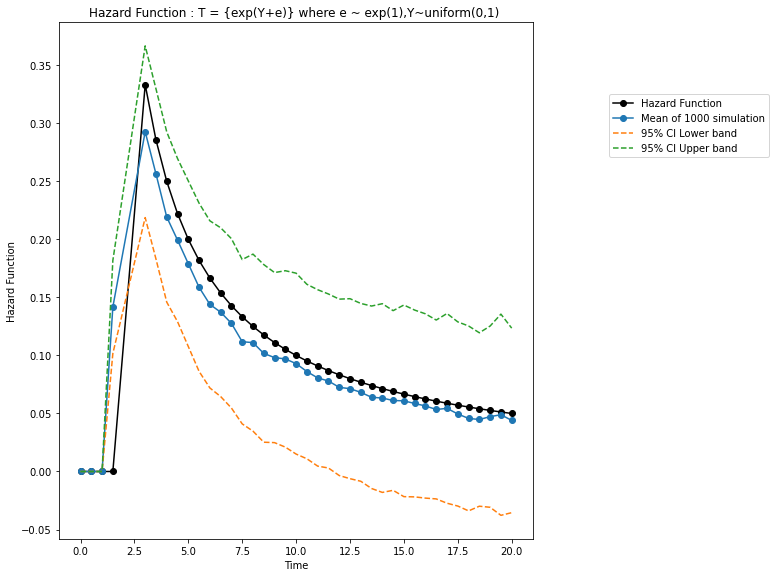

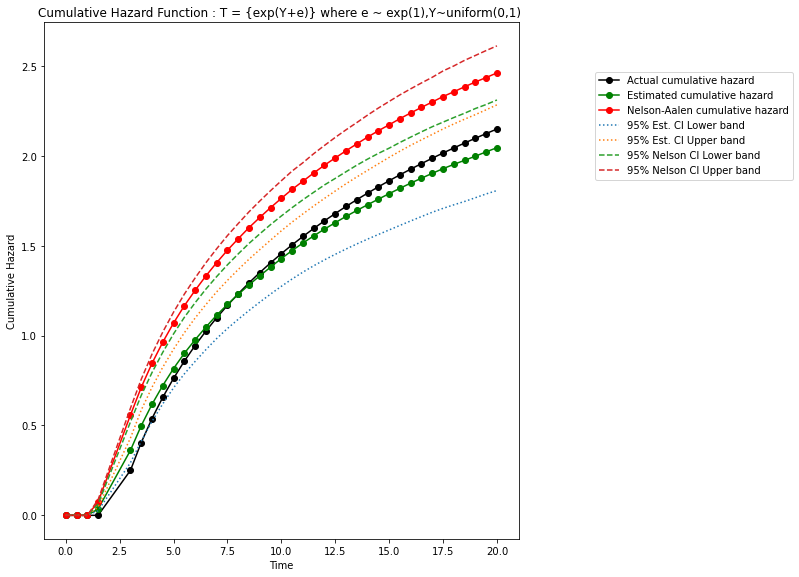

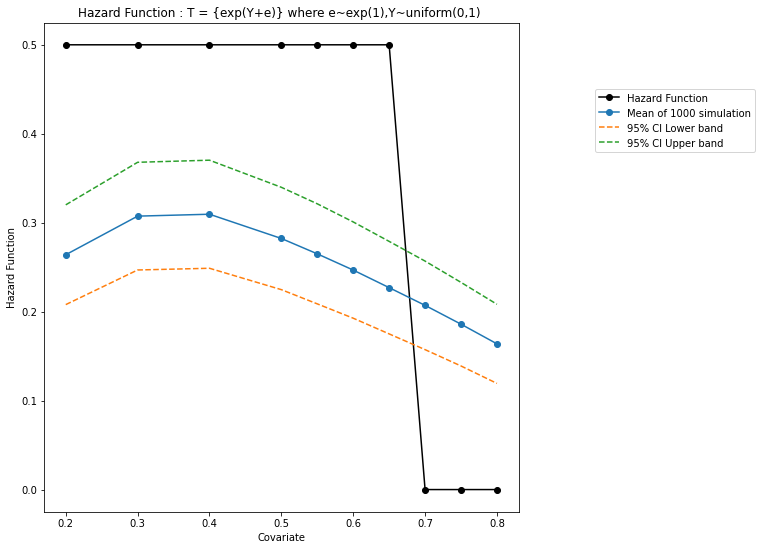

In [14]:
h_exps1=[5]
b_exps1=[0.1]

#%%prun -s cumulative
# %timeit run()a
run1(h_exps=h_exps1, b_exps= b_exps1, iterations=1)

In [ ]:
#https://lifelines.readthedocs.io/en/latest/fitters/univariate/NelsonAalenFitter.html

In [ ]:

h_exps2=[1.4625]
b_exps2=[0.014624999999999999]
#%%prun -s cumulative
# %timeit run()a
run2(h_exps=h_exps2, b_exps= b_exps2, iterations=1)

In [ ]:
h_exps3=[2.0]
b_exps3=[0.2]


#%%prun -s cumulative
# %timeit run()a
run3(h_exps=h_exps3, b_exps= b_exps3, iterations=1)

# Histograms

In [ ]:
Y,e,T,C,Z,delta,h,b =  generate_data_dist3(1, h_exp =0.6, b_exp = 0.1, size = 500, censor_proportion = 100)


print(min(Z),max(Z))
print(min(Y),max(Y))

In [ ]:
print(delta)

In [ ]:
T=900
C=800
Z = np.where(np.greater(T,C),C,T)
delta = np.where(np.greater_equal(T,Z),1,0)
print(Z)
print(delta)

In [ ]:
Ytest1 = 0.8
Ttest1 = np.array([5,10,15,20,30,40])
 

actual_hazard_t = np.array(model3_T(Ttest1,Ytest1))
actual_hazard_t

In [ ]:
cum_actual_hazard_t = np.array(model3_cumT(Ttest1,Ytest1))
cum_actual_hazard_t[1:6]- cum_hazard

In [ ]:
Ttest1.shape

In [ ]:
cum_hazard = scipy.integrate.cumulative_trapezoid(actual_hazard_t, x=Ttest1, dx=0.00001, axis=-1, initial=None)

In [ ]:
cum_hazard

In [ ]:
cum_hazard1.shape

In [ ]:
cum_hazard.shape

In [ ]:
len(cum_hazard1)

In [ ]:
Ttest1[0:len(Ttest1)-1]

In [ ]:
Ttest1 =  np.array([0,0.5,1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6,6.5,7,7.5,8,8.5,9,9.5,10,10.5,11,11.5,12,12.5,13,13.5,14,14.5,15,15.5,16,16.5,17,17.5,18,18.5,19,19.5,20])
len(Ttest1 )

In [ ]:
plt.plot(Ttest1[0:40], cum_hazard,'-o', label='Hazard Function',color="black")

In [ ]:
#Nelson-Aalen cumulative hazard
naf = NelsonAalenFitter()
bandwidth = 1
naf.fit(T, event_observed=delta, label="Nelson-Aalen hazard")
x=naf.cumulative_hazard_
x['Nelson-Aalen hazard'][0]


In [ ]:
T[0:5]

In [ ]:
C[0:5]

In [ ]:
m=x.reset_index()
len(m['Nelson-Aalen hazard'][0:500].values)

In [ ]:
m['timeline'][0:500].values

In [ ]:
plt.hist(Z, bins=10)
plt.show()

In [ ]:
# An "interface" to matplotlib.axes.Axes.hist() method
n, bins, patches = plt.hist(x=((Z)), bins='auto', color='#0504aa',
                            alpha=0.8, rwidth=1.0)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Z = min(T,C)')
plt.text(23, 45, r'$\mu=15, b=3$')
maxfreq = n.max()
# Set a clean upper y-axis limit.
plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)
print(bins,patches)


#geom_bind2d()

In [ ]:
# An "interface" to matplotlib.axes.Axes.hist() method
n, bins, patches = plt.hist(x=((abs(Y))), bins='auto', color='#0504aa',
                            alpha=0.8, rwidth=1.0)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Y-0.2')
plt.text(23, 45, r'$\mu=15, b=3$')
maxfreq = n.max()
# Set a clean upper y-axis limit.
plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)
print(bins,patches)


#geom_bind2d()

# Simulations

##### 